In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from time import time
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

# enable 16 bit precision for jax                                                                                                                             
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import jit, grad, random

import numpyro
import numpyro.distributions as dist
MultivariateNormal = dist.MultivariateNormal
from numpyro.distributions import Normal
import optax

# Import GSM                                                                                                                                                  
import sys
sys.path.append('../gsmvi//')
from gsm import GSM
from bbvi import ADVI, Scorenorm, Fishernorm
#####                                                                                                                                                         
from initializers import lbfgs_init

# sys.path.append('../utils/')
# from monitors import KLMonitor_Gauss as Monitor

import tensorflow_probability as tfp
# SinhArcsinh = tfp.substrates.jax.distributions.SinhArcsinh
# MultivariateNormal_tf = tfp.substrates.jax.distributions.MultivariateNormalFullCovariance

from IPython.display import Image, display

/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from gsmvi.monitors import KLMonitor as Monitor


# Fit Gaussian

In [5]:
@jit
def em_exact(llambda, psi, mu, cov):
    r = llambda.shape[1]
    psi_inv = jnp.diag(jnp.diagonal(psi)**-1)
    alpha = llambda.T@psi_inv    
    beta = jnp.linalg.pinv(np.identity(r) + alpha@llambda)

    gamma = cov@(alpha.T@beta.T)
    llambda_update = gamma @ jnp.linalg.pinv(beta + beta@alpha@gamma) 
    
    A = jnp.eye(D) - llambda_update @beta @ llambda.T @psi_inv
    M = A@cov@A.T + llambda_update @beta @llambda_update.T
    psi_update = jnp.diag(jnp.diagonal(M))
    
    return llambda_update, psi_update



def lower_bound_kl(cov, psi, llambda):
    A = psi + llambda@llambda.T #+ 1e-6*np.eye(psi.size)
    logabsdet = np.linalg.slogdet(A)
    # assert logabsdet.sign == 1.0    
    kl = np.trace(cov@np.linalg.pinv(A)) + logabsdet.logabsdet
    # print(np.trace(cov@np.linalg.pinv(A)), np.log((np.linalg.det(A))), np.linalg.det(A))
    return kl


#using mle for training
def fit_lr_gaussian2(data, mu, cov, num_of_latents, eta=1.0,
                tolerance=0.001,num_of_itr=100, diagnosis=False, 
                llambda=None, psi=None):
        

    D = mu.size
    K = num_of_latents
    if llambda is None:
        llambda = np.random.normal(0, 1, size=(D, K))*0.1
    if psi is None:
        psi = np.diag(np.random.random(D))


    #cap the maximum number of iterations
    #initialize
    lower_bound_old=None
    lower_bound=None
    counter=0
    losses = []
    psis, llambdas = [], []
    
    while counter < num_of_itr:

        llambda_update, psi_update = em_exact(llambda, psi, mu, cov)
        psi = (1 - eta)*psi + eta*psi_update
        llamdba = (1 - eta)*llambda  + eta*llambda_update
        #use lower bound to determine if convergeda
        lower_bound_old=lower_bound
        # lower_bound=get_lower_bound(data, mu, llambda, psi)
        lower_bound=lower_bound_kl(cov, psi, llambda)
            
        if lower_bound_old and np.abs(lower_bound/lower_bound_old-1)<tolerance:
            if diagnosis:
                print(f'{counter} iterations to reach convergence\n')
            return mu, llambda, psi, [psis, llambdas, losses]
        llambdas.append(llambda)
        psis.append(np.diag(psi))
        losses.append(lower_bound)
        counter+=1
    
    if diagnosis:
        print(f'{counter} iterations to reach convergence\n')
        
    return mu, llambda, psi, [psis, llambdas, losses]


# Factorize BAM

In [6]:
import jax
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import numpyro.distributions as dist


def fg_bam_update(lp, lp_g, samples, mu0, S0, reg):
    """
    Returns updated mean and diagonal covariance matrix with factorized BaM updates.
    """
    B = samples.shape[0]

    zbar = jnp.mean(samples, axis=0)
    C = jnp.var(samples, axis=0)

    g = lp_g(samples)

    gbar = jnp.mean(g, axis=0)
    Gamma = jnp.var(g, axis=0)

    a = Gamma + jnp.square(gbar) / (1 + reg)
    b = 1 / reg
    c = -  (C + S0 / reg + jnp.square(mu0 - zbar) / (1 + reg))

    # print("gbar:", gbar)
    # print("Gamma:", Gamma)
    # print("a:", a)
    # print("b: ", b)
    # print("c:", c)

    S_1 = (-b + jnp.sqrt(jnp.square(b) - 4 * jnp.multiply(a, c))) / (2 * a)
    S_2 = (-b - jnp.sqrt(jnp.square(b) - 4 * jnp.multiply(a, c))) / (2 * a)
    S = jnp.maximum(S_1, S_2)

    mu = (zbar + jnp.multiply(S, gbar)) * reg + mu0
    mu = mu / (1 + reg)

    return mu, S
    

class FG_BAM:
    """
    Wrapper class for using factorized BaM updates to fit a distribution.
    """
    def __init__(self, D, lp, lp_g):
        """
        Inputs:
          D: (int) Dimensionality (number) of parameters
          lp : Function to evaluate target log-probability distribution. 
               (Only used in monitor, not for fitting)
          lp_g : Function to evaluate score, i.e. the gradient of the target log-probability distribution
        """
        self.D = D
        self.lp = lp
        self.lp_g = lp_g
    
    def fit(self, key, regf, mean=None, cov_diag=None, batch_size=2, niter=5000, nprint=10, jitter=1e-6):
        """
        Main function to fit a factorized Gaussian distribution to the target.
        """
        if mean is None:
            mean = jnp.zeros(self.D)
        if cov_diag is None:
            cov_diag = jnp.ones(self.D)
        
        # params = (mean, cov_diag)
        # nevals = 1
        mean_all = np.empty((niter, self.D))
        cov_all = np.empty((niter, self.D))

        if nprint > niter: nprint = niter
        for i in range(niter):
            if (i%(niter//nprint) == 0): print(f'Iteration {i} of {niter}')
            mean_all[i, :] = mean
            cov_all[i, :] = cov_diag

            key, _ = random.split(key)        
            eps = dist.Normal(0, 1).expand([self.D]).sample(key, (batch_size, ))
            samples = mean + eps * jnp.sqrt(cov_diag)

            # if i == 0 : reg = regf(i)
            reg = regf(i)
            reg = max(reg, 1e-5)

            mean_new, cov_new = fg_bam_update(self.lp, self.lp_g, samples, mean, cov_diag, reg)

            cov_new += np.ones(self.D) * jitter
            # cov_new = (cov_new + cov_new) / 2  # symmetrize

            mean, cov_diag = mean_new, cov_new
        
        return mean, cov_diag, mean_all, cov_all






# BAM, BAM_lr

In [7]:
from bam import BAM
from gsm import GSM
from pbam import PBAM #, PBAM_fullcov
from pgsm import PGSM
from gsmvi.monitors import KLMonitor
# from gsmvi.bam_lrproject import BAM_lrproject



In [8]:

#### Simple experiment for multivaraite Gaussian with dense covariance matrix
####                                                                                                                                                         
def setup_good_model(D=10, rank=4, seed=123):

    # setup a Gaussian target distribution                                                                                                                    
    np.random.seed(seed)
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)/(D*rank)**0.5
    cov = np.matmul(L, L.T) + np.diag(np.random.random(D))
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples

def setup_model_nonorm(D=10, rank=4, seed=123):

    # setup a Gaussian target distribution                                                                                                                    
    np.random.seed(seed)
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.random(D))
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples

def setup_okay_model_D(D=10, rank=4, seed=123):

    # setup a Gaussian target distribution                                                                                                                    
    np.random.seed(seed)
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)/(D)**0.5
    cov = np.matmul(L, L.T) + np.diag(np.random.random(D))
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples

def setup_okay_model_rank(D=10, rank=4, seed=123):

    # setup a Gaussian target distribution                                                                                                                    
    np.random.seed(seed)
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)/(rank)**0.5
    cov = np.matmul(L, L.T) + np.diag(np.random.random(D))
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples



def setup_model(D=10, rank=4, seed=123):

    # setup a Gaussian target distribution                                                                                                                    
    np.random.seed(seed)
    mean = np.random.random(D)
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.diag(np.random.normal(1, 1, D)*1e-1+1)
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 10000)
    return model, mean, cov, lp, lp_g, ref_samples


def setup_gauss_model(D, seed=123, noise=1e-2, mean=None, rank=None):
    np.random.seed(seed)
    if mean is None:
        mean = np.random.random(D)
    if rank is None:
        rank = D
    L = np.random.normal(size = D*rank).reshape(D, rank)
    cov = np.matmul(L, L.T) + np.eye(D)*noise
    model = dist.MultivariateNormal(loc=mean, covariance_matrix=cov)
    lp = jit(lambda x: jnp.sum(model.log_prob(x)))
    lp_g = jit(grad(lp, argnums=0))
    ref_samples = np.random.multivariate_normal(mean, cov, 5000)
    return mean, cov, lp, lp_g, ref_samples

22.52512069939141 -6.955624550497679e-15
0.9387112833742389 0.004556520379373041


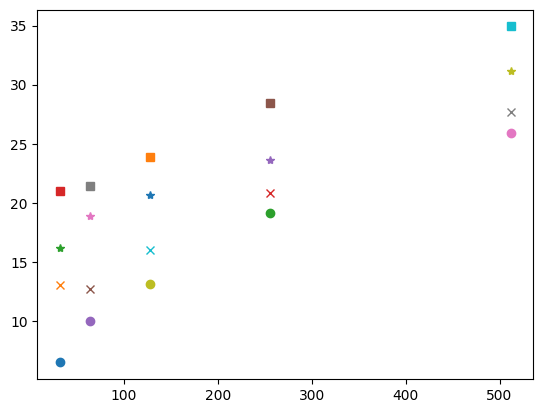

In [9]:
D = 128
rank = 8
L = np.random.normal(size = D*rank).reshape(D, rank)/(rank)**0.5
cov = L@L.T
cov.shape
dcov = np.diag(np.random.random(D))
print(np.linalg.eigvalsh(cov).max(), np.linalg.eigvalsh(cov).min())
print(np.linalg.eigvalsh(dcov).max(), np.linalg.eigvalsh(dcov).min())
# plt.plot(np.linalg.eigvalsh(dcov))
# plt.plot(np.linalg.eigvalsh(cov))

for d in range(5, 10):
    D= 2**d
    rank = 4
    L = np.random.normal(size = D*rank).reshape(D, rank)#/(rank)**0.5
    cov = L@L.T
    plt.plot(D, np.linalg.eigvalsh(cov).max()/(D)**0.5, 'o')
    rank = 8
    L = np.random.normal(size = D*rank).reshape(D, rank)#/(rank)**0.5
    cov = L@L.T
    plt.plot(D, np.linalg.eigvalsh(cov).max()/(D)**0.5, 'x')
    rank = 16
    L = np.random.normal(size = D*rank).reshape(D, rank)#/(rank)**0.5
    cov = L@L.T
    plt.plot(D, np.linalg.eigvalsh(cov).max()/(D)**0.5, '*')
    rank = 32
    L = np.random.normal(size = D*rank).reshape(D, rank)#/(rank)**0.5
    cov = L@L.T
    plt.plot(D, np.linalg.eigvalsh(cov).max()/(D)**0.5, 's')


710.1031852531024
817.7689596464653
1620.906058825624
125413.6555876544


125413.65558551687

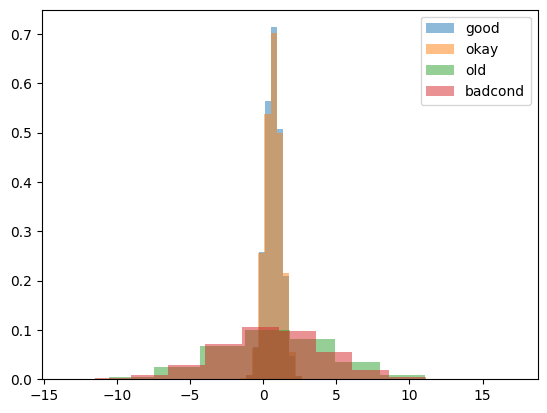

In [878]:
D = 1024
rank = 16
K = rank
model, mean, cov, lp, lp_g, ref_samples = setup_good_model(D, rank)
print(np.linalg.cond(cov))
plt.hist(ref_samples[:, 0], density=True, alpha=0.5, label='good')
model, mean, cov, lp, lp_g, ref_samples = setup_okay_model(D, rank)
print(np.linalg.cond(cov))
plt.hist(ref_samples[:, 0], density=True, alpha=0.5, label='okay')
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)
print(np.linalg.cond(cov))
plt.hist(ref_samples[:, 0], density=True, alpha=0.5, label='old')
mean, cov, lp, lp_g, ref_samples = setup_gauss_model(D, rank=rank)
print(np.linalg.cond(cov))
plt.hist(ref_samples[:, 0], density=True, alpha=0.5, label='badcond')
plt.legend()

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

batch_size = 2
niter = 1000
nprint = 10
regf = lambda x: 100/(1+x)

eigs = np.linalg.eigvalsh(cov)
eigs.max()/eigs.min()

In [45]:
start = time()
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = BAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
batch_size = 2
niter = 200
regf = lambda x: 100/(1+x)

monitorbam = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=10)
# monitor = None
meanfit, covfit = alg.fit(key,  batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitorbam, check_goodness=False)
# meanfit, covfit = alg.fit(key,  batch_size=batch_size, niter=niter, nprint=nprint, monitor=monitorbam, check_goodness=False)
print(time()-start)

use low rank
Iteration 0 of 200
Iteration 20 of 200
Iteration 40 of 200
Iteration 60 of 200
Iteration 80 of 200
Iteration 100 of 200
Iteration 120 of 200
Iteration 140 of 200
Iteration 160 of 200
Iteration 180 of 200
Iteration 200 of 200
18.37948179244995


In [111]:
start = time()
ranklr = rank

batch_size = 2
niter = 1000
alg3 = PBAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
nprint = 10
regf = lambda x: 100/(1+x)
# regf = lambda x: 1/(1+x)
# regf = lambda x: 0.1#/(1+x)
# regf = lambda i :  0.1*i*(i<201) + (i>100)*10000/(1+i)
psi_init = np.random.random(D)*1
llambda_init = np.random.random((D, K))/(D*K)**0.5
monitor3 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfit3, psi, llambda = alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, 
                                  psi=psi_init, llambda=llambda_init,
                                  tolerance=1e-4, eta=1.2, niter_em=501, 
                                  updateform='diana',
                                  updatemode='llambda0',
                                  print_convergence=False, monitor=monitor3)
# covfit3 = np.diag(psi) + llambda@llambda.T
print(time() - start)

Iteration 0 of 1000. Time taken :  2.86102294921875e-06
compiled
time for first 10 iterations :  2.194037914276123
Iteration 100 of 1000. Time taken :  9.30046558380127
Iteration 200 of 1000. Time taken :  14.008224248886108
Iteration 300 of 1000. Time taken :  18.41409134864807
Iteration 400 of 1000. Time taken :  22.782861471176147
Iteration 500 of 1000. Time taken :  27.145607471466064
Iteration 600 of 1000. Time taken :  31.49385356903076
Iteration 700 of 1000. Time taken :  35.843164682388306
Iteration 800 of 1000. Time taken :  40.218411684036255
Iteration 900 of 1000. Time taken :  44.57083010673523
Iteration 1000 of 1000. Time taken :  48.90241479873657
Total number of projections :  5520 5.52
49.82189345359802


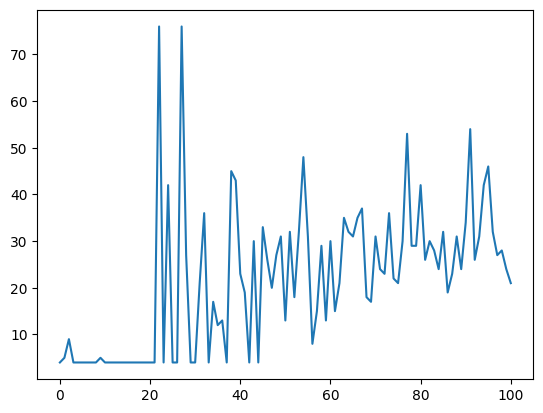

In [131]:
plt.plot(monitor3.k)

22.0

5.52


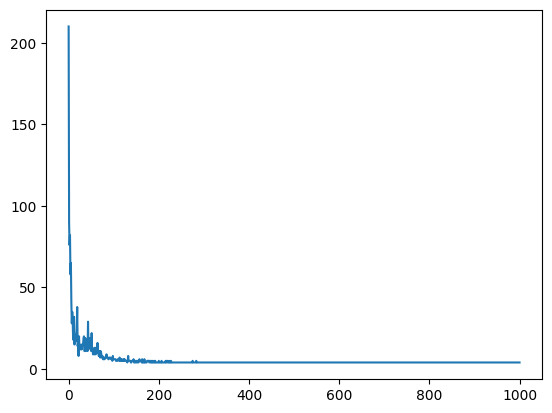

In [112]:
print(np.sum(monitor3.nprojects)/niter)
plt.plot(monitor3.nprojects[:]);

[]

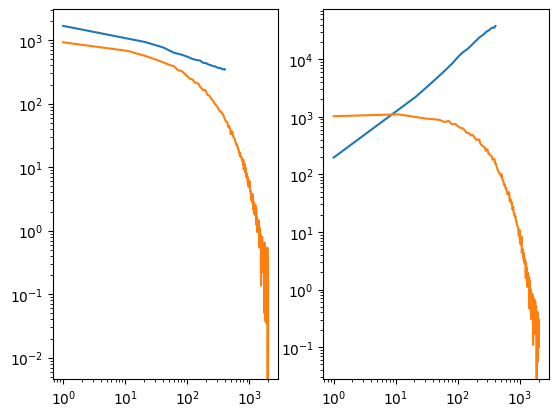

In [113]:
plt.subplot(121)
plt.plot(monitorbam.nevals, monitorbam.rkl)
plt.plot(monitor3.nevals, monitor3.rkl)
plt.loglog()
plt.subplot(122)
plt.plot(monitorbam.nevals, monitorbam.fkl)
plt.plot(monitor3.nevals, monitor3.fkl)
plt.loglog()

In [114]:
meanfit3;

320


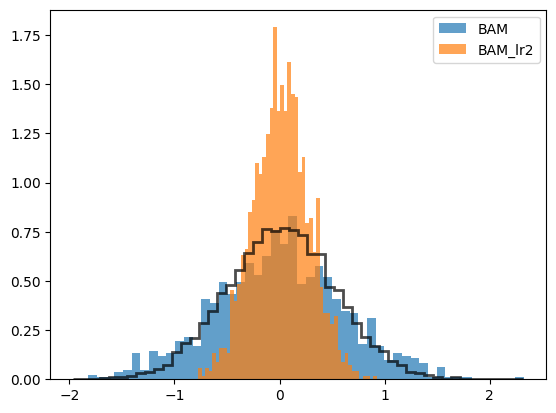

In [115]:
i = np.random.randint(D)
print(i)
plt.hist(np.random.multivariate_normal(meanfit, covfit, 1000)[..., i], bins=50, density=True, alpha=0.7, label='BAM');
# plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 10000)[..., i], bins=50, density=True, alpha=0.7, label='BAM_lr');
eps = np.random.normal(0, 1, (2000, D))
z = np.random.normal(0, 1, (2000, ranklr))
s3 = meanfit3 + psi*eps + (llambda@z.T).T
# s3 = np.random.multivariate_normal(meanfit3, covfit3, 5000)
# s3 = np.random.multivariate_normal(meanfit3[0], covfit3, 5000)
plt.hist(s3[..., i], bins=50, density=True, alpha=0.7, label='BAM_lr2');
plt.hist(ref_samples[..., i], bins=50, density=True, alpha=0.7, histtype='step', lw=2, color='k');
plt.legend()



[137 479 217 209 340]


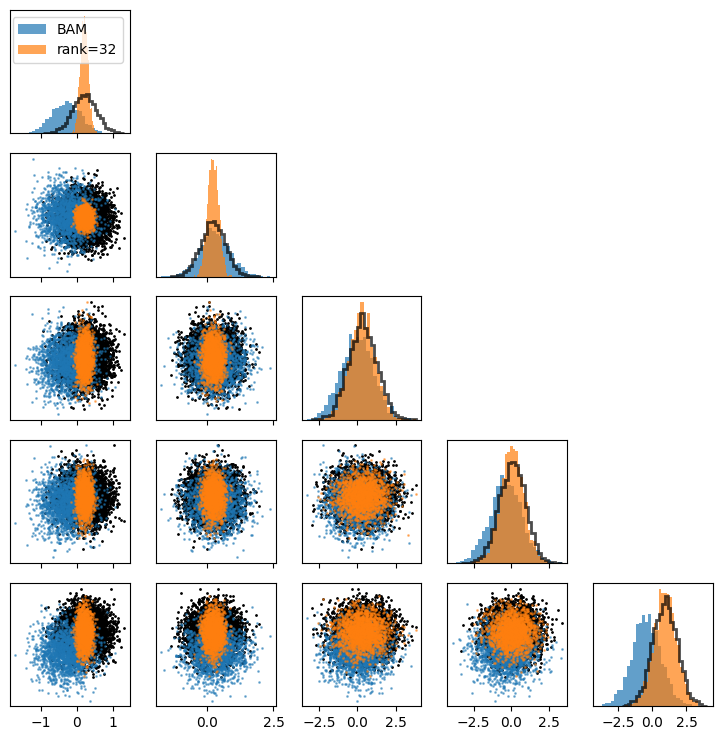

In [117]:
s = ref_samples[:5000, :] 
s1 = np.random.multivariate_normal(meanfit, covfit, 2000)
# s1 = None
# s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
s2 = None
# s3 = np.random.multivariate_normal(meanfit3, covfit3, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            if s1 is not None: ax[i, i].hist(s1[..., ii], alpha=0.7, density=True, bins=30, label=f"BAM");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}-fullcov");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            if s1 is not None: ax[j, i].plot(s1[..., ii], s1[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            if s2 is not None: ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# Mean field GSM

In [93]:
from gsmvi.gsm_mf import GSM_MF

alg_gsm_mf = GSM_MF(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
batch_size = 1
niter = 1000

monitorgsmmf = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=10)
# monitor = None
mean_gsmmf, cov_gsmmf = alg_gsm_mf.fit(key,  batch_size=batch_size, niter=niter, nprint=nprint, monitor=monitorgsmmf, check_goodness=True)


Iteration 0 of 1000
Iteration 100 of 1000
Iteration 200 of 1000
Iteration 300 of 1000
Iteration 400 of 1000
Iteration 500 of 1000
Iteration 600 of 1000
Iteration 700 of 1000
Iteration 800 of 1000
Iteration 900 of 1000
Iteration 1000 of 1000


[]

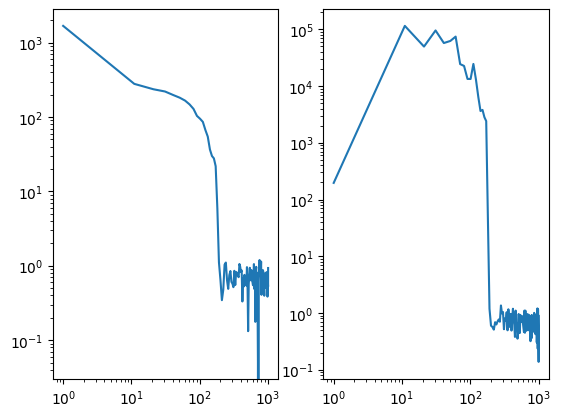

In [94]:
plt.subplot(121)
plt.plot(monitorgsmmf.nevals, monitorgsmmf.rkl)
plt.loglog()
plt.subplot(122)
plt.plot(monitorgsmmf.nevals, monitorgsmmf.fkl)
plt.loglog()

[ 73 306  29 360 421]


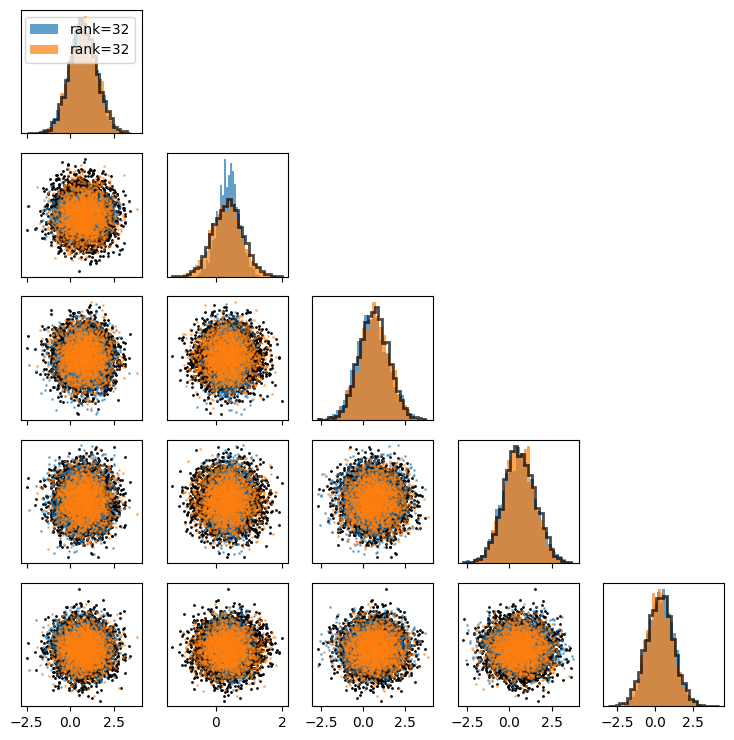

In [95]:
s = ref_samples[:5000, :] 
s_gsmmf = np.random.multivariate_normal(mean_gsmmf, np.diag(cov_gsmmf), 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_gsmmf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_gsmmf[..., ii], s_gsmmf[..., jj], '.', alpha=0.5, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# factorized BAM


In [79]:

alg_bam_mf = FG_BAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
batch_size = 2
niter = 5000
regf = lambda x: 100/(1+x)

monitorbammf = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=10)
# monitor = None
mean_bammf, cov_bammf, _, _ = alg_bam_mf.fit(key,  regf, batch_size=batch_size, niter=niter, nprint=nprint, )


Iteration 0 of 5000
Iteration 500 of 5000
Iteration 1000 of 5000
Iteration 1500 of 5000
Iteration 2000 of 5000
Iteration 2500 of 5000
Iteration 3000 of 5000
Iteration 3500 of 5000
Iteration 4000 of 5000
Iteration 4500 of 5000


[53  0 59 62 63]


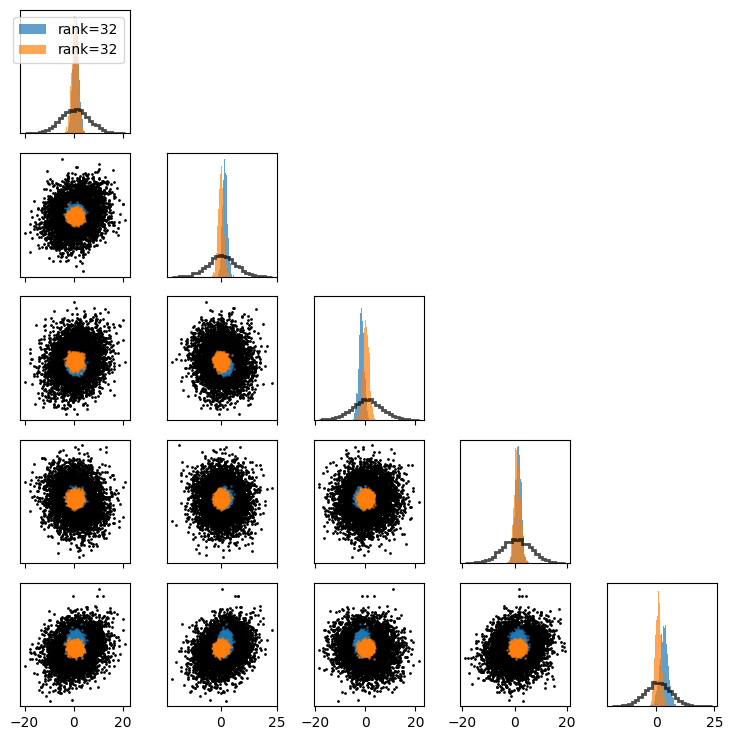

In [81]:
s = ref_samples[:5000, :] 
s_gsmmf = np.random.multivariate_normal(mean_gsmmf, np.diag(cov_gsmmf), 2000)
s_bammf = np.random.multivariate_normal(mean_bammf, np.diag(cov_bammf), 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            # ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_gsmmf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_bammf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            # ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_gsmmf[..., ii], s_gsmmf[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_bammf[..., ii], s_bammf[..., jj], '.', alpha=0.5, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# bfgs

In [82]:
from gsmvi.initializers import lbfgs_init

In [83]:
mean_bfgs, cov_bfgs, res = lbfgs_init(np.random.random(D), lp, lp_g)
print(res)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 121.47617318875791
        x: [ 6.985e-01  2.855e-01 ...  6.258e-01  6.768e-01]
      nit: 37
      jac: [ 6.686e-05 -6.662e-05 ... -1.498e-04  1.399e-04]
     nfev: 40
     njev: 40
 hess_inv: <64x64 LbfgsInvHessProduct with dtype=float64>


In [84]:
from scipy.optimize import minimize
f = lambda x: -lp(x)
if lp_g is not None:
    f_g = lambda x: -lp_g(x)
else:
    f_g = None
x0 = np.random.random(D)+10.
res = minimize(f, x0, method='L-BFGS-B', jac=f_g, \
               options={"maxiter":1000, "maxfun":1000, "maxcor":10, "ftol":1e-10, "gtol":1e-10, })
# res = minimize(f, x0, method='L-BFGS-B', jac=f_g, \
#                options={"maxiter":1000, "maxfun":1000, "maxcor":10})

mean_bfgs  = res.x
cov_bfgs = res.hess_inv.todense()
print(res)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 121.47617141983963
        x: [ 6.964e-01  2.858e-01 ...  6.253e-01  6.746e-01]
      nit: 73
      jac: [-7.151e-06 -7.042e-06 ...  4.122e-06  2.753e-06]
     nfev: 81
     njev: 81
 hess_inv: <64x64 LbfgsInvHessProduct with dtype=float64>


In [85]:
_, llambda_init, psi_init, _ = fit_lr_gaussian2(np.zeros(D), np.zeros(D), cov_bfgs, rank, tolerance=0., num_of_itr=500, diagnosis=True)
psi_init = np.diag(psi_init)
mean_init = mean_bfgs

500 iterations to reach convergence



In [86]:
# %timeit res.hess_inv(x0)
# %timeit (m@x0)

In [87]:
np.random.seed(90)
mean_init = jnp.zeros(D)
# llambda_init = np.random.normal(0, 1, size=(D, rank)) 
# psi_init = 1+np.random.random(D)
# llambda_init = np.random.normal(0, 0.1, size=(D, rank)) 
# psi_init = 0.1 + np.random.random(D)*0.01
eps = np.random.normal(0, 1, (2000, D))
z = np.random.normal(0, 1, (2000, ranklr))
s_init = mean_init + psi_init*eps + (llambda_init@z.T).T
s_init.shape

(2000, 64)

[38  1 37 26 55]


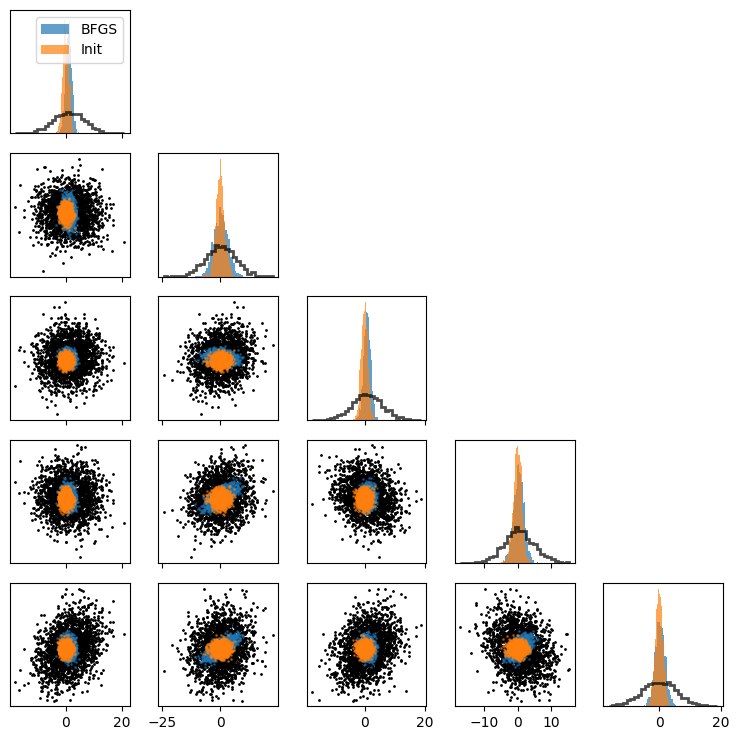

In [88]:
s = ref_samples[:2000, :] 
s_bfgs = np.random.multivariate_normal(mean_bfgs, cov_bfgs, 2000)
s_gsmmf = np.random.multivariate_normal(mean_gsmmf, np.diag(cov_gsmmf), 2000)
# s_bammf = np.random.multivariate_normal(mean_bammf, np.diag(cov_bammf), 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            # ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            # ax[i, i].hist(s_gsmmf[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            ax[i, i].hist(s_bfgs[..., ii], alpha=0.7, density=True, bins=30, label="BFGS");
            ax[i, i].hist(s_init[..., ii], alpha=0.7, density=True, bins=30, label="Init");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            # ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            # ax[j, i].plot(s_gsmmf[..., ii], s_gsmmf[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_bfgs[..., ii], s_bfgs[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s_init[..., ii], s_init[..., jj], '.', alpha=0.5, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()


# PGSM

In [91]:
ranklr = rank
# alg2 = PBAM_fullcov(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)
# monitor2 = KLMonitor(batch_size=100, ref_samples=ref_samples, checkpoint=5)
# meanfit2, covfit2 = alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitor, early_stop=False)

batch_size = 2
niter = 100
alg4 = PGSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
nprint = 10
# regf = lambda x: 1/(1+x)
# regf = lambda x: 0.1#/(1+x)
# regf = lambda i :  0.1*i*(i<201) + (i>100)*10000/(1+i)
monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanpgsm, psipgsm, llambdapgsm = alg4.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, nprint=nprint, 
                                  tolerance=1e-4, eta=1., niter_em=501, gamma=0., scalellambda=0.1,
                                  print_convergence=False, monitor=monitor2)
# covfit3 = np.diag(psi) + llambda@llambda.T



Iteration 0 of 100. Time taken :  2.1457672119140625e-06
compiled
Iteration 10 of 100. Time taken :  0.12726068496704102
time for first 10 iterations :  0.1272749900817871
Iteration 20 of 100. Time taken :  0.3387892246246338
Iteration 30 of 100. Time taken :  0.5693292617797852
Iteration 40 of 100. Time taken :  0.8047440052032471
Iteration 50 of 100. Time taken :  1.048713207244873
Iteration 60 of 100. Time taken :  1.2804248332977295
Iteration 70 of 100. Time taken :  1.5101227760314941
Iteration 80 of 100. Time taken :  1.7196998596191406
Iteration 90 of 100. Time taken :  1.9165008068084717
Iteration 100 of 100. Time taken :  2.119844436645508
Total number of projections :  3344 33.44


In [92]:
sum(monitor2.nprojects)/niter

33.44

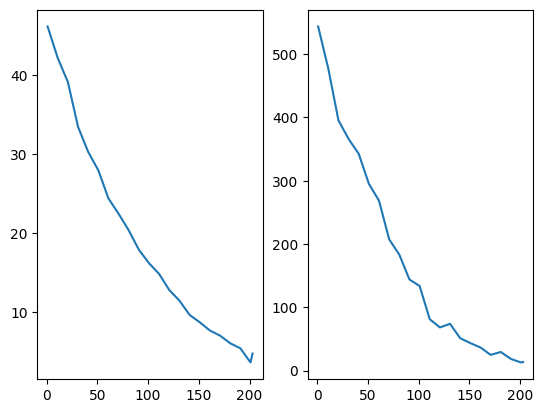

In [93]:
plt.subplot(121)
# plt.plot(monitorbam.nevals, monitorbam.rkl)
plt.plot(monitor2.nevals, monitor2.rkl)
# plt.loglog()
plt.subplot(122)
# plt.plot(monitorbam.nevals, monitorbam.fkl)
plt.plot(monitor2.nevals, monitor2.fkl)
# plt.loglog()

[ 0  2 57 12 39]


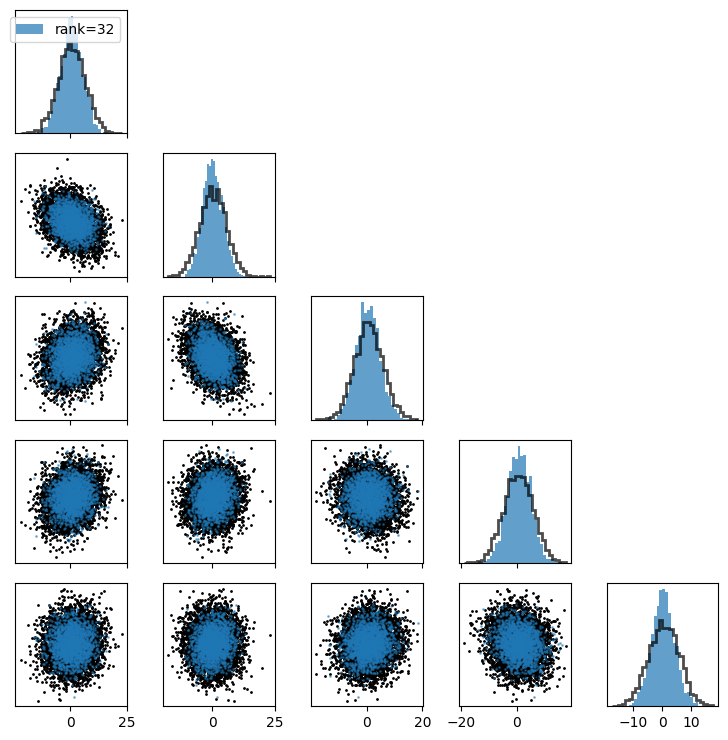

In [94]:
s = ref_samples[:5000, :] 
eps = np.random.normal(0, 1, (2000, D))
z = np.random.normal(0, 1, (2000, ranklr))
s3 = meanpgsm + psipgsm*eps + (llambdapgsm@z.T).T
# s1 = np.random.multivariate_normal(meanfit, covfit, 2000)
s1 = None
# s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
s2 = None
# s3 = np.random.multivariate_normal(meanfit3, covfit3, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            if s1 is not None: ax[i, i].hist(s1[..., ii], alpha=0.7, density=True, bins=30, label=f"BAM");
            ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}");
            if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"rank={ranklr}-fullcov");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            if s1 is not None: ax[j, i].plot(s1[..., ii], s1[..., jj], '.', alpha=0.5, ms=2)
            ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            if s2 is not None: ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()



# timings

## scaling with dims

In [ ]:
ranklr = 8
batch_size = 2
niter = 20
nprint = -1
regf = lambda x: 100


tfull, tlr = [], []
dimsfull, dimslr = [], []
for i in range(3, 12):
    D = 2**i
    dimslr.append(D)
    print(D)
    model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=8)
    lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
    lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

    
    if D < 500:
        dimsfull.append(D)
        alg2 = PBAM_fullcov(D, lp_vmap, lp_g_vmap)
        key = jax.random.PRNGKey(2)
        alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, monitor=None, early_stop=False, verbose=False)


    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)
    

    if D < 500:
        start = time()
        alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=None, early_stop=False, verbose=False)
        tfull.append(time()-start)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tlr.append(time()-start)

dimsfull = np.array(dimsfull )
dimslr = np.array(dimslr )
tfull = np.array(tfull)
tlr = np.array(tlr)



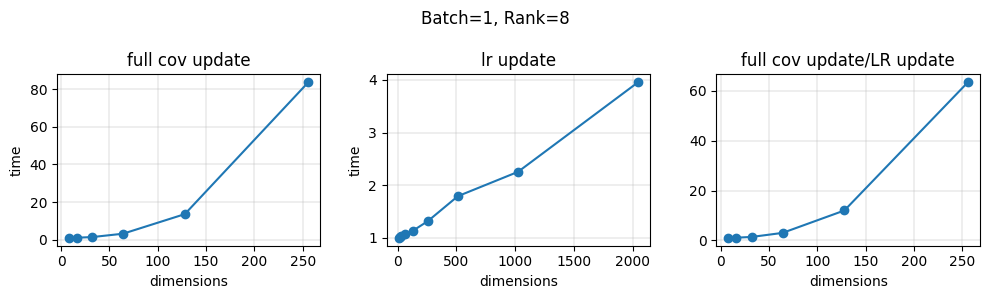

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(dimsfull, tfull/tfull[0], marker='o')
ax[0].set_title('full cov update')
ax[1].plot(dimslr, tlr/tlr[0], marker='o')
ax[1].set_title('lr update')
ax[2].plot(dimsfull, tfull/tfull[0]/tlr[:len(dimsfull)]*tlr[0], marker='o')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    # axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
plt.suptitle(f'Batch={batch_size}, Rank={ranklr}')
plt.tight_layout()
 


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(dimsfull, tfull/tfull[0], marker='o')
ax[0].set_title('full cov update')
ax[1].plot(dimslr, tlr/tlr[0], marker='o')
ax[1].set_title('lr update')
ax[2].plot(dimsfull, tfull/tfull[0]/tlr[:len(dimsfull)]*tlr[0], marker='o')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
plt.suptitle(f'Batch={batch_size}, Rank={rank}')
plt.tight_layout()
 


In [19]:
# rank = 8 
# ranklr = 4
# batch_size = 4
# niter = 20
# nprint = -1
# regf = lambda x: 100



# tlr = []
# dimslr = []
# for i in range(3, 12):
#     D = 2**i
#     dimslr.append(D)
#     print(D)
#     model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=8)
#     lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
#     lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


#     alg3 = PBAM(D, lp_vmap, lp_g_vmap)
#     key = jax.random.PRNGKey(2)
#     alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=5, regf=regf, nprint=nprint, verbose=False)
    
#     start = time()
#     alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
#     tlr.append(time()-start)

# tlr = np.array(tlr)

8
jit psi/llambda update
16
jit psi/llambda update
32
jit psi/llambda update
64
jit psi/llambda update
128
jit psi/llambda update
256
jit psi/llambda update
512
jit psi/llambda update
1024
jit psi/llambda update
2048
jit psi/llambda update


In [37]:
# # plt.plot(dimslr, tlr/tlr[0], marker='o')
# plt.plot(dimslr, tlr, marker='o')
# plt.loglog()


## scaling with rank & batch

In [67]:
batch_size = 1
niter = 20
nprint = -1
regf = lambda x: 100

D = 512
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=256)
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

ranks = []
tranks = []

for i in range(1, 10):
    
    ranklr = 2**i
    print(ranklr)
    ranks.append(ranklr)
    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tranks.append(time()-start)

ranks = np.array(ranks)
tranks = np.array(tranks)

2
jit pbam update
jit psi/llambda update
4
jit pbam update
jit psi/llambda update
8
jit pbam update
jit psi/llambda update
16
jit pbam update
jit psi/llambda update
32
jit pbam update
jit psi/llambda update
64
jit pbam update
jit psi/llambda update
128
jit pbam update
jit psi/llambda update
256
jit pbam update
jit psi/llambda update
512
jit pbam update
jit psi/llambda update


(0.01, 100.0)

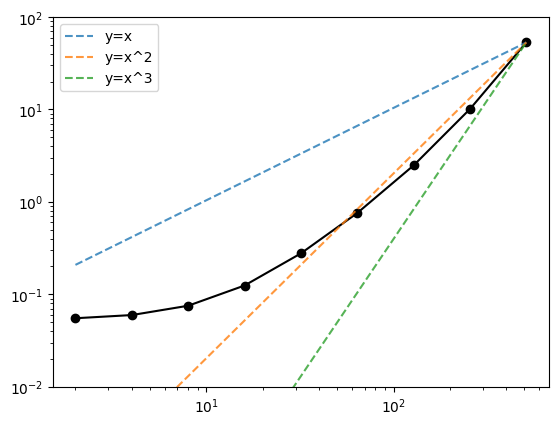

In [76]:
plt.plot(ranks, tranks, 'k', marker='o')
plt.plot(ranks, ranks/ranks[-1]*tranks[-1],  alpha=0.8, ls='--', label='y=x')
plt.plot(ranks, ranks**2/ranks[-1]**2*tranks[-1], alpha=0.8, ls='--', label='y=x^2')
plt.plot(ranks, ranks**3/ranks[-1]**3*tranks[-1],  alpha=0.8, ls='--', label='y=x^3')
plt.loglog()
plt.legend()
plt.ylim(1e-2, 1e2)

In [69]:
ranklr = 4
niter = 20
nprint = -1
regf = lambda x: 100


D = 512
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=256)
lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))

batches = []
tbatches = []

for i in range(1, 8):
    
    batch_size = 2**i
    print(batch_size)
    batches.append(batch_size)
    alg3 = PBAM(D, lp_vmap, lp_g_vmap)
    key = jax.random.PRNGKey(2)
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=2, regf=regf, nprint=nprint, verbose=False)

    start = time()
    alg3.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, verbose=False)
    tbatches.append(time()-start)

batches = np.array(batches)
tbatches = np.array(tbatches)

2
jit pbam update
jit psi/llambda update
4
jit pbam update
jit psi/llambda update
8
jit pbam update
jit psi/llambda update
16
jit pbam update
jit psi/llambda update
32
jit pbam update
jit psi/llambda update
64
jit pbam update
jit psi/llambda update
128
jit pbam update
jit psi/llambda update


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


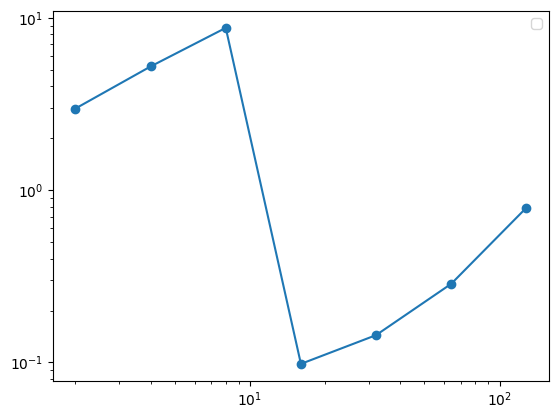

In [79]:
plt.plot(batches, tbatches, marker='o')
# plt.plot(batches, batches/batches[-1]*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x')
# plt.plot(batches, batches**2/batches[0]**2*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x^2')
# plt.plot(batches, batches**3/batches[0]**3*tbatches[0], color='k', alpha=0.8, ls='--', label='y=x^3')
plt.loglog()
plt.legend()

# image


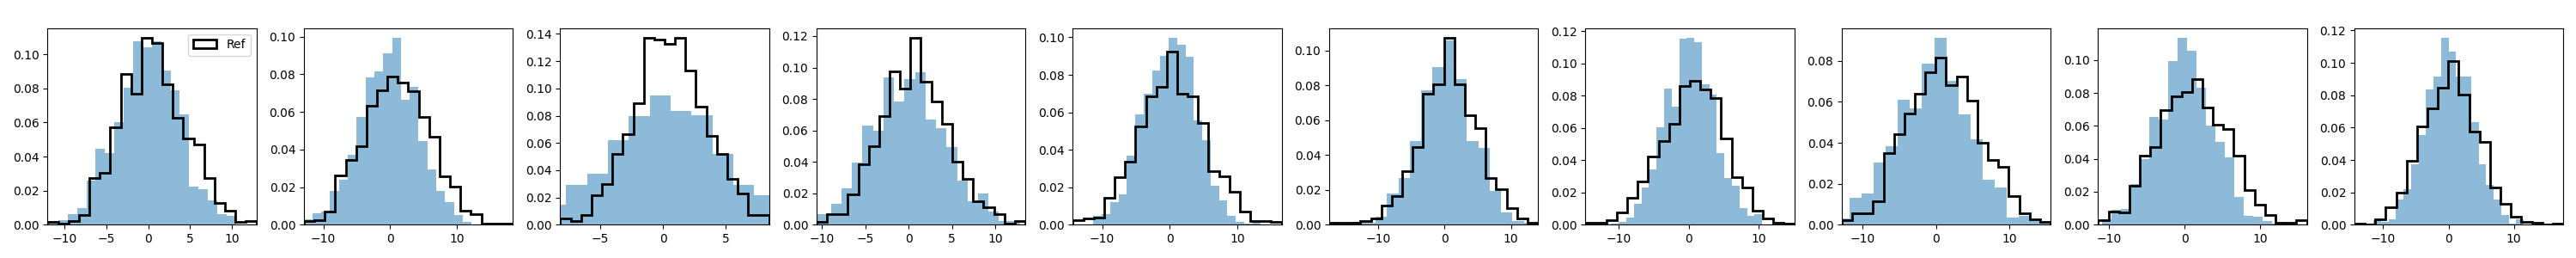

In [231]:
# display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D4096-goodcond/R32-seed0/pbam_diana/B2-reg1.00_llambda0/hist200.png'))
# display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D256-goodcond/R16-seed0/padvi/B2-lr0.010/hist.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/padvi/B2-lr0.010/hist.png'))

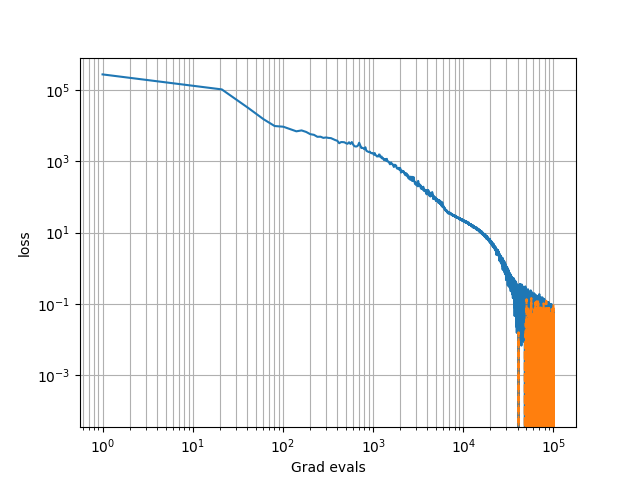

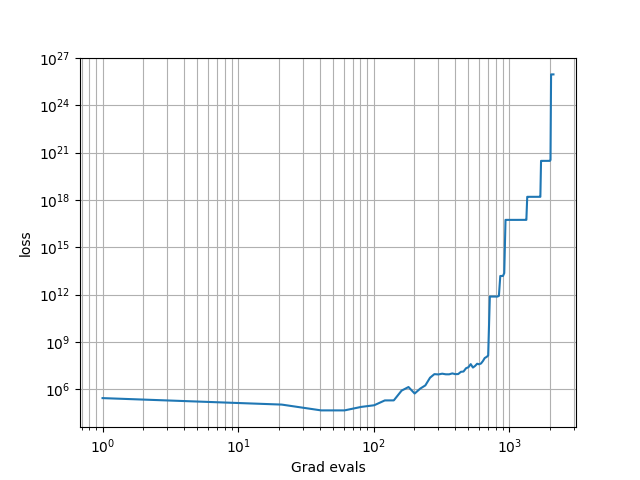

In [235]:
display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D2048-goodcond/R32-seed0/pbam_diana/B2-reg1.00_current/rkl.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D2048-goodcond/R32-seed0/pbam_diana/B2-reg1.00_llambda0//hist.png'))
display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D2048-goodcond/R32-seed0/pbam_diana/B2-reg10.00_current-reset//rkl.png'))


diana current
//mnt/ceph/users/cmodi/pbam/Gauss-D8192-ranknorm/R32-seed0/pbam_diana/B8-reg1.00_current-reset/hist10000.png not found


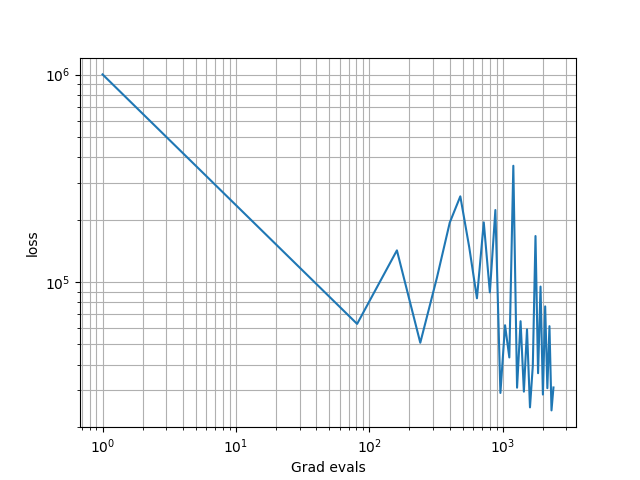

lawrence current


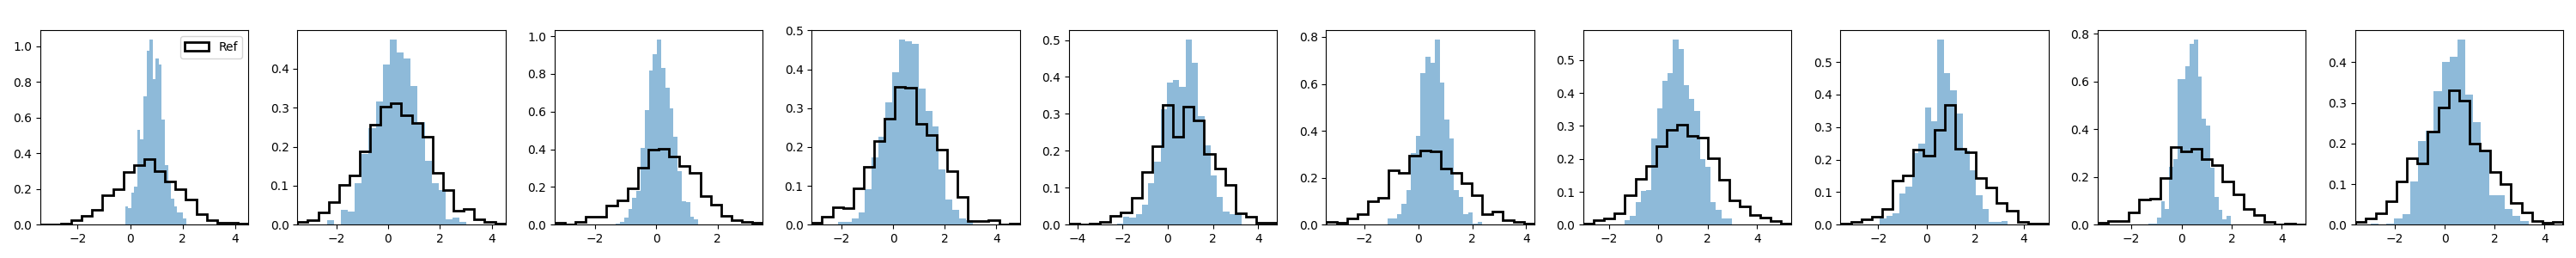

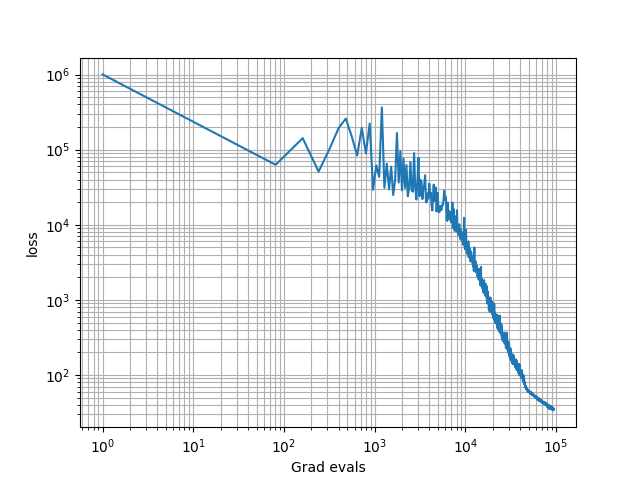

In [227]:
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_current/hist.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_llambda0//hist.png'))
# # display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg100.00_current/hist1000.png'))
# # display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg100.00_llambda0//hist1000.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence//B2-reg10.00_current/hist.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence//B2-reg10.00_llambda0//hist.png'))
# # display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg100.00_current/hist1000.png'))
# # display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg100.00_llambda0//hist1000.png'))


D = 8192
reg = 1
mode = 'current'
B = 8
for form in ['diana', 'lawrence']:
    # for mode in ['current', 'llambda0']:
    for mode in ['current']:
        print(form, mode)  
        fname = f'//mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_{form}/B{B}-reg{reg:0.2f}_{mode}-reset/hist10000.png'
        if os.path.isfile(fname):
            try : display(Image(fname))
            except Exception as e: print(e)
        else:
            print(f"{fname} not found")
        fname = f'//mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_{form}/B{B}-reg{reg:0.2f}_{mode}-reset/rkl.png'
        if os.path.isfile(fname):
            try : display(Image(fname))
            except Exception as e: print(e)
        else:
            print(f"{fname} not found")

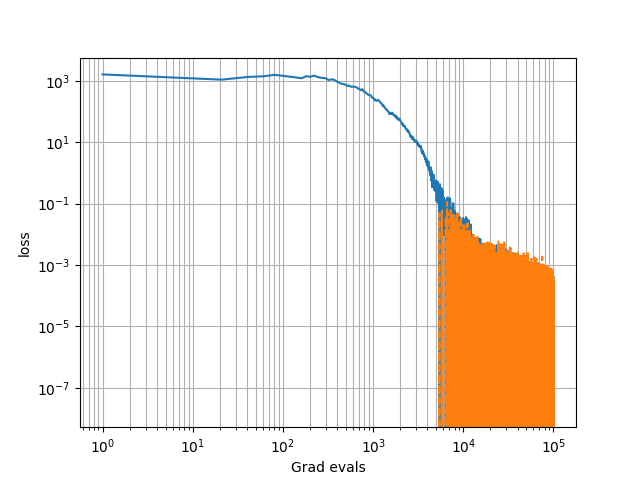

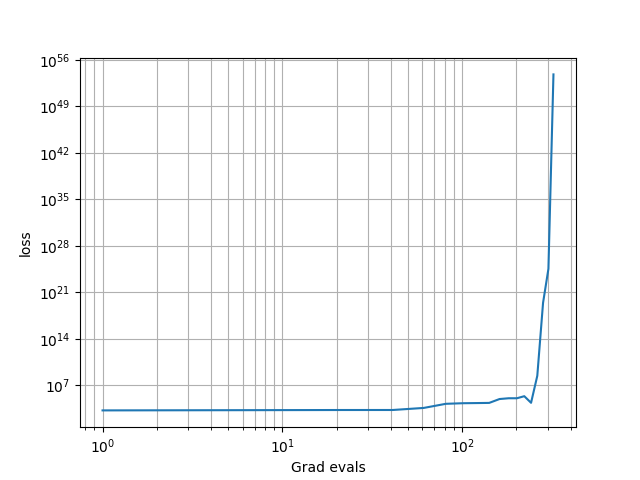

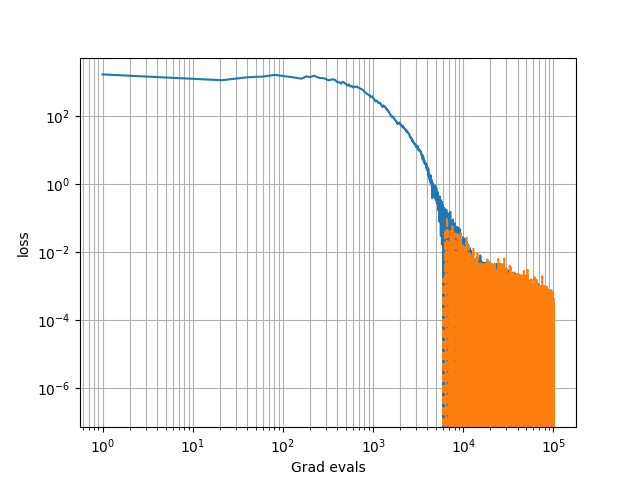

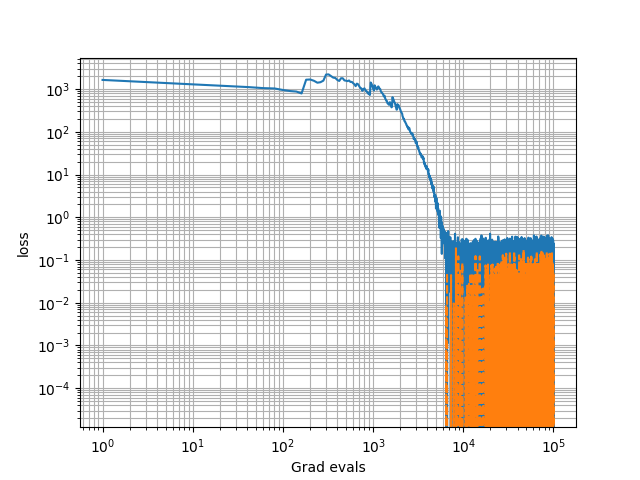

In [148]:
display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_current/fkl.png'))
display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_llambda0//fkl.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg100.00_current/fkl.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg100.00_llambda0//fkl.png'))
display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence//B2-reg10.00_current/fkl.png'))
display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence//B2-reg10.00_llambda0//fkl.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg100.00_current/fkl.png'))
# display(Image('//mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg100.00_llambda0/fkl.png'))

[]

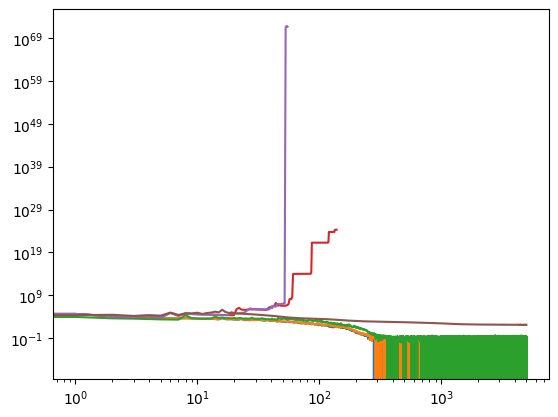

In [153]:
fname = 'rkl'
plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_current/{fname}.npy'))
# plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_llambda0/{fname}.npy'))
plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg10.00_current/{fname}.npy'))
plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg10.00_llambda0/{fname}.npy'))
plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg100.00_current/{fname}.npy'))
# plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg100.00_llambda0/{fname}.npy'))
plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg100.00_current/{fname}.npy'))
plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_lawrence/B2-reg100.00_llambda0/{fname}.npy'))
plt.loglog()

In [149]:
np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_current/{fname}.npy')/np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D1024-goodcond/R32-seed0/pbam_diana/B2-reg10.00_llambda0/{fname}.npy')

ValueError: operands could not be broadcast together with shapes (5002,) (19,) 

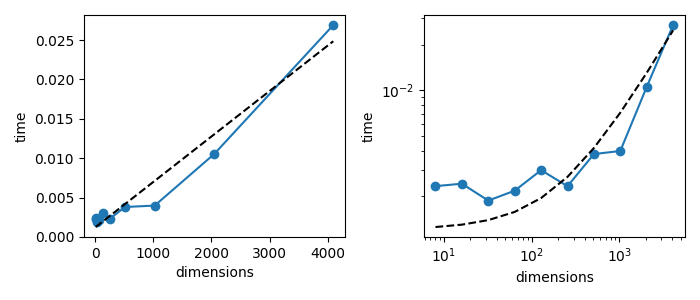

In [113]:
Image('../scripts/tmp/timing.png')

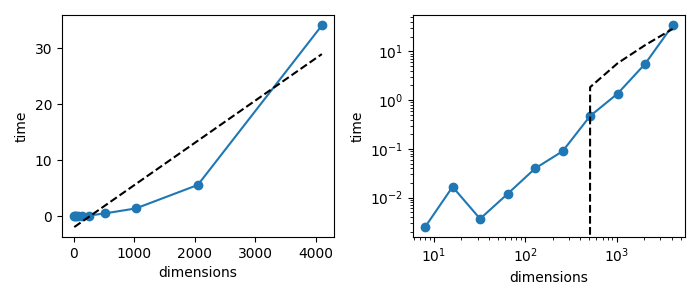

In [114]:
Image('../scripts/tmp/timing_fullcov.png')

In [88]:
m = np.random.random((256, 256, 256))

In [58]:
# for i in range(3):
#     [j.mean(axis=i) for j in np.split(m, 8, i)]

In [86]:
n = np.array([j.mean(axis=i) for i in range(3) for j in np.split(m, 8, i)])

In [80]:
n.shape

(24, 256, 256)

In [95]:
%%timeit
np.array([j.mean(axis=i) for i in range(3) for j in np.split(m, 8, i)])

79.7 ms ± 922 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
D = 8
model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=4)

In [98]:
%timeit model.log_prob(ref_samples)

1.33 ms ± 72.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [103]:
t = []
for i in range(3, 13):
    D = 2**i
    model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank=4)   
    start = time()
    for _ in range(20):
        model.log_prob(ref_samples*(1+0.01*np.random.random()))
    t.append(time() - start)
    

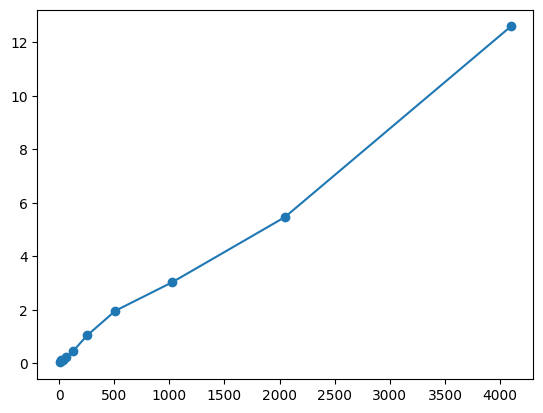

In [106]:
plt.plot(2**np.arange(3, 13), t, marker='o')


In [121]:
t0 = np.load('../scripts/tmp/timings-2.npy')
t1 = np.load('../scripts/tmp/timings_fullcov-2.npy')

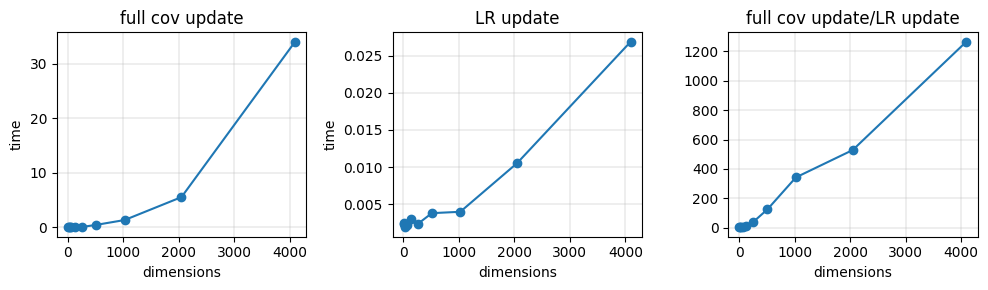

In [143]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

ax[0].plot(*t1, marker='o')
ax[1].plot(*t0, marker='o')
ax[2].plot(t0[0], t1[1]/t0[1], marker='o')

ax[0].set_title('full cov update')
ax[1].set_title('LR update')
ax[2].set_title('full cov update/LR update')
for axis in ax[:2]: 
    # axis.loglog()
    axis.set_ylabel('time')
for axis in ax:
    axis.set_xlabel('dimensions')
    axis.grid(which='both', lw=0.3)
# plt.suptitle(f'Batch={batch_size}, Rank={ranklr}')
plt.tight_layout()
 


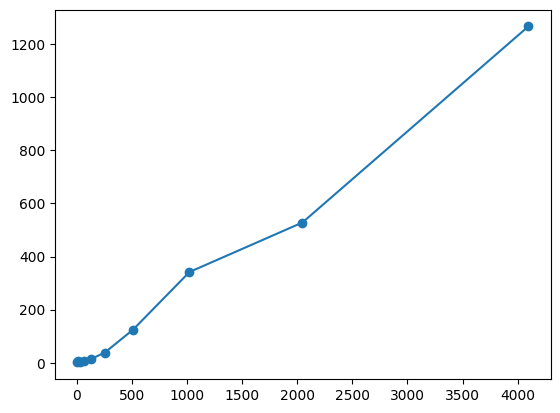

# vs bbvi

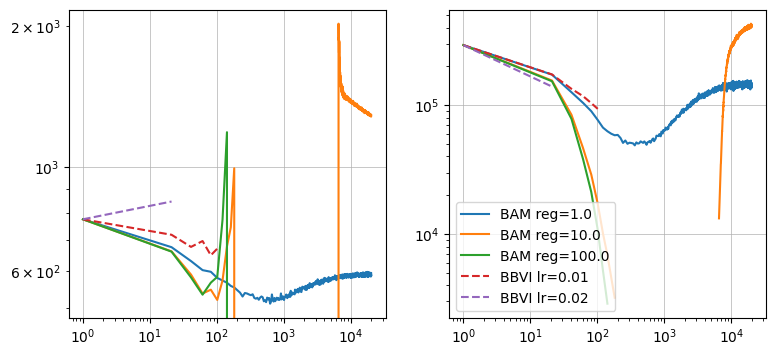

In [170]:
D = 256


fig, ax = plt.subplots(1, 2, figsize=(9, 4))

for reg in [1., 10., 100.]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BAM reg={reg:0.1f}')
        ax[1].plot(g, fkl, label=f'BAM reg={reg:0.1f}')
    except Exception as e:
        print(e)

# for _ in [1]:
#     try:
#         g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/nevals.npy')
#         rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/rkl.npy')
#         fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/fkl.npy')
#         ax[0].plot(g, rkl, label='GSM')
#         ax[1].plot(g, fkl, label='GSM')
#     except Exception as e:
#         print(e)

for lr in [0.01, 0.02]:
# for lr in [0.01, 0.02, 0.05, 0.1]:
    try: 
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BBVI lr={lr:0.2f}', ls="--")
        ax[1].plot(g, fkl, label=f'BBVI lr={lr:0.2f}', ls="--")
    except Exception as e:
        print(e)
    
for axis in ax:
    axis.loglog()
    axis.grid(lw=0.5)
plt.legend()

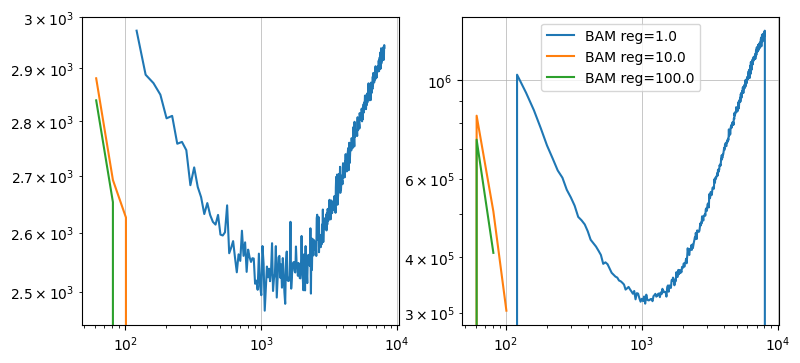

In [144]:
D = 1024


fig, ax = plt.subplots(1, 2, figsize=(9, 4))

for reg in [1., 10., 100.]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BAM reg={reg:0.1f}')
        ax[1].plot(g, fkl, label=f'BAM reg={reg:0.1f}')
    except Exception as e:
        print(e)

# for _ in [1]:
#     try:
#         g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/nevals.npy')
#         rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/rkl.npy')
#         fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/fkl.npy')
#         ax[0].plot(g, rkl, label='GSM')
#         ax[1].plot(g, fkl, label='GSM')
#     except Exception as e:
#         print(e)

# for lr in [0.01, 0.02]:
# # for lr in [0.01, 0.02, 0.05, 0.1]:
#     try: 
#         g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/nevals.npy')
#         rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/rkl.npy')
#         fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/padvi/B2-lr{lr:0.3f}/fkl.npy')
#         ax[0].plot(g, rkl, label=f'BBVI lr={lr:0.2f}', ls="--")
#         ax[1].plot(g, fkl, label=f'BBVI lr={lr:0.2f}', ls="--")
#     except Exception as e:
#         print(e)
    
for axis in ax:
    axis.loglog()
    axis.grid(lw=0.5)
plt.legend()

In [146]:
np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg{reg:0.2f}/mean_fit.npy')

array([-1.76041198e+37,  8.14202273e+37,  1.44470695e+38, ...,
       -1.58287104e+37,  2.38129681e+36, -3.88701222e+37])

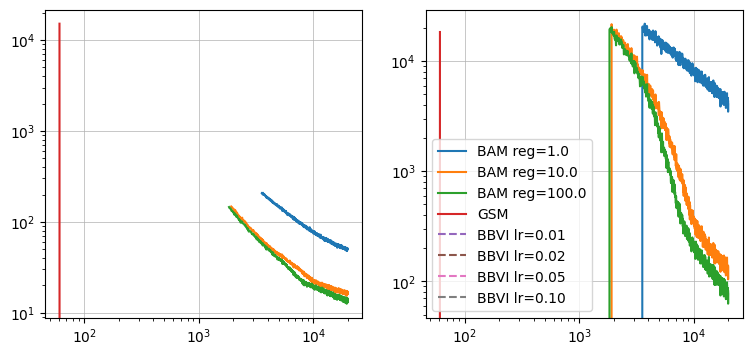

In [186]:
D = 2048

fig, ax = plt.subplots(1, 2, figsize=(9, 4))

for reg in [1., 10., 100.]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg{reg:0.2f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg{reg:0.2f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg{reg:0.2f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BAM reg={reg:0.1f}')
        ax[1].plot(g, fkl, label=f'BAM reg={reg:0.1f}')
    except Exception as e:
        print(e)

for _ in [1]:
    try:
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/fkl.npy')
        ax[0].plot(g, rkl, label='GSM')
        ax[1].plot(g, fkl, label='GSM')
    except Exception as e:
        print(e)

for lr in [0.01, 0.02, 0.05, 0.1]:
    try: 
        g = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/padvi/B2-lr{lr:0.3f}/nevals.npy')
        rkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/padvi/B2-lr{lr:0.3f}/rkl.npy')
        fkl = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/padvi/B2-lr{lr:0.3f}/fkl.npy')
        ax[0].plot(g, rkl, label=f'BBVI lr={lr:0.2f}', ls="--")
        ax[1].plot(g, fkl, label=f'BBVI lr={lr:0.2f}', ls="--")
    except Exception as e:
        print(e)
    
for axis in ax:
    axis.loglog()
    axis.grid(lw=0.5)
plt.legend()

[ 34  61 127  63   5 112   3]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


autodetected range of [nan, nan] is not finite


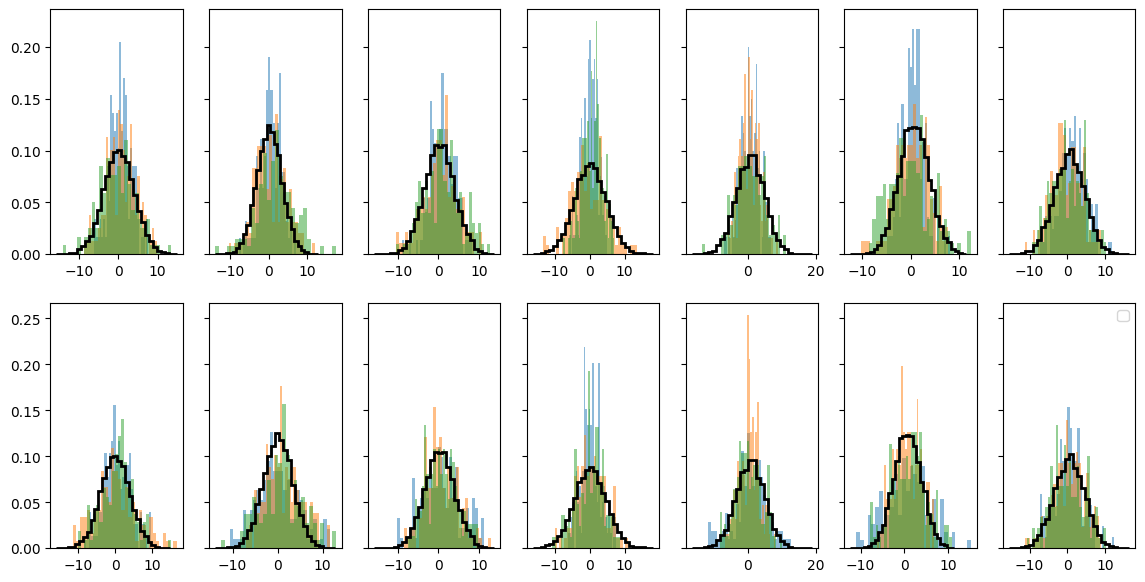

In [100]:
D = 128
K = 16
suffix = ''

meanref = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/mean.npy')
covref = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/cov.npy')
refs = np.random.multivariate_normal(meanref, covref, 10000).T

dplot = 7
idx = np.random.randint(0, D, dplot)
print(idx)

fig, ax = plt.subplots(2, dplot, figsize=(14, 7), sharex=False, sharey='row')

for i in range(dplot):
    ax[0, i].hist(refs[idx[i]], bins=30, histtype='step', lw=2, color='k', density=True)
for i in range(dplot):
    ax[1, i].hist(refs[idx[i]], bins=30, histtype='step', lw=2, color='k', density=True)

for reg in [1., 10., 100.]:
    try:
        mean = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg{reg:0.2f}/mean_fit.npy')
        psi = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg{reg:0.2f}/psi_fit.npy')
        llambda = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg{reg:0.2f}/llambda_fit.npy')
        eps = np.random.normal(0, 1, (10000, D))
        z = np.random.normal(0, 1, (10000, K))
        s = mean + psi*eps + (llambda@z.T).T
        for i in range(dplot):
            ax[0, i].hist(s[idx[i]], bins=30, alpha=0.5, density=True)
    except Exception as e:
        print(e)


# for _ in [1]:
#     try:
#         mean = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/mean_fit.npy')
#         psi = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/psi_fit.npy')
#         llambda = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pgsm/B2/llambda_fit.npy')
#         eps = np.random.normal(0, 1, (5000, D))
#         z = np.random.normal(0, 1, (5000, K))
#         s = mean + psi*eps + (llambda@z.T).T
#         for i in range(5):
#             ax[0, i].hist(s[idx[i]], bins=30, alpha=0.5, density=True)
#     except Exception as e:
#         print(e)


for lr in [0.01, 0.02, 0.05, 0.1]:
    try: 
        mean = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/padvi/B2-lr{lr:0.3f}/mean_fit.npy')
        psi = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/padvi/B2-lr{lr:0.3f}/psi_fit.npy')
        llambda = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/padvi/B2-lr{lr:0.3f}/llambda_fit.npy')
        eps = np.random.normal(0, 1, (10000, D))
        z = np.random.normal(0, 1, (10000, K))
        s = mean + psi*eps + (llambda@z.T).T
        for i in range(dplot):
            ax[1, i].hist(s[idx[i]], bins=30, alpha=0.5, density=True)
    except Exception as e:
        print(e)
    
# for axis in ax:
#     axis.loglog()
#     axis.grid(lw=0.5)
plt.legend()

0


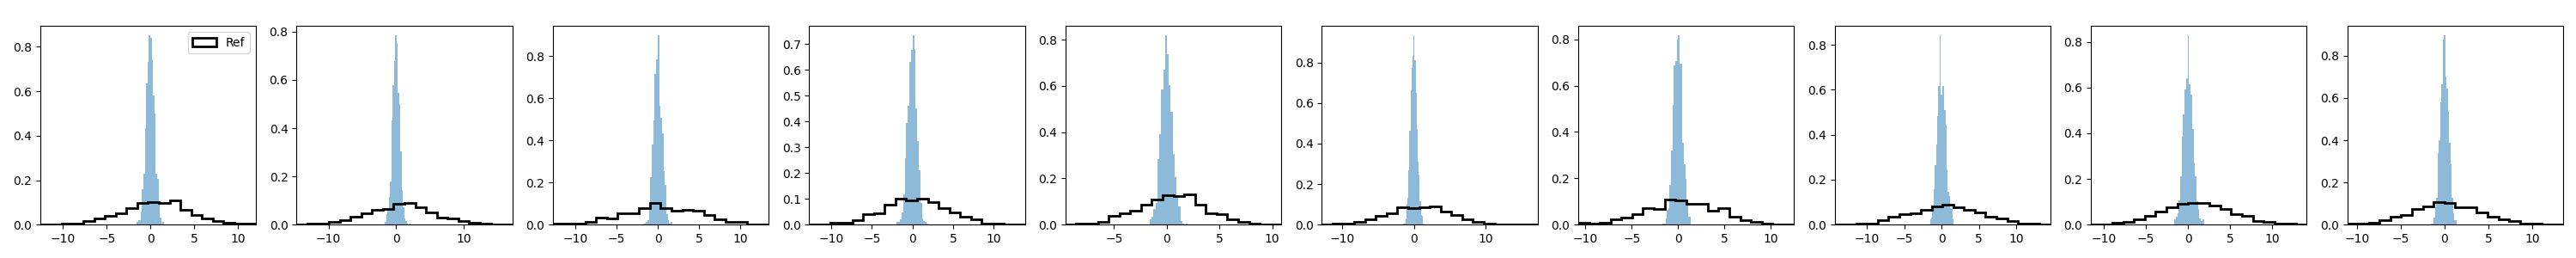

1000


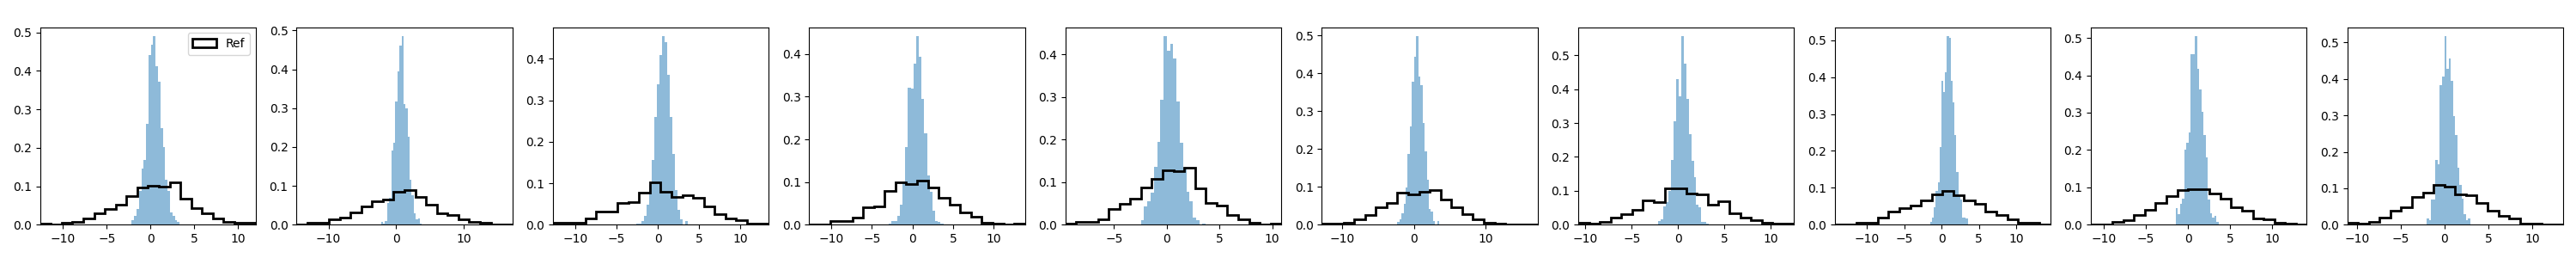

2000


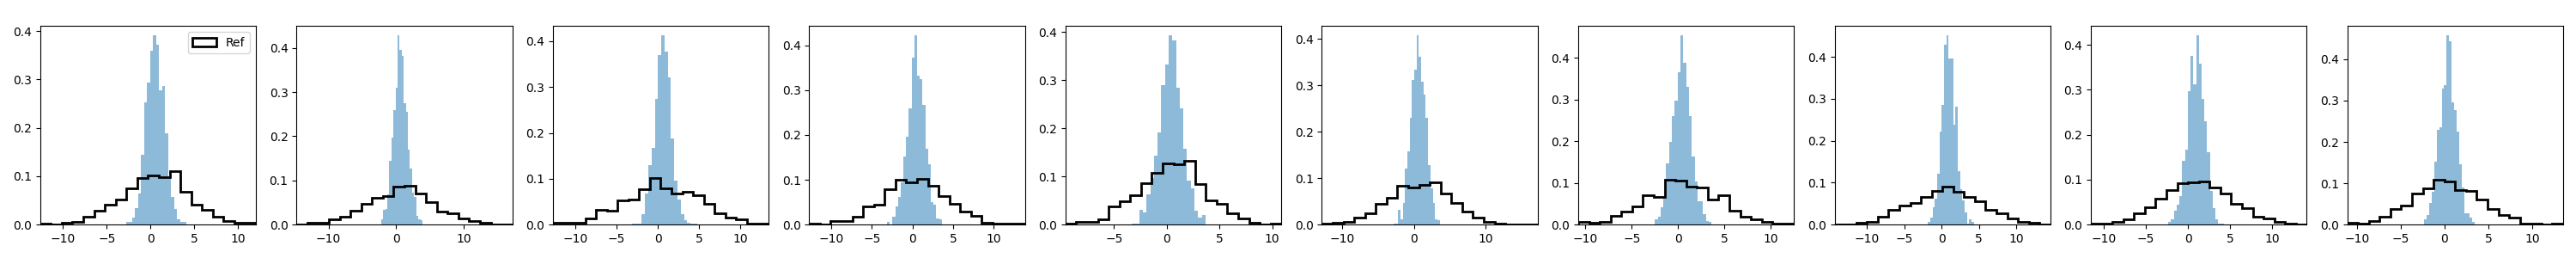

3000


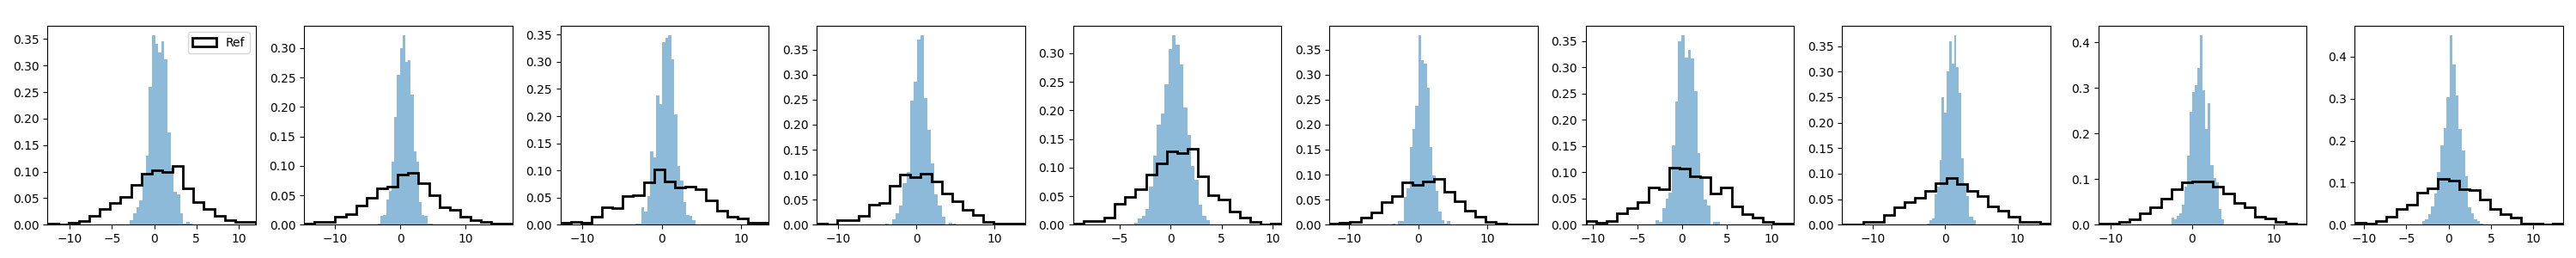

4000


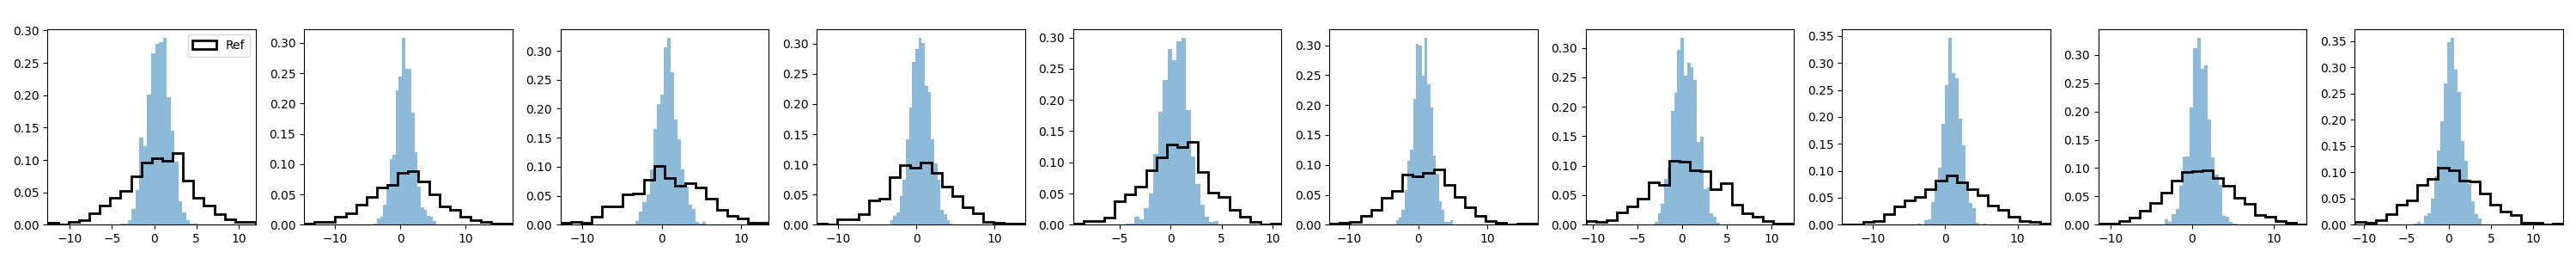

5000


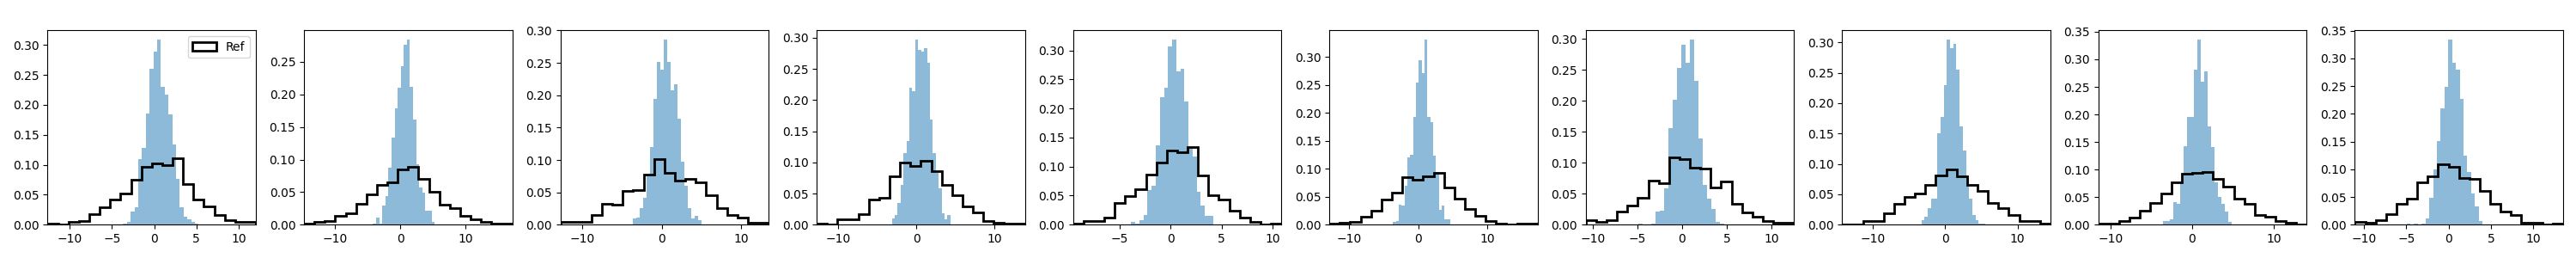

6000


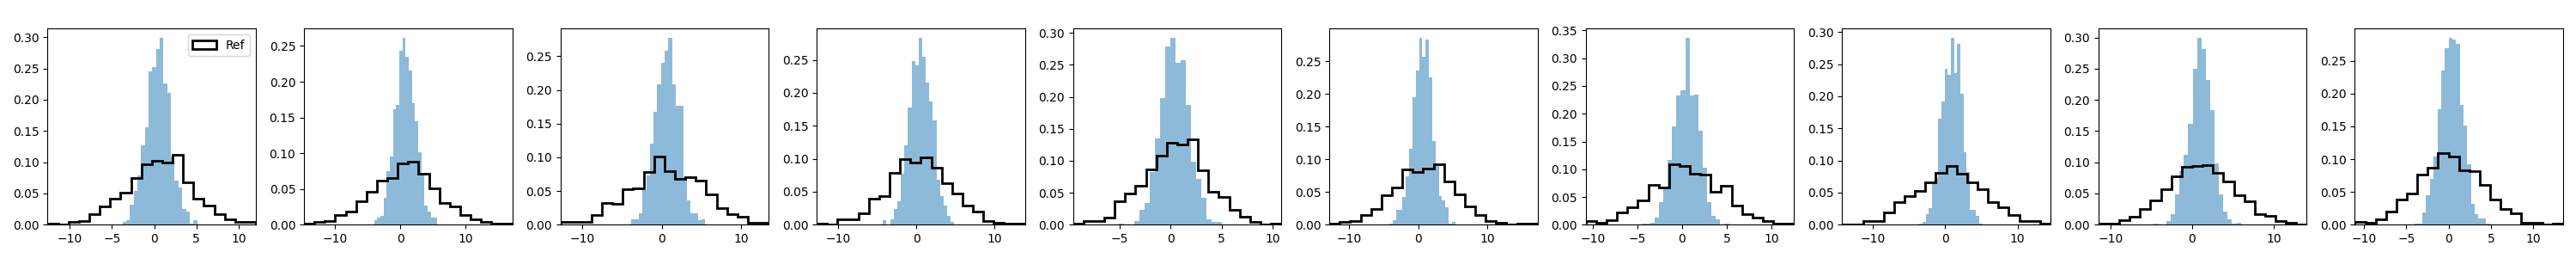

7000


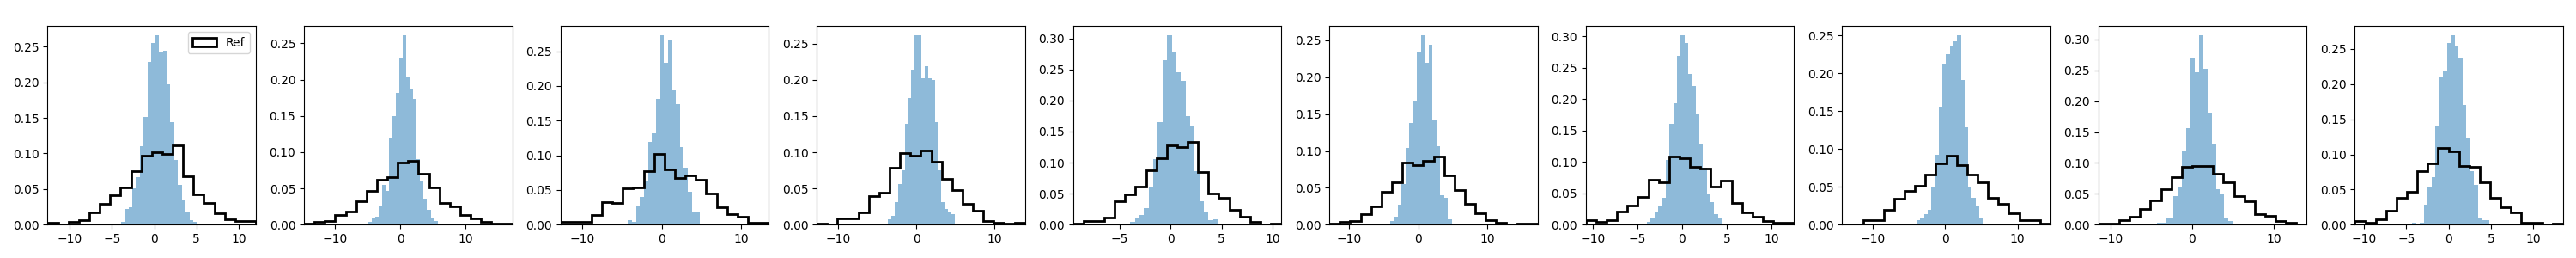

8000


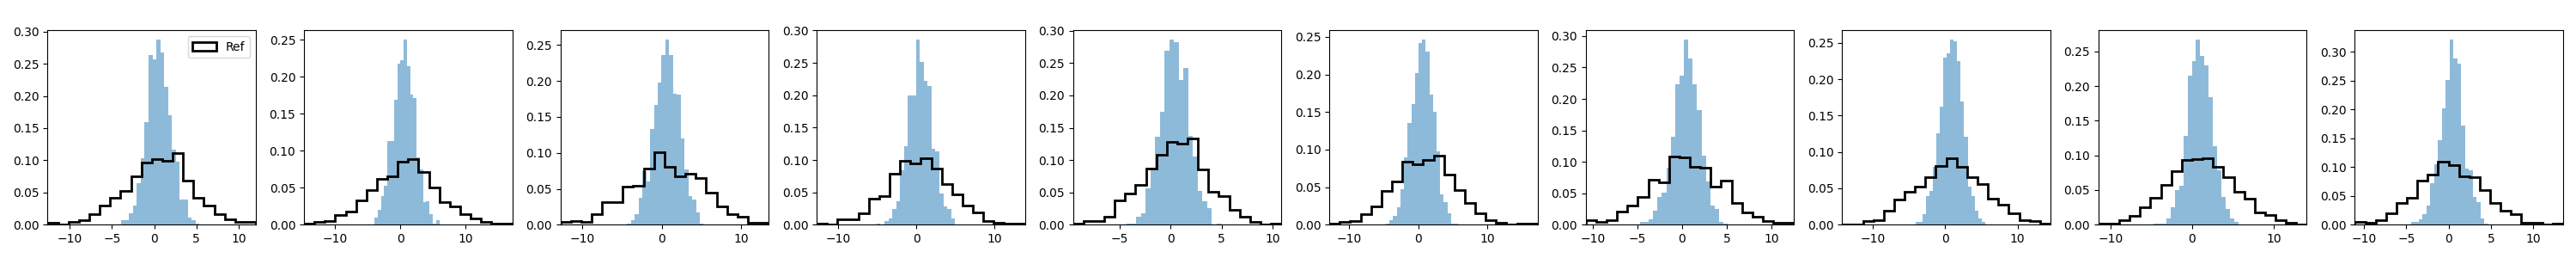

9000


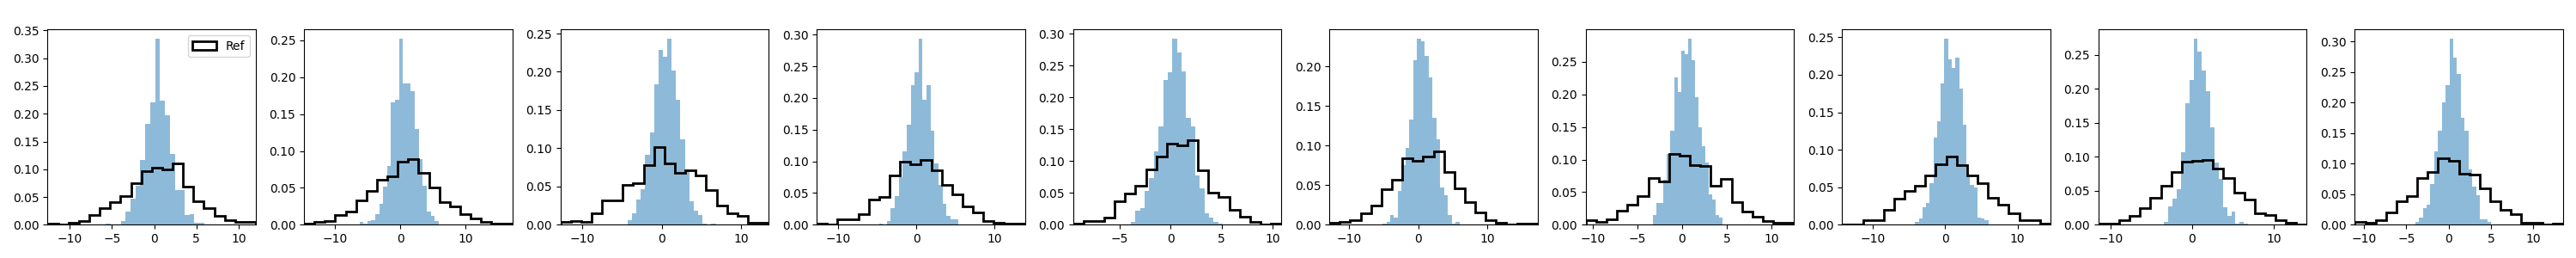

In [185]:
for i in range(0, 100, 10):
    print(i*100)
    display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D2048/R16-seed0/pbam/B2-reg100.00/hist{i*100}.png'))


(13, 2048)


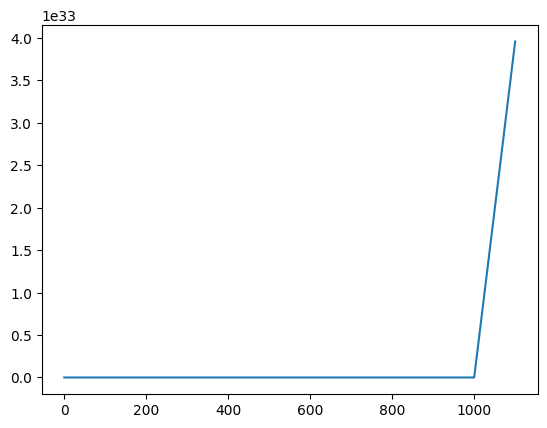

In [90]:
D = 2048
iparams = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/iparams.npy')
means = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/means.npy')
print(means.shape)
psis = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/psis.npy')
# psis = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg10.00/psis.npy')
plt.plot(iparams, psis[:-1, 0])
# llambdas = np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/llambdas.npy')
# plt.plot(llambdas[:, 0, 0])
# plt.loglog()

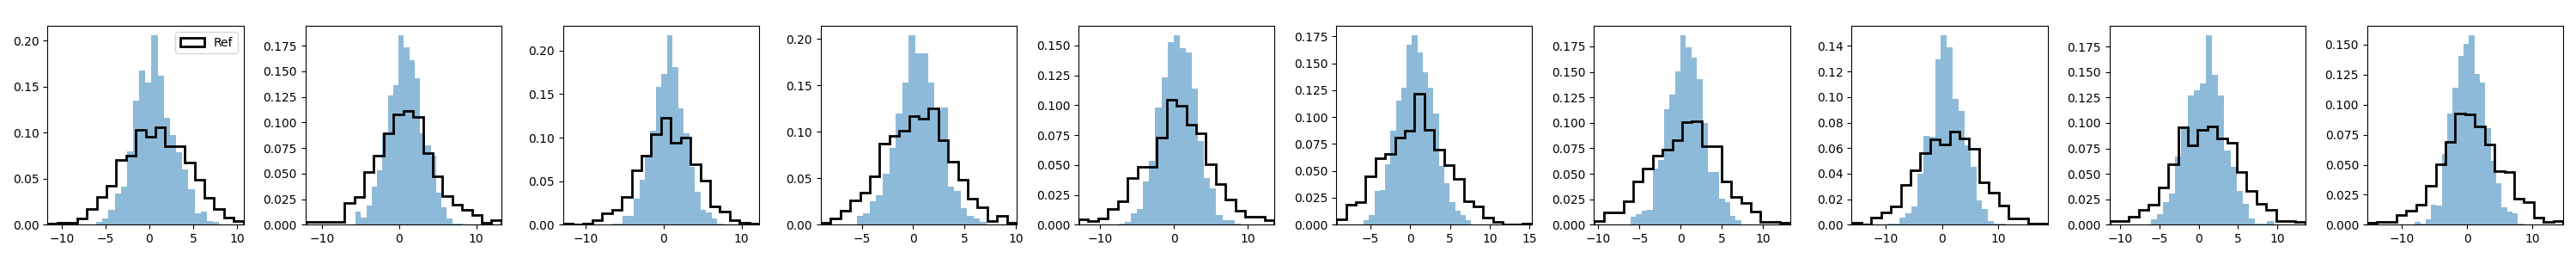

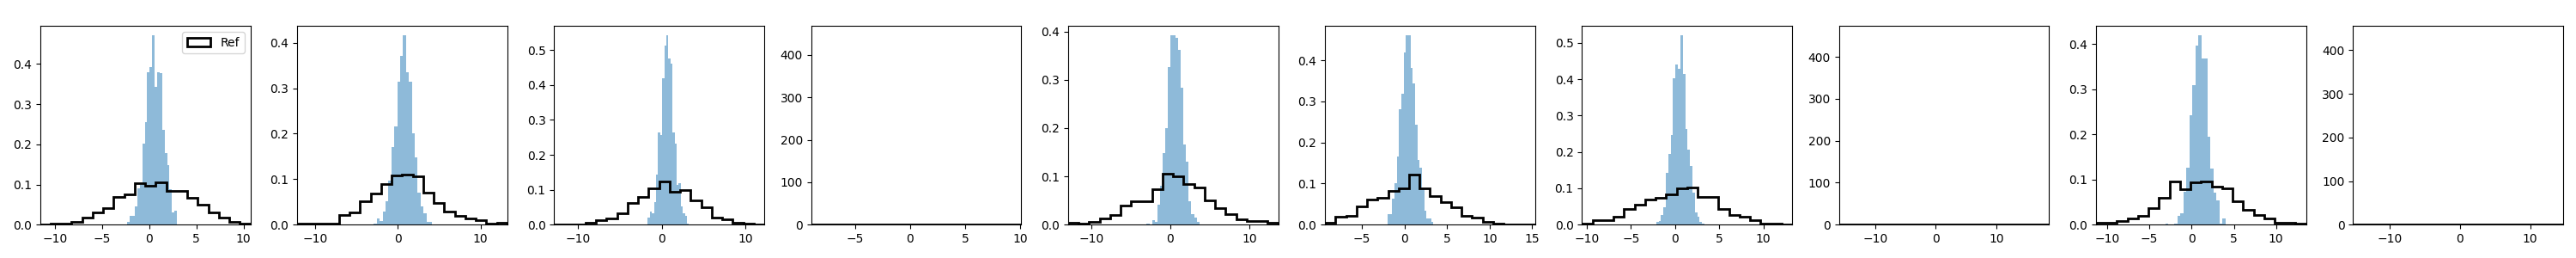

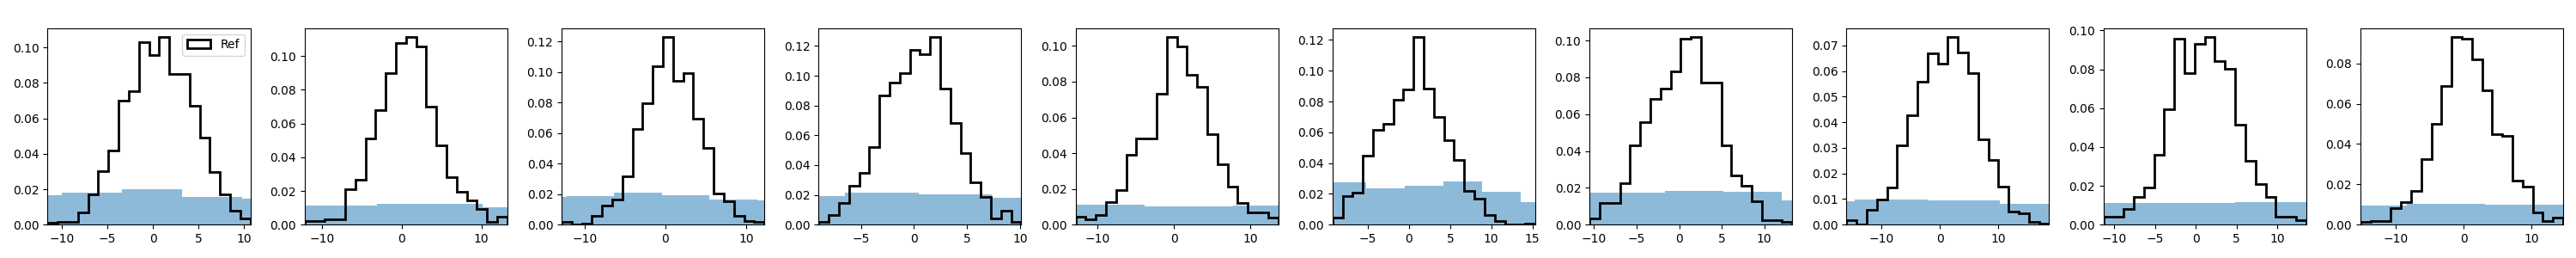

bad cond


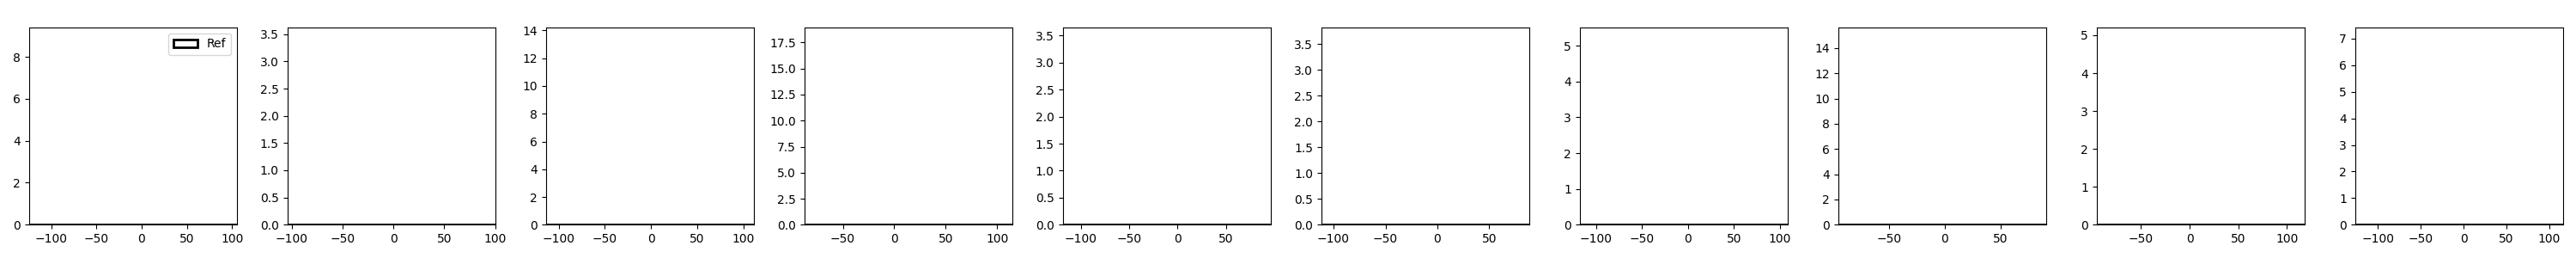

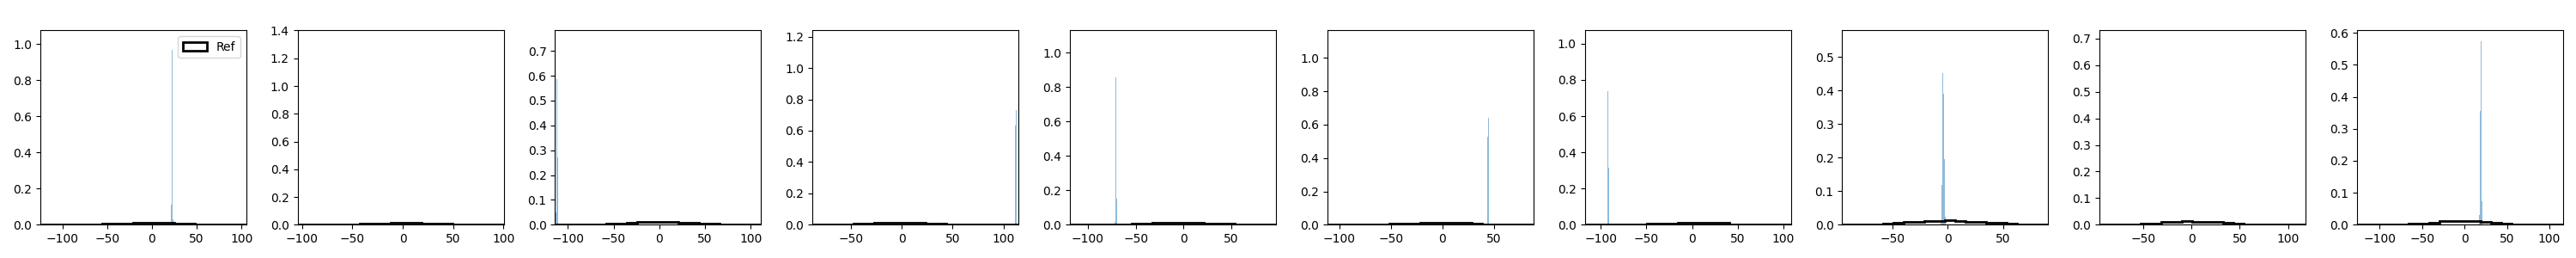

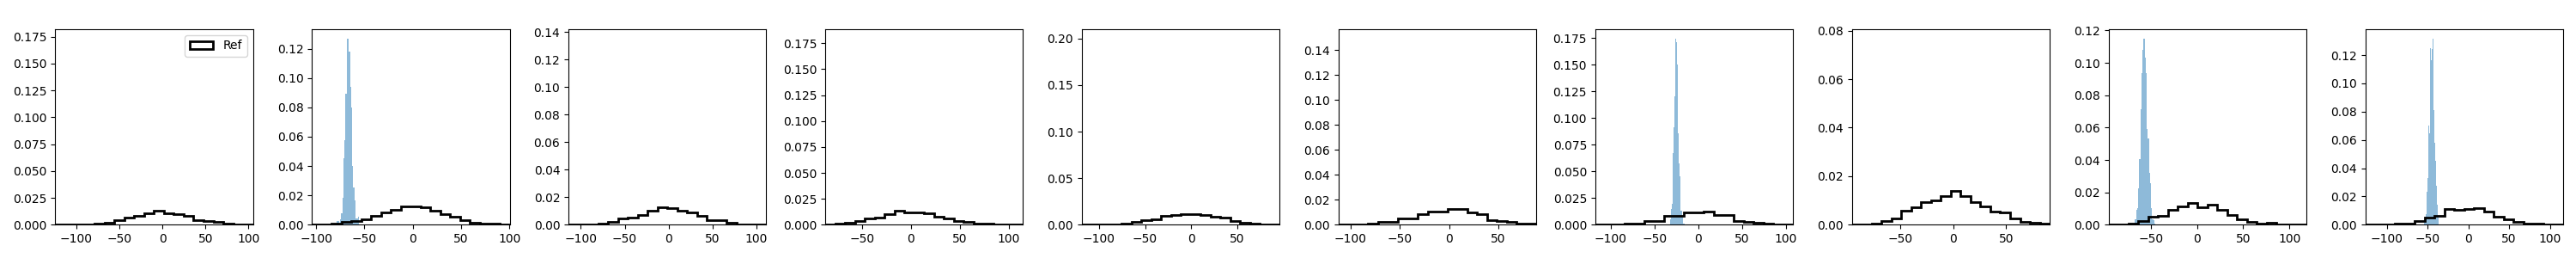

In [94]:
D=1024
suffix=''
niter=''
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset2/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset2/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset3/hist{niter}.png'))
print('bad cond')
suffix='-badcond'
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset2/hist{niter}.png'))
display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-reset2/hist{niter}.png'))
# display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}{suffix}/R16-seed0/pbam/B2-reg10.00-psireset3/hist{niter}.png'))


In [96]:
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D2014/R16-seed0/pbam/B2-reg1.00/rkl.png'))


FileNotFoundError: No such file or directory: '/mnt/ceph/users/cmodi/pbam/Gauss-D2014/R16-seed0/pbam/B2-reg1.00/rkl.png'

FileNotFoundError: No such file or directory: '/mnt/ceph/users/cmodi/pbam/Gauss-D2014/R16-seed0/pbam/B2-reg1.00/rkl.png'

<IPython.core.display.Image object>

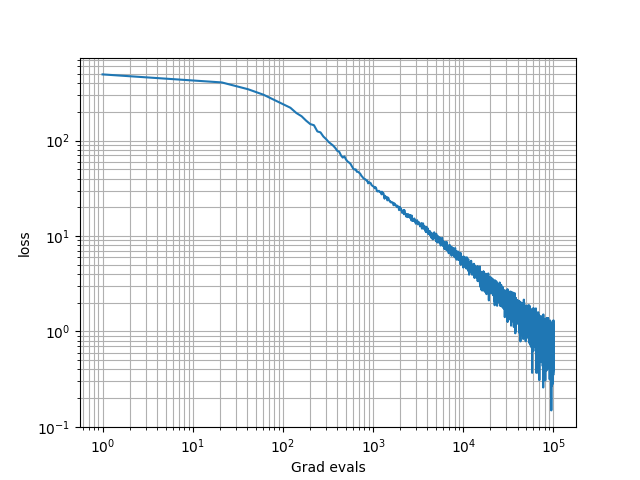

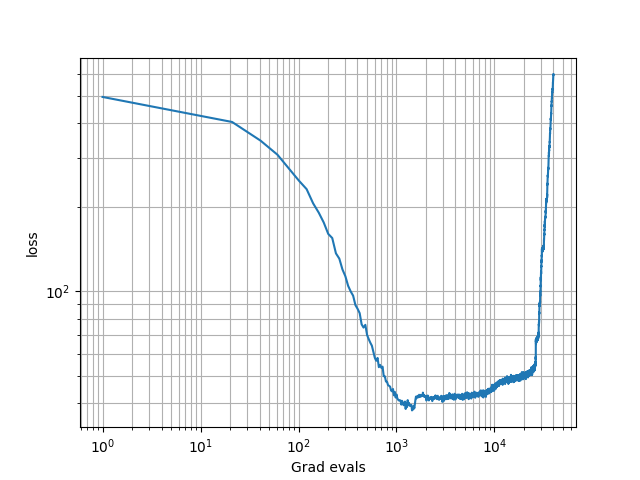

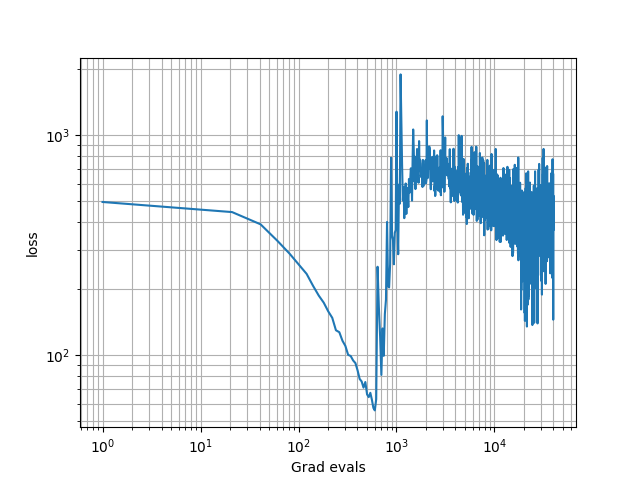

bad cond


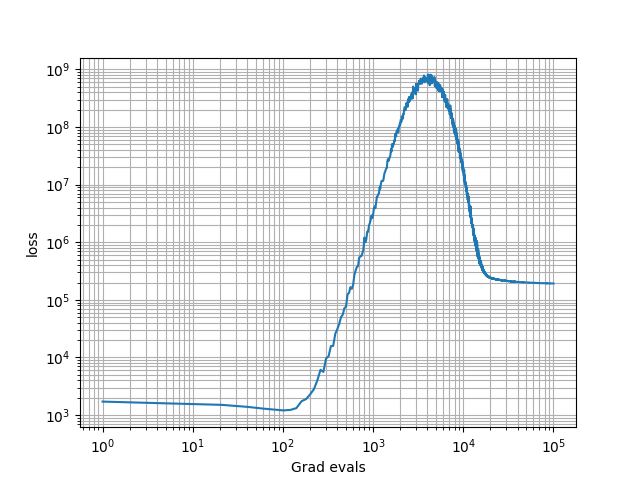

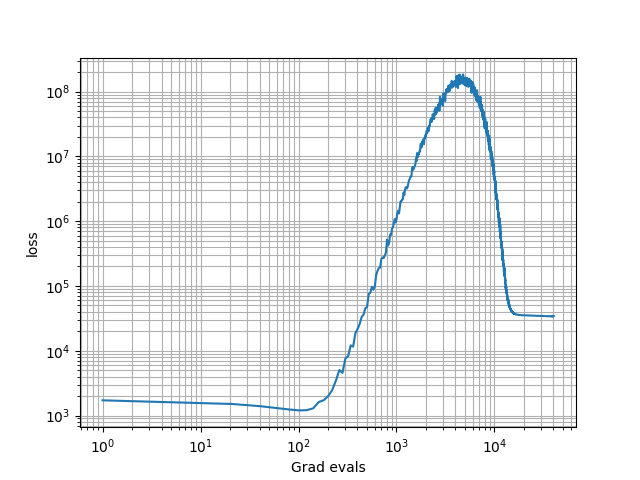

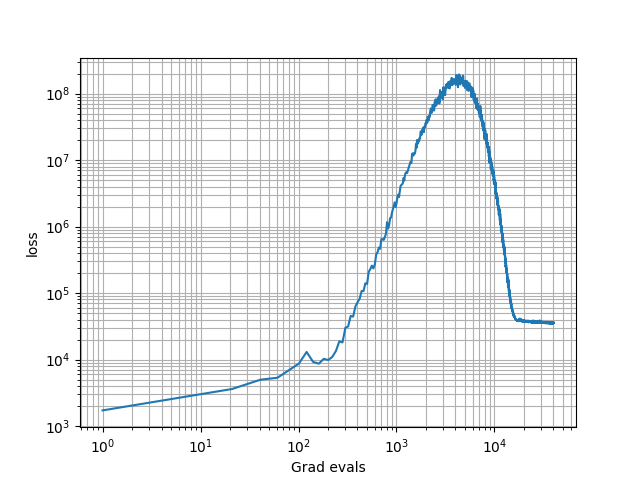

In [77]:
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-psireset/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-reset/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-llambdareset/rkl.png'))
print('bad cond')
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-psireset/rkl.png'))
display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-reset/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-llambdareset/rkl.png'))


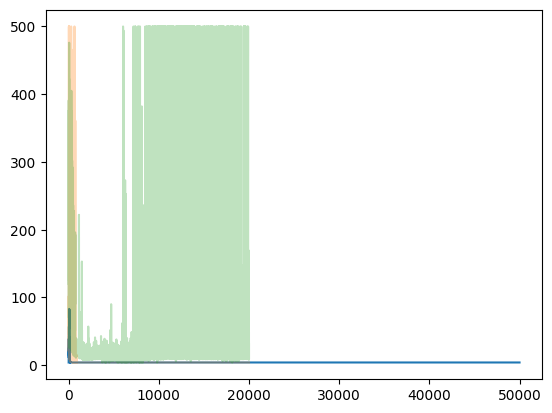

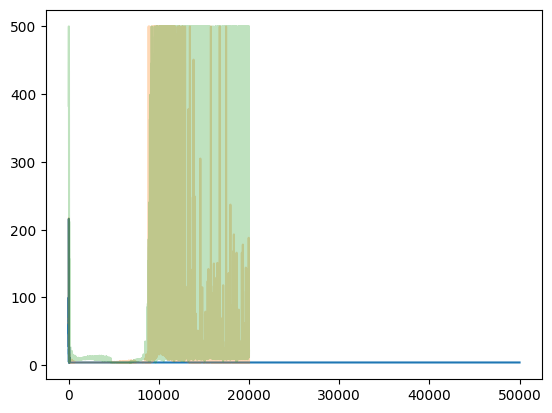

In [76]:
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00/nprojects.npy'))
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-psireset/nprojects.npy'), alpha=0.3)
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-reset/nprojects.npy'), alpha=0.3)
plt.show()
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00/nprojects.npy'))
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-psireset/nprojects.npy'), alpha=0.3)
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-reset/nprojects.npy'), alpha=0.3)


[]

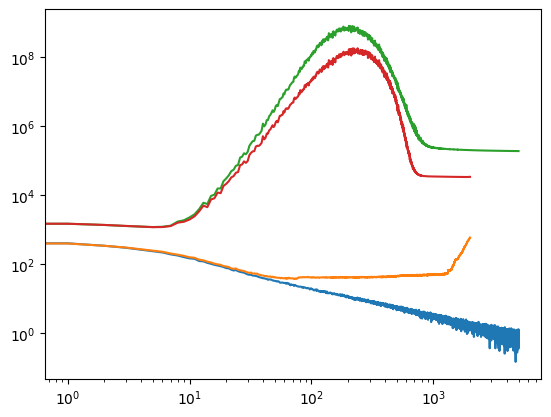

In [73]:
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00//rkl.npy'))
# plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512/R16-seed0/pbam/B2-reg10.00-psireset//rkl.npy'))
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00//rkl.npy'))
# plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond/R16-seed0/pbam/B2-reg10.00-psireset//rkl.npy'))
plt.loglog()
plt.xlabel('itera

[]

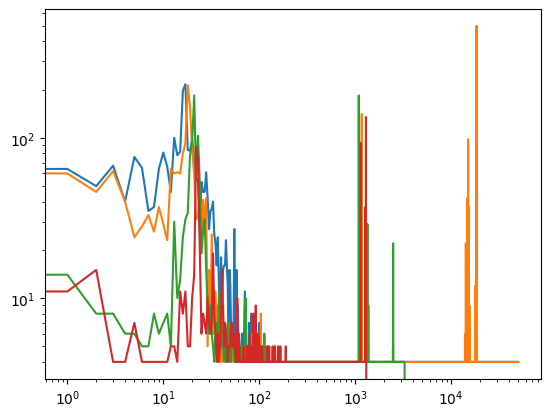

In [75]:
for D in [512, 1024, 2048, 4096]:
    plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00//nprojects.npy'))
plt.loglog()

[]

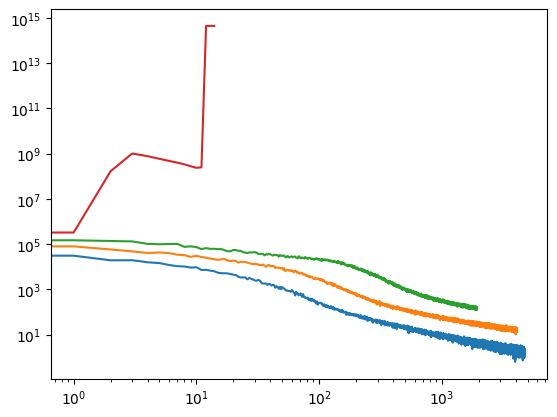

In [100]:
for D in [512, 1024, 2048, 4096]:
    plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}/R16-seed0/pbam/B2-reg10.00//fkl.npy'))
    # plt.plot(np.load(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg10.00/rkl.npy'))
plt.loglog()

512


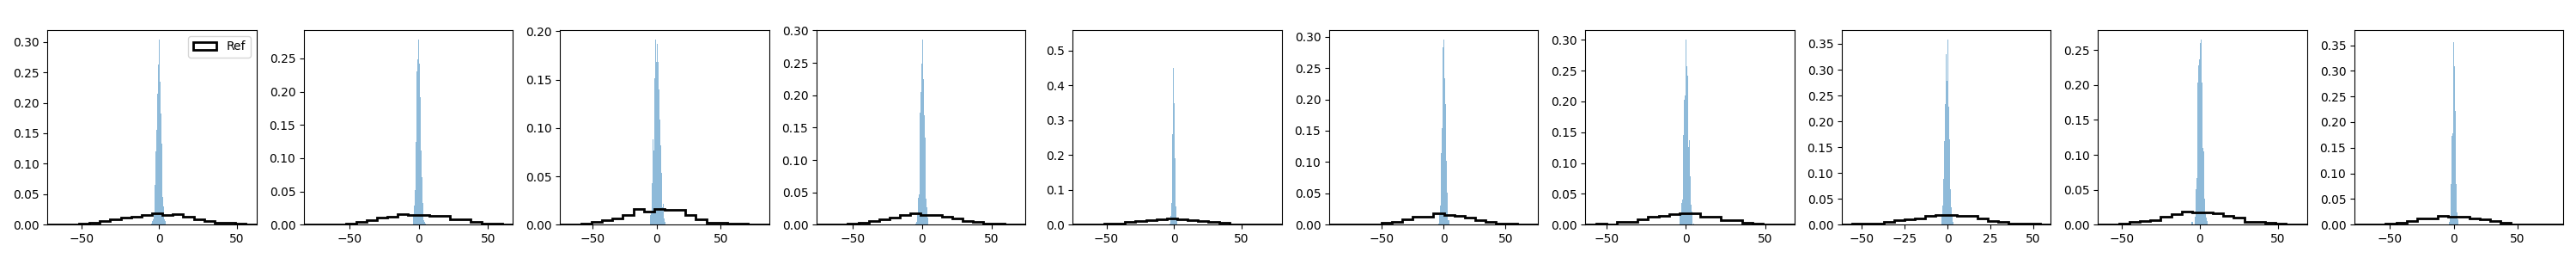

1024


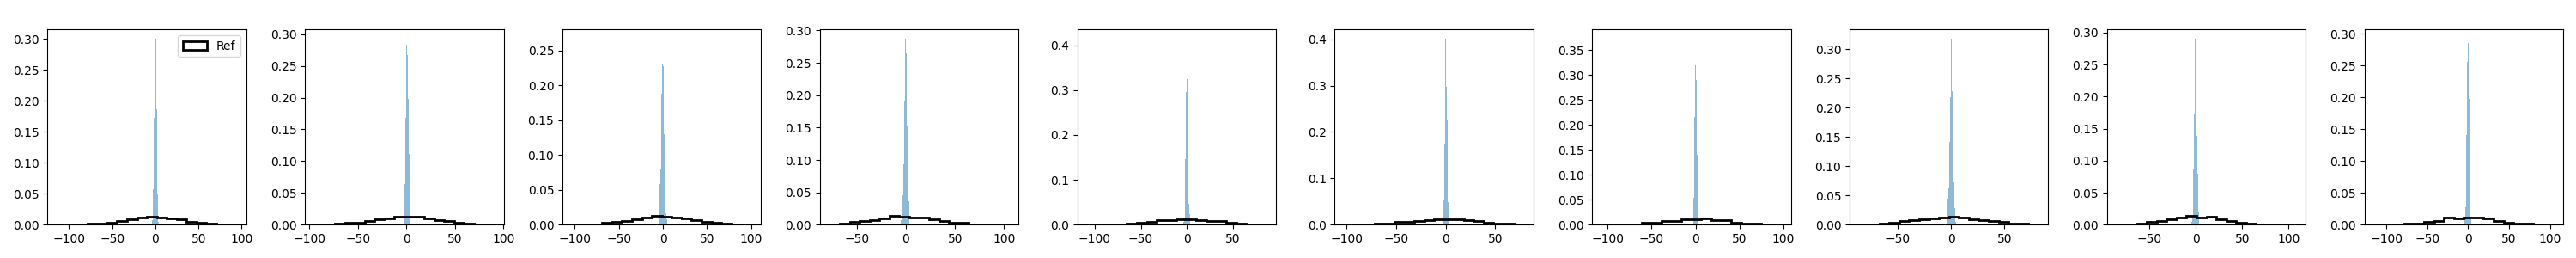

2048


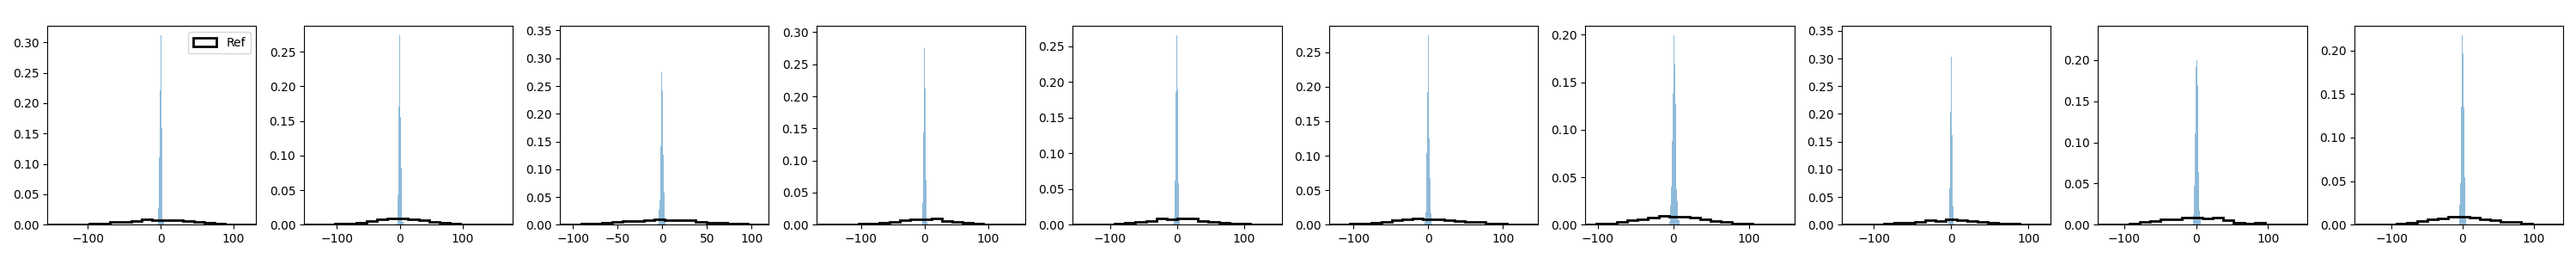

4096


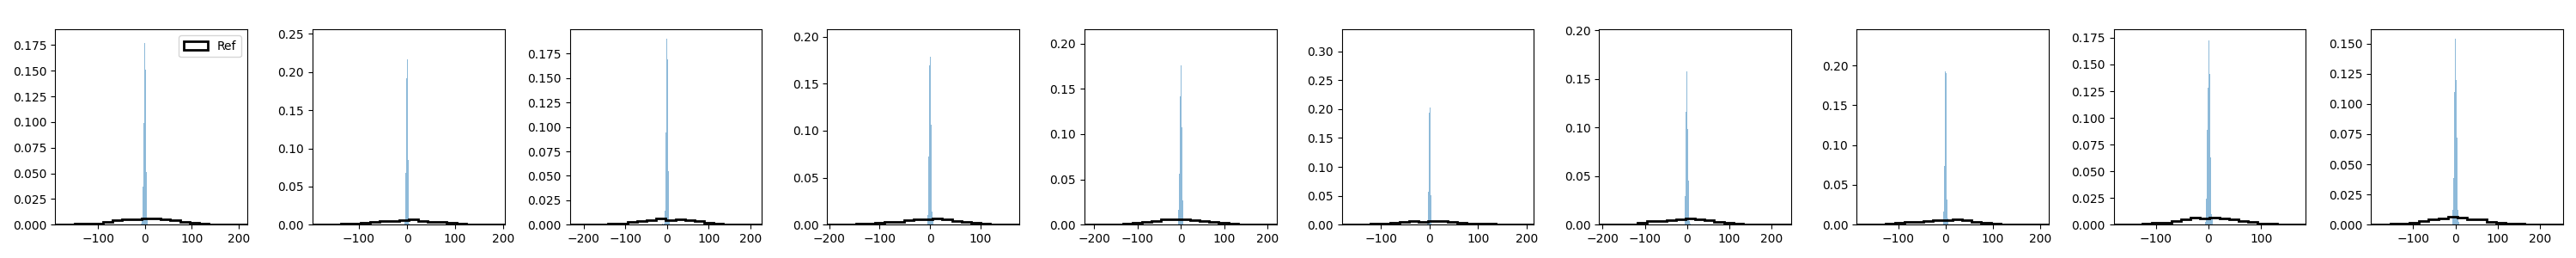

8192


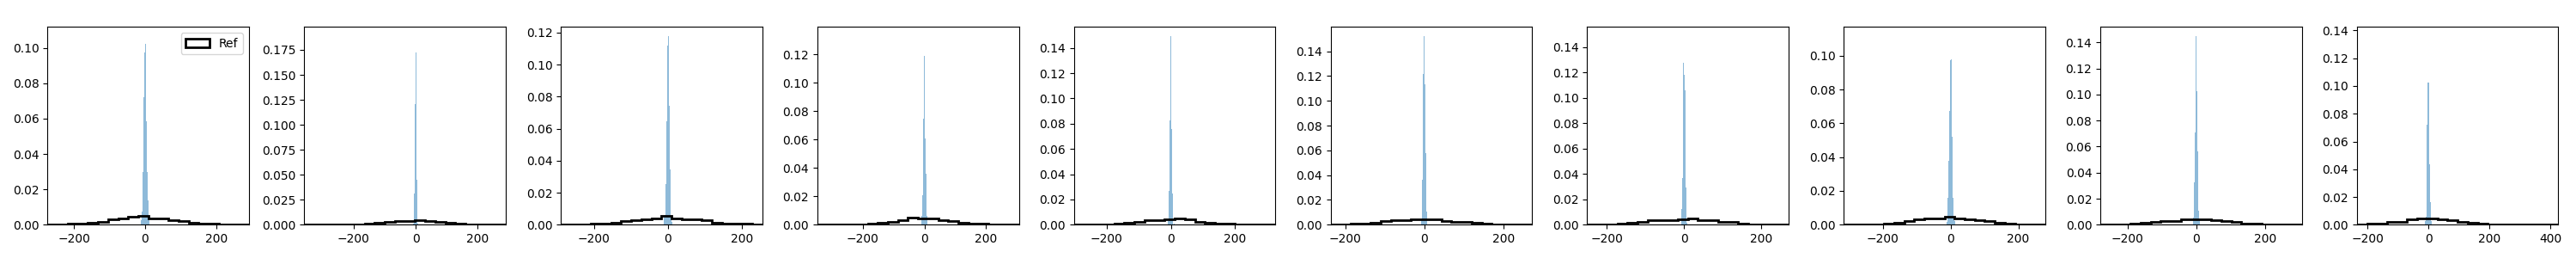

In [72]:
for D in [512, 1024, 2048, 4096, 8192]:
    print(D)
    display(Image(f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-badcond/R16-seed0/pbam/B2-reg1.00/hist6000.png'))


[]

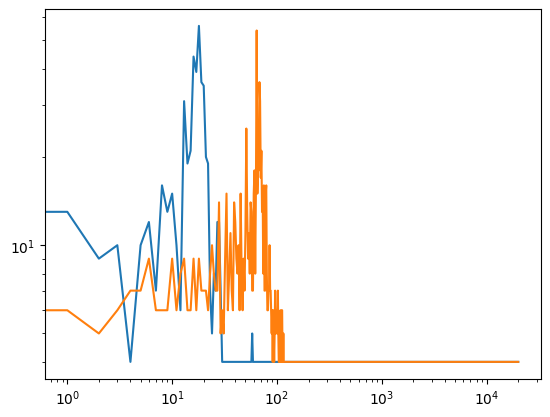

In [22]:
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512-badcond//R16-seed0/pbam/B2-reg10.00//nprojects.npy'))
plt.loglog()
plt.plot(np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D512//R16-seed0/pbam/B2-reg10.00//nprojects.npy'))
plt.loglog()

# padvi

In [24]:
from gsmvi.bbvi import ADVI_LR, ADVI_Factorized
from gsmvi.pbam_test import PBAM as PBAM_Test

In [35]:
D = 512

rank = 32
# model, mean, cov, lp, lp_g, ref_samples = setup_okay_model_D(D, rank)
# model, mean, cov, lp, lp_g, ref_samples = setup_okay_model_rank(D, rank)
model, mean, cov, lp, lp_g, ref_samples = setup_model_nonorm(D, rank)
# model, mean, cov, lp, lp_g, ref_samples = setup_good_model(D, rank)
# model, mean, cov, lp, lp_g, ref_samples = setup_model(D, rank)
# mean, cov, lp, lp_g, ref_samples = setup_gauss_model(D, rank=rank)

lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


eigs = np.linalg.eigvalsh(cov)
eigs.max()/eigs.min()

54717.81551139953

In [20]:
# start = time()

# ranklr = rank
# batch_size = 8
# niter = 100
# nprint = 10

# algbam = GSM(D, lp_vmap, lp_g_vmap)
# key = jax.random.PRNGKey(2)
# regf = lambda x: 10/(1+x)**0.5
# psi_init = np.random.random(D)*1
# llambda_init = np.random.random((D, K))/(D*K)**0.5
# covinit = None #np.eye(D)*0.1
# monitorbam = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
# meanfit, covfit = algbam.fit(key, cov=covinit, batch_size=batch_size, niter=niter, nprint=nprint, 
#                                  monitor=monitorbam)
# # meanfit, covfit = algbam.fit(key, cov=covinit, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, 
# #                                  monitor=monitorbam)
# print("time taken : ", time() - start)

In [21]:
from time import time

In [37]:
start = time()

ranklr = rank
batch_size = 8
niter = 2000
nprint = 10

alg = PBAM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)
regf = lambda x: 10/(1+x)**0.5
psi_init = np.random.random(D)*1
llambda_init = np.random.random((D, ranklr))/(D)**0.5

monitor = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfit, psi, llambda = alg.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, 
                                  psi=psi_init, llambda=llambda_init,
                                  tolerance=1e-4, eta=1.2, niter_em=501, 
                                  updateform='lawrence',
                                  updatemode='llambda0',
                                  print_convergence=False, monitor=monitor)
covfit = np.diag(psi) + llambda@llambda.T
print("time taken : ", time() - start)

Iteration 0 of 2000. Time taken :  2.6226043701171875e-06
compiled
time for first 10 iterations :  0.4743473529815674
Iteration 200 of 2000. Time taken :  5.5081260204315186
Iteration 400 of 2000. Time taken :  11.329530954360962
Iteration 600 of 2000. Time taken :  17.262169361114502
Iteration 800 of 2000. Time taken :  23.08908462524414
Iteration 1000 of 2000. Time taken :  28.913951635360718
Iteration 1200 of 2000. Time taken :  34.73447608947754
Iteration 1400 of 2000. Time taken :  40.958824634552
Iteration 1600 of 2000. Time taken :  47.175750494003296
Iteration 1800 of 2000. Time taken :  53.390257358551025
Iteration 2000 of 2000. Time taken :  59.640016078948975
Total number of projections :  12688 6.344
time taken :  59.81552982330322


In [38]:
start = time()

alg2 = PBAM_Test(D, lp_vmap, lp_g_vmap)
# alg2 = PGSM(D, lp_vmap, lp_g_vmap)
key = jax.random.PRNGKey(2)

monitor2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfit2, psi2, llambda2 = alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, 
# meanfit2, psi2, llambda2 = alg2.fit(key, rank=ranklr, batch_size=batch_size, niter=niter, nprint=nprint, 
                                  psi=psi_init, llambda=llambda_init,
                                  tolerance=1e-4, eta=1.2, niter_em=501, 
                                  print_convergence=False, monitor=monitor2)
covfit2 = np.diag(psi2) + llambda2@llambda2.T
print("time taken : ", time() - start)

jit compile True True
Iteration 0 of 2000. Time taken :  3.814697265625e-06
compiled
time for first 10 iterations :  0.44985151290893555
Iteration 200 of 2000. Time taken :  2.9829115867614746
Iteration 400 of 2000. Time taken :  5.502565383911133
Iteration 600 of 2000. Time taken :  8.02633786201477
Iteration 800 of 2000. Time taken :  10.547897100448608
Iteration 1000 of 2000. Time taken :  13.083603858947754
Iteration 1200 of 2000. Time taken :  15.603309154510498
Iteration 1400 of 2000. Time taken :  18.132867574691772
Iteration 1600 of 2000. Time taken :  20.652055025100708
Iteration 1800 of 2000. Time taken :  23.193607330322266
Iteration 2000 of 2000. Time taken :  25.714706897735596
Total number of projections :  6281 3.1405
time taken :  25.87211275100708


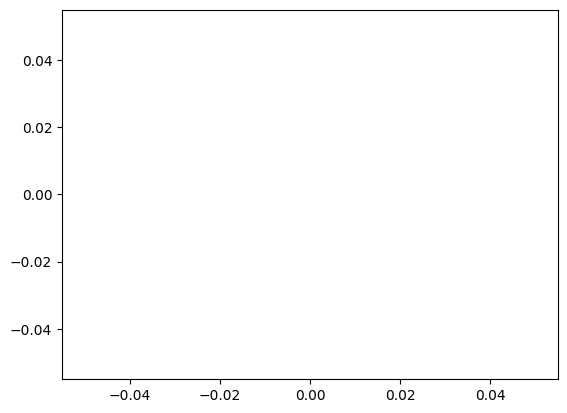

In [49]:
plt.plot(monitor2.kl_updates)

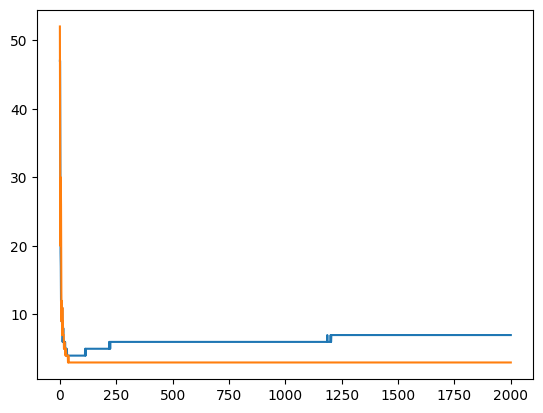

In [40]:
# i = 13
# plt.hist(ref_samples[:, i], density=True, alpha=0.5)
# plt.hist(np.random.multivariate_normal(meanfit3, covfit3, 1000)[:, i], density=True, alpha=0.5);
plt.plot(monitor.nprojects)
plt.plot(monitor2.nprojects)

In [41]:
start = time()
# niter=1000
# batch_size = 8
lr = 0.02

alg = ADVI_LR(D, ranklr, lp_vmap, jit_compile=True)
opt = optax.adam(learning_rate=lr)
monitorbbvi = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfitbbvi, psibbvi, llambdabbvi, losses = alg.fit(key, opt=opt, psi=psi_init, llambda=llambda_init,
                                            batch_size=batch_size, niter=niter, monitor=monitorbbvi, nprint=nprint)
covfitbbvi = np.diag(psibbvi) + llambdabbvi@llambdabbvi.T
print("time taken : ", time() - start)



jit compile True True
Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000
Iteration 2000 of 2000
time taken :  7.903913974761963


In [42]:
start = time()
# niter=1000
# batch_size = 8
# lr = 0.05

alg = ADVI_LR(D, ranklr, lp_vmap, jit_compile=True)
schedule = optax.schedules.linear_schedule(lr, 1e-5, niter)
opt = optax.adam(learning_rate=schedule)
monitorbbvi2 = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfitbbvi2, psibbvi2, llambdabbvi2, losses2 = alg.fit(key, opt=opt, psi=psi_init, llambda=llambda_init,
                                            batch_size=batch_size, niter=niter, monitor=monitorbbvi2, nprint=nprint)
covfitbbvi2 = np.diag(psibbvi2) + llambdabbvi2@llambdabbvi2.T
print("time taken : ", time() - start)



jit compile True True
Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000
Iteration 2000 of 2000
time taken :  7.8816468715667725


In [43]:
start = time()

algfac = ADVI_Factorized(D,  lp_vmap, jit_compile=True)
schedule = optax.schedules.linear_schedule(lr, 1e-5, niter)
opt = optax.adam(learning_rate=schedule)
# monitorfac = None
# meanfitfac, scalefac,  lossesfac = alg.fit(key, opt=opt, scale=psi_init, 
#                                             batch_size=batch_size, niter=niter, monitor=monitorfac, nprint=nprint)
monitorfac = KLMonitor(batch_size=32, ref_samples=ref_samples, checkpoint=5)
meanfitfac, scalefac,  lossesfac = algfac.fit(key, opt=opt, scale=psi_init, 
                                            batch_size=batch_size, niter=niter, monitor=monitorfac, nprint=nprint)
covfitfac = np.diag(scalefac)
print("time taken : ", time() - start)



Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000
Iteration 2000 of 2000
time taken :  29.853309631347656


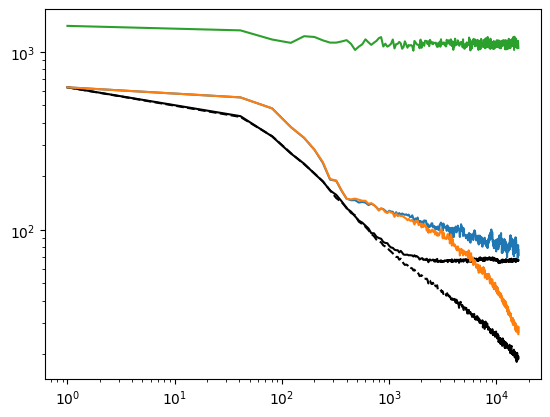

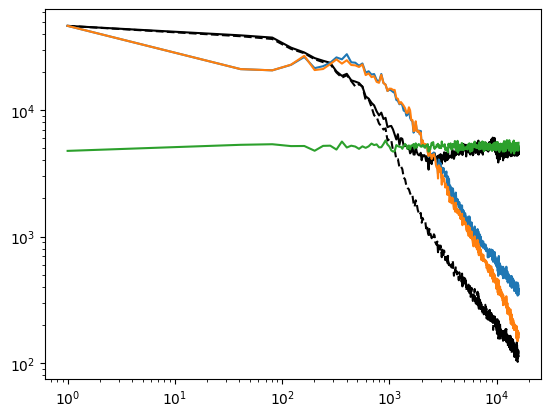

In [44]:
# plt.plot(monitorbam.nevals, monitorbam.rkl)
plt.plot(monitor.nevals, monitor.rkl, 'k')
plt.plot(monitor2.nevals, monitor2.rkl, 'k--')
plt.plot(monitorbbvi.nevals, monitorbbvi.rkl)
plt.plot(monitorbbvi2.nevals, monitorbbvi2.rkl)
plt.plot(monitorfac.nevals, monitorfac.rkl)
plt.loglog()
plt.show()
# plt.plot(monitorbam.nevals, monitorbam.fkl)
plt.plot(monitor.nevals, monitor.fkl, 'k')
plt.plot(monitor2.nevals, monitor2.fkl, 'k--')
plt.plot(monitorbbvi.nevals, monitorbbvi.fkl)
plt.plot(monitorbbvi2.nevals, monitorbbvi2.fkl)
plt.plot(monitorfac.nevals, monitorfac.fkl)
plt.loglog()
plt.show()

40


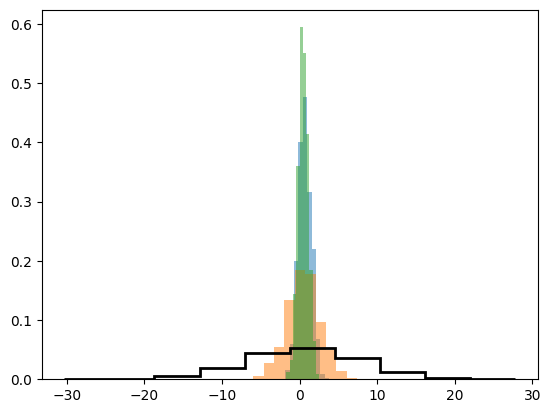

In [45]:
i = np.random.randint(D)
print(i)
plt.hist(ref_samples[:, i], density=True, alpha=1, histtype='step', lw=2, color='k')
plt.hist(np.random.multivariate_normal(meanfit, covfit, 1000)[:, i], density=True, alpha=0.5);
# plt.hist(np.random.multivariate_normal(meanfit2, covfit2, 1000)[:, i], density=True, alpha=0.5);
# plt.hist(np.random.multivariate_normal(meanfitbbvi, covfitbbvi, 1000)[:, i], density=True, alpha=0.5);
plt.hist(np.random.multivariate_normal(meanfitbbvi2, covfitbbvi2, 1000)[:, i], density=True, alpha=0.5);
plt.hist(np.random.multivariate_normal(meanfitfac, covfitfac, 1000)[:, i], density=True, alpha=0.5);


[502 370 312 176 167]


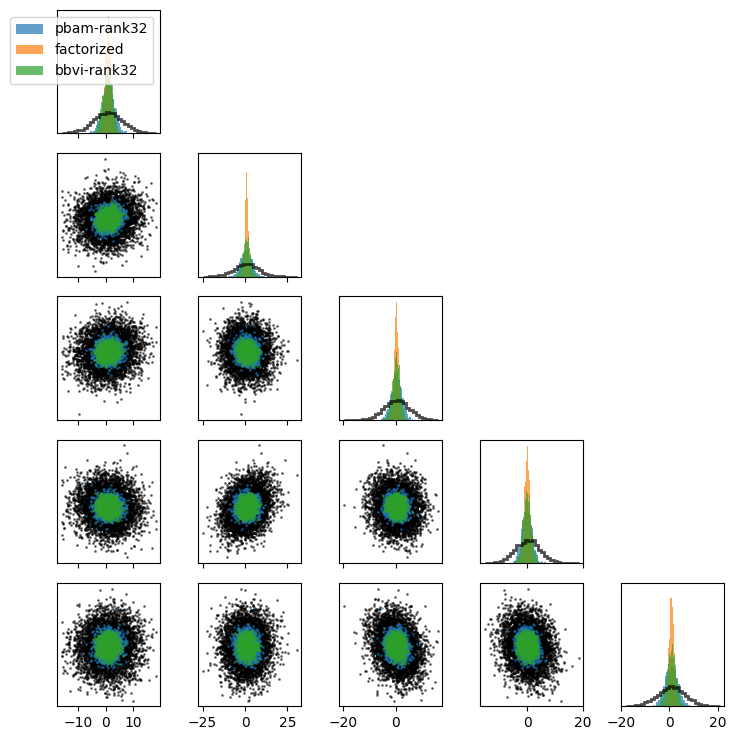

In [48]:
s = ref_samples[:5000, :] 
s1 = np.random.multivariate_normal(meanfit, covfit, 2000)
l1 = f'pbam-rank{ranklr}'
s2 = np.random.multivariate_normal(meanfitfac, covfitfac, 2000)
l2 = f'factorized'
# s2 = np.random.multivariate_normal(meanfit2, covfit2, 2000)
# l2 = f'pbamtest-rank{ranklr}'
s3 = np.random.multivariate_normal(meanfitbbvi2, covfitbbvi2, 2000)
l3 = f'bbvi-rank{ranklr}'
# s4 = np.random.multivariate_normal(meanfitbbvi, covfitbbvi, 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            if s1 is not None: ax[i, i].hist(s1[..., ii], alpha=0.7, density=True, bins=30, label=l1);
            if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=l2);
            if s3 is not None: ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=l3);
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=0.5, ms=2, color='k')
            if s1 is not None: ax[j, i].plot(s1[..., ii], s1[..., jj], '.', alpha=0.5, ms=2)
            if s2 is not None: ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
            if s3 is not None: ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend()
for axis in ax.flatten():
    axis.set_yticks([])
plt.tight_layout()


# load results

In [10]:
D = 1204
reg = 1.0
mode = 'current'
for form in ['diana', 'lawrence']:
    for mode in ['current', 'llambda0']:
        print(form, mode)  
        fname = f'//mnt/ceph/users/cmodi/pbam/Gauss-D{D}-goodcond/R32-seed0/pbam_{form}/B8-reg{reg:0.2f}_{mode}-reset/hist.png'
        if os.path.isfile(fname):
            try : display(Image(fname))
            except Exception as e: print(e)
        else:
            print(f"{fname} not found")
        fname = f'//mnt/ceph/users/cmodi/pbam/Gauss-D{D}-goodcond/R32-seed0/pbam_{form}/B8-reg{reg:0.2f}_{mode}-reset/rkl.png'
        if os.path.isfile(fname):
            try : display(Image(fname))
            except Exception as e: print(e)
        else:
            print(f"{fname} not found")

diana current
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_diana/B8-reg1.00_current-reset/hist.png not found
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_diana/B8-reg1.00_current-reset/rkl.png not found
diana llambda0
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_diana/B8-reg1.00_llambda0-reset/hist.png not found
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_diana/B8-reg1.00_llambda0-reset/rkl.png not found
lawrence current
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_lawrence/B8-reg1.00_current-reset/hist.png not found
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_lawrence/B8-reg1.00_current-reset/rkl.png not found
lawrence llambda0
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_lawrence/B8-reg1.00_llambda0-reset/hist.png not found
//mnt/ceph/users/cmodi/pbam/Gauss-D1204-goodcond/R32-seed0/pbam_lawrence/B8-reg1.00_llambda0-reset/rkl.png not found


## compare batch sizes

In [251]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/mnt/home/cmodi/miniconda3/envs/jaxenv/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random', 'time', 'cov', 'axis', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


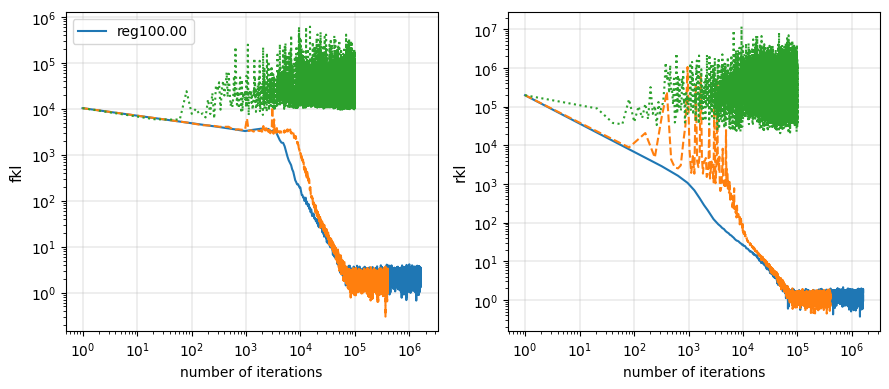

In [11]:
D = 2048
regs = [0.01, 0.1, 1.0, 10.0, 100]
regs = [100]
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

j = 0 
for metric in ['fkl', 'rkl']:
    i = 0
    for reg in regs:
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B32-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B32-reg{reg:0.2f}_current-reset/{metric}.npy'))
            ax[j].plot(nevals, loss, label=f'reg{reg:0.2f}', color=f'C{i}')
        except Exception as e:
            print(e)
        i += 1

    i = 1
    for reg in regs:
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/{metric}.npy'))
            # ax[j].plot(np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/{metric}.npy')), 
            ax[j].plot(nevals, loss, color=f'C{i}', ls="--")
        except Exception as e:
            print(e)
        i += 1

    i = 2
    for reg in regs:
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B2-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B2-reg{reg:0.2f}_current-reset/{metric}.npy'))
            # ax[j].plot(np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/{metric}.npy')), 
            ax[j].plot(nevals, loss, color=f'C{i}', ls=":")
        except Exception as e:
            print(e)
        i += 1
        
    ax[j].set_ylabel(metric, fontsize=11)
    j += 1


for axis in ax:
    axis.loglog()
    ax[0].legend()
    axis.set_xlabel("number of iterations")
    axis.grid(lw=0.3)
plt.tight_layout()

plt.show()

In [ ]:
D = 2048
regs = [0.01, 0.1, 1.0, 10.0, 100]
regs = [100]
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

j = 0 
for metric in ['fkl', 'rkl']:
    i = 0
    for reg in regs:
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B32-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B32-reg{reg:0.2f}_current-reset/{metric}.npy'))
            ax[j].plot(nevals, loss, label=f'reg{reg:0.2f}', color=f'C{i}')
        except Exception as e:
            print(e)
        i += 1

    i = 1
    for reg in regs:
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/{metric}.npy'))
            # ax[j].plot(np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/{metric}.npy')), 
            ax[j].plot(nevals, loss, color=f'C{i}', ls="--")
        except Exception as e:
            print(e)
        i += 1

    i = 2
    for reg in regs:
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B2-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B2-reg{reg:0.2f}_current-reset/{metric}.npy'))
            # ax[j].plot(np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B8-reg{reg:0.2f}_current-reset/{metric}.npy')), 
            ax[j].plot(nevals, loss, color=f'C{i}', ls=":")
        except Exception as e:
            print(e)
        i += 1
        
    ax[j].set_ylabel(metric, fontsize=11)
    j += 1


for axis in ax:
    axis.loglog()
    ax[0].legend()
    axis.set_xlabel("number of iterations")
    axis.grid(lw=0.3)
plt.tight_layout()

plt.show()

## compare with ADVI

In [ ]:
D = 512
B = 8

fig, ax = plt.subplots(1, 2, figsize=(9, 4))

j = 0 
for metric in ['fkl', 'rkl']:
    i = 0
    for reg in [0.01, 0.1, 1.0, 10.0, 100]:
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B{B}-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/pbam_lawrence/B{B}-reg{reg:0.2f}_current-reset/{metric}.npy'))
            ax[j].plot(nevals, loss, label=f'reg{reg:0.2f}')
        except Exception as e:
            print(e)
    
    i = 0
    for lr in [0.001, 0.01, 0.02, 0.05, 0.1, 0.2]:
        i += 1
        try:
            # nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/padvi/B{B}-lr{lr:0.3f}//nevals.npy'))
            # loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/padvi/B{B}-lr{lr:0.3f}//{metric}.npy'))
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/padvi/B{B}-lr{lr:0.3f}-linschedule/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/padvi/B{B}-lr{lr:0.3f}-linschedule/{metric}.npy'))
            # nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/padvi/B{B}-lr{lr:0.3f}-cosineschedule/nevals.npy'))
            # loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R32-seed0/padvi/B{B}-lr{lr:0.3f}-cosineschedule/{metric}.npy'))

            ax[j].plot(nevals, loss, label=f'lr{lr:0.3f}', color=f'C{i}', ls="--")
        except Exception as e:
            print(e)

        ax[j].set_ylabel(metric, fontsize=11)
    j += 1
    
for axis in ax:
    axis.loglog()
    ax[0].legend()
    axis.set_xlabel("number of iterations")
    axis.grid(lw=0.3)
plt.tight_layout()

plt.show()

## compare ranks

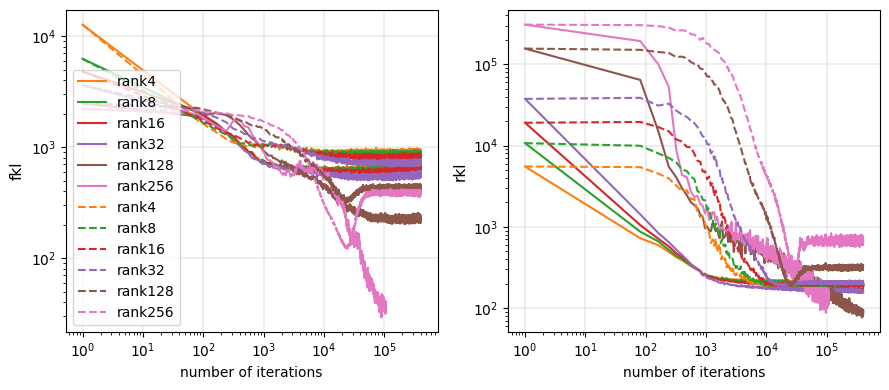

In [13]:
D = 1024
B = 8

fig, ax = plt.subplots(1, 2, figsize=(9, 4))

j = 0 
reg = 10
for metric in ['fkl', 'rkl']:
    i = 0
    for r in [4, 8, 16, 32, 128, 256]:
        i += 1
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R256-seed0/ranklr{r}/pbam_lawrence/B{B}-reg{reg:0.2f}_current-reset/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R256-seed0/ranklr{r}/pbam_lawrence/B{B}-reg{reg:0.2f}_current-reset/{metric}.npy'))
            ax[j].plot(nevals, loss, label=f'rank{r}', color=f'C{i}', ls="-")
        except Exception as e:
            print(e)
    
    i = 0
    lr = 0.01
    for r in [4, 8, 16, 32, 128, 256]:
    # for lr in [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]:
        i += 1
        try:
            nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R256-seed0/ranklr{r}/padvi/B{B}-lr{lr:0.3f}/nevals.npy'))
            loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R256-seed0/ranklr{r}/padvi/B{B}-lr{lr:0.3f}/{metric}.npy'))
            # nevals = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R256-seed0/padvi/ranklr{r}/B{B}-lr{lr:0.3f}-linschedule/nevals.npy'))
            # loss = np.load((f'/mnt/ceph/users/cmodi/pbam/Gauss-D{D}-ranknorm/R256-seed0/padvi/ranklr{r}/B{B}-lr{lr:0.3f}-linschedule/{metric}.npy'))
            ax[j].plot(nevals, loss, label=f'rank{r}', color=f'C{i}', ls="--")
        except Exception as e:
            print(e)

        ax[j].set_ylabel(metric, fontsize=11)
    j += 1
    
for axis in ax:
    axis.loglog()
    ax[0].legend()
    axis.set_xlabel("number of iterations")
    axis.grid(lw=0.3)
plt.tight_layout()

plt.show()


In [52]:
cov = np.load('/mnt/ceph/users/cmodi/pbam/Gauss-D2048-nonorm/R32-seed0/cov.npy')

In [53]:
np.linalg.cond(cov)

1169956.45418099

# cosmog

In [465]:
import sys
sys.path.append('../../../VBS/src/')
import vbs_tools

In [466]:
# plt.plot(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/R8/rkl.npy'), marker='.')

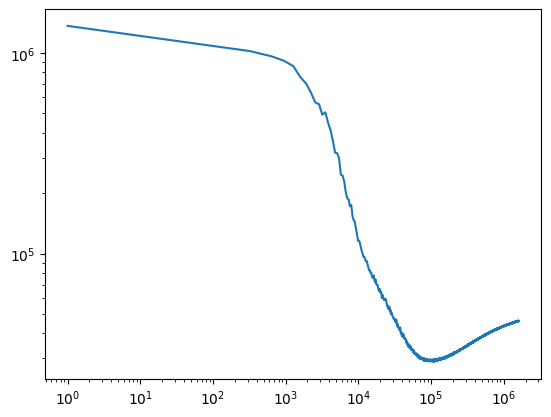

In [488]:
strue = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/modes.npy')

nc = 32
D = nc**3
ranklr = 32
reg = 0.1
sch = 1.0
suff=""

meanfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//mean_fit.npy')
psifit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//psi_fit.npy')
llfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//llambda_fit.npy')
iparams = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//iparams.npy')
rkl = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//rkl.npy')
nevals = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//nevals.npy')

plt.plot(nevals, rkl)
plt.loglog()
meanfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0//mean_fit.npy')
psifit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0//psi_fit.npy')
llfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0//llambda_fit.npy')

# meanfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0-modeinit//mean_fit.npy')
# psifit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0-modeinit//psi_fit.npy')
# llfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0-modeinit//llambda_fit.npy')

# meanfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched0.5/mean_fit.npy')
# psifit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched0.5//psi_fit.npy')
# llfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched0.5//llambda_fit.npy')

# mean0, mean1 = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0//means.npy')[[0, -1]]
# psi0, psi1 = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0//psis.npy')[[0, -1]]
# ll0, ll1 = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0//llambdas.npy')[[0, -1]]




In [489]:
iparams[-1]

50000

In [490]:
# shmc = np.load('/mnt/ceph/users/cmodi/pmwdruns/zsampling2_N32/S0/zsamples.npy')


In [491]:
# shmc.shape

In [492]:
eps = np.random.normal(0, 1, (100, D))
z = np.random.normal(0, 1, (100, ranklr))
s  = meanfit + psifit*eps + (llfit@z.T).T

# s = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched1.0-modeinit//mode_fit.npy')
# s = np.expand_dims(s, 0)

# eps = np.random.normal(0, 1, (100, D))
# z = np.random.normal(0, 1, (100, ranklr))
# s0  = mean0 + psi0*eps + (ll0@z.T).T

# eps = np.random.normal(0, 1, (100, D))
# z = np.random.normal(0, 1, (100, ranklr))
# s1  = mean1 + psi1*eps + (ll1@z.T).T


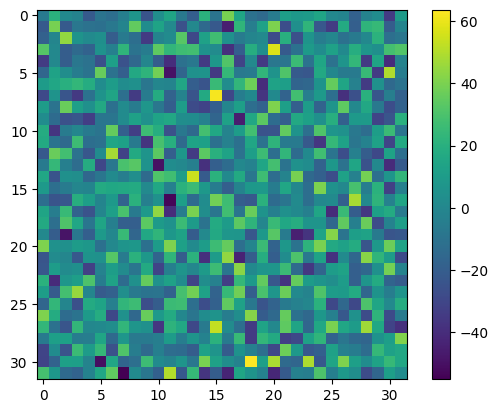

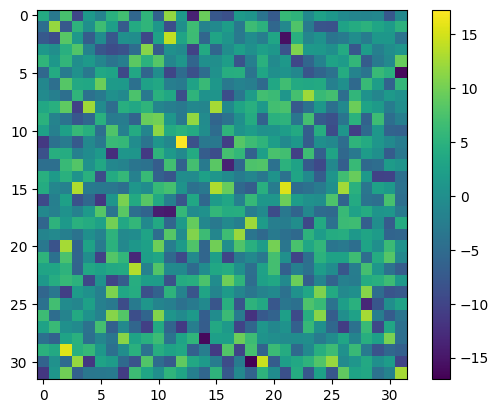

In [493]:
nc = 32
plt.imshow(s[0].reshape(nc, nc, nc).sum(axis=0))
plt.colorbar()
plt.show()
plt.imshow(strue.reshape(nc, nc, nc).sum(axis=0))
plt.colorbar()
plt.show()

In [494]:
# s = np.reshape(np.load('/mnt/ceph/users/cmodi/pmwdruns/padvi_N32/S0/MAP/mode_fit.npy'), (1, nc, nc, nc))
# plt.imshow(s[0].sum(axis=0))

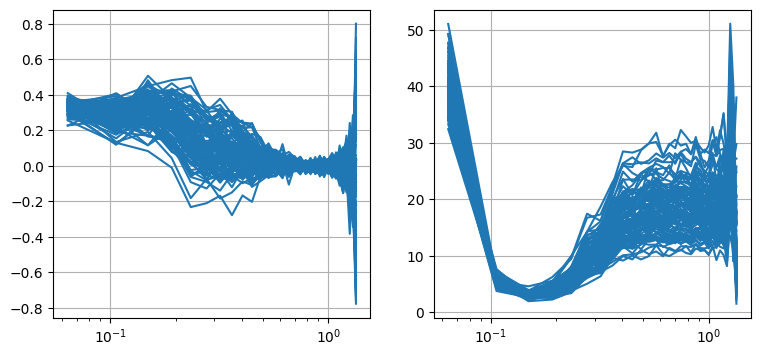

In [495]:
i = 10

fig, ax  = plt.subplots(1, 2, figsize=(9, 4))

k, p1 = vbs_tools.power(1 + strue, boxsize=4*32)
# ax[1].plot(k, p1, 'k')

for i in range(100):
    k, p2 = vbs_tools.power(1 + s[i].reshape(nc, nc, nc), boxsize=4*32)
    k, px = vbs_tools.power(1 + strue, 1 + s[i].reshape(nc, nc, nc), boxsize=4*32)
    ax[0].plot(k, px/(p1*p2)**0.5, 'C0', label='best')
    ax[1].plot(k, p2/p1, 'C0', label='best')

# for i in range(4):
#     k, p2 = vbs_tools.power(1 + shmc[-1, i].reshape(nc, nc, nc), boxsize=4*32)
#     k, px = vbs_tools.power(1 + strue, 1 + shmc[-1, i].reshape(nc, nc, nc), boxsize=4*32)
#     ax[0].plot(k, px/(p1*p2)**0.5, label='hmc')
#     ax[1].plot(k, p2)

# k, p2 = vbs_tools.power(1 + s0[i].reshape(nc, nc, nc), boxsize=4*32)
# k, px = vbs_tools.power(1 + strue, 1 + s0[i].reshape(nc, nc, nc), boxsize=4*32)
# ax[0].plot(k, px/(p1*p2)**0.5, 'C1', label='init')
# ax[1].plot(k, p2, 'C1', label='init')

# k, p2 = vbs_tools.power(1 + s1[i].reshape(nc, nc, nc), boxsize=4*32)
# k, px = vbs_tools.power(1 + strue, 1 + s1[i].reshape(nc, nc, nc), boxsize=4*32)
# ax[0].plot(k, px/(p1*p2)**0.5, 'C2', label='fin')
# ax[1].plot(k, p2, 'C2', label='fin')

for axis in ax:
    axis.grid()
    axis.semilogx()
    # axis.legend()
# ax[1].loglog()
# ax[0].set_ylim(-0.1, 1.1)

In [521]:
400/32

12.5

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R4-reg0.01-sched0.5//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R4-reg0.01-sched0.5-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R4-reg0.01-sched1.0//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R4-reg0.01-sched1.0-modeinit//mean_fit.npy'
B32-R4-reg0.10-sched0.5 33500


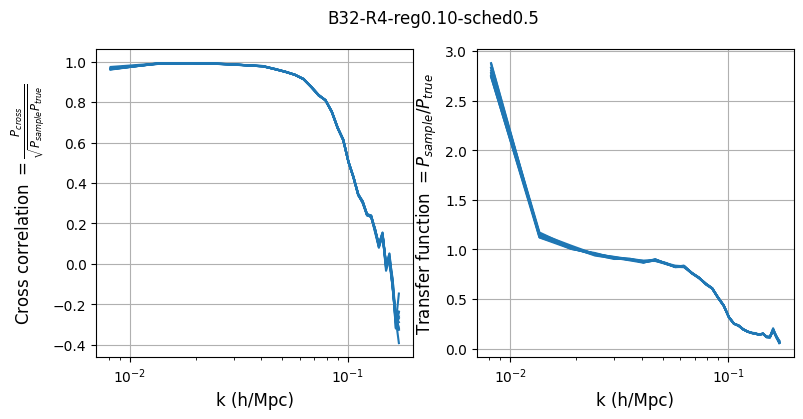

B32-R4-reg0.10-sched0.5-modeinit 31000


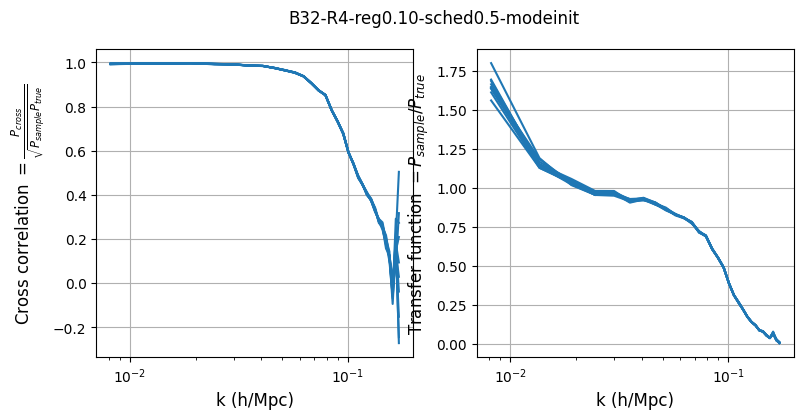

B32-R4-reg0.10-sched1.0 123000


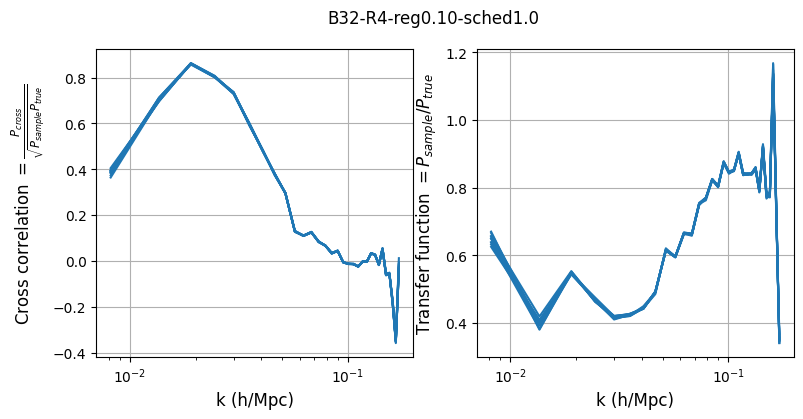

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R4-reg0.10-sched1.0-modeinit//mean_fit.npy'
B32-R4-reg1.00-sched0.5 32500


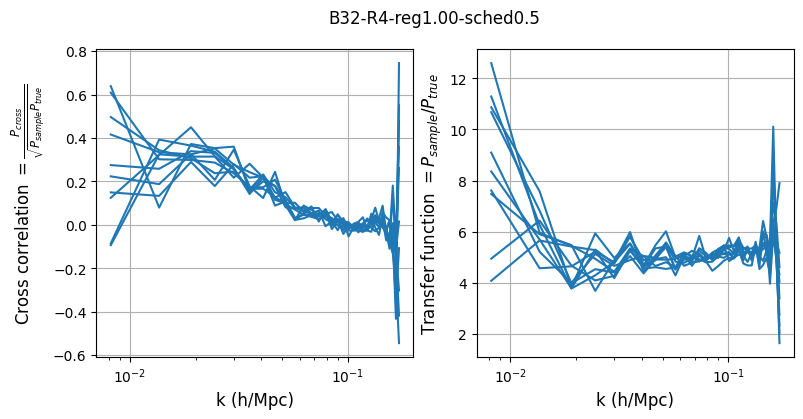

B32-R4-reg1.00-sched0.5-modeinit 30000


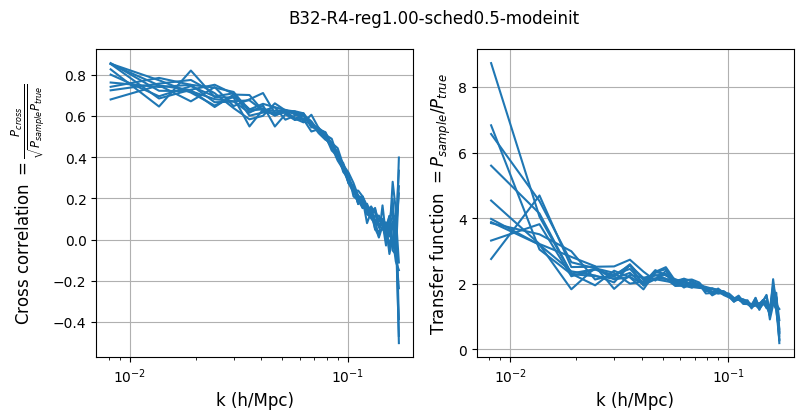

B32-R4-reg1.00-sched1.0 123500


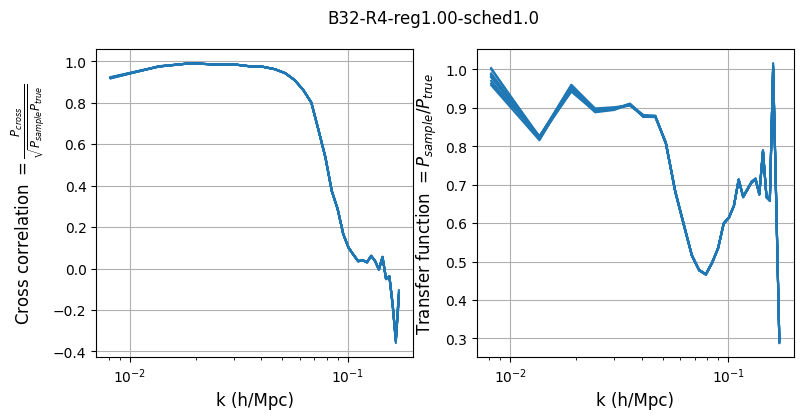

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R4-reg1.00-sched1.0-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R8-reg0.01-sched0.5//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R8-reg0.01-sched0.5-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R8-reg0.01-sched1.0//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R8-reg0.01-sched1.0-modeinit//mean_fit.npy'
B32-R8-reg0.10-sched0.5 31500


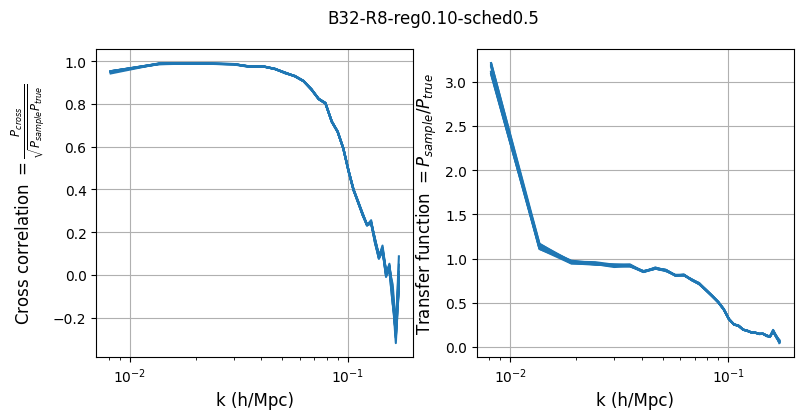

B32-R8-reg0.10-sched0.5-modeinit 29500


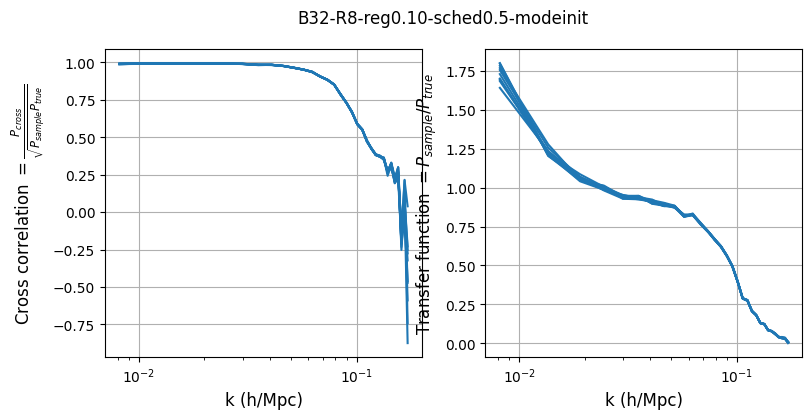

B32-R8-reg0.10-sched1.0 115000


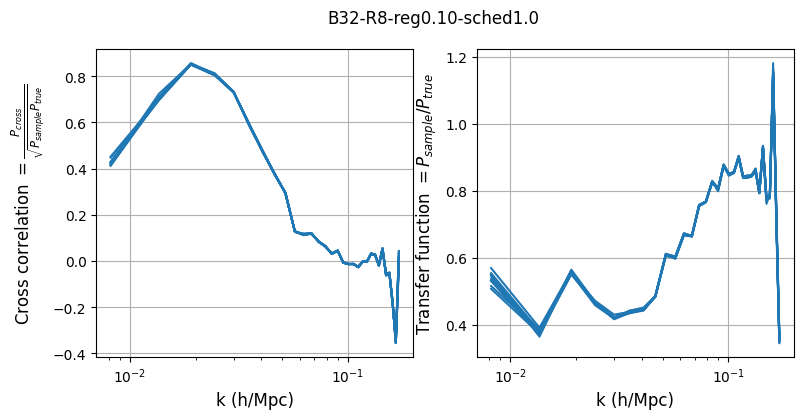

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R8-reg0.10-sched1.0-modeinit//mean_fit.npy'
B32-R8-reg1.00-sched0.5 30000


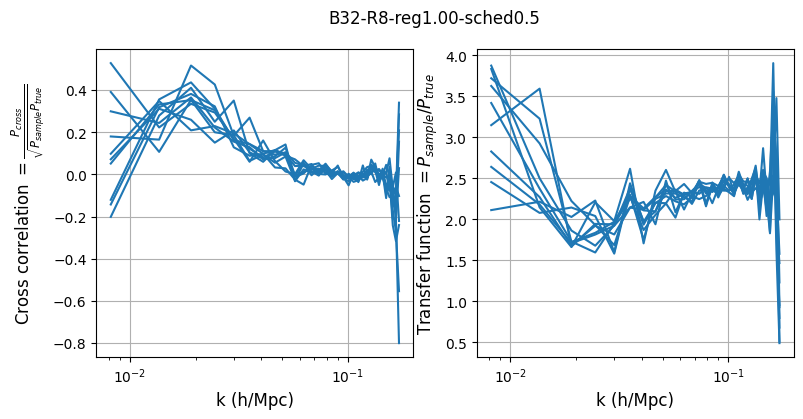

B32-R8-reg1.00-sched0.5-modeinit 28500


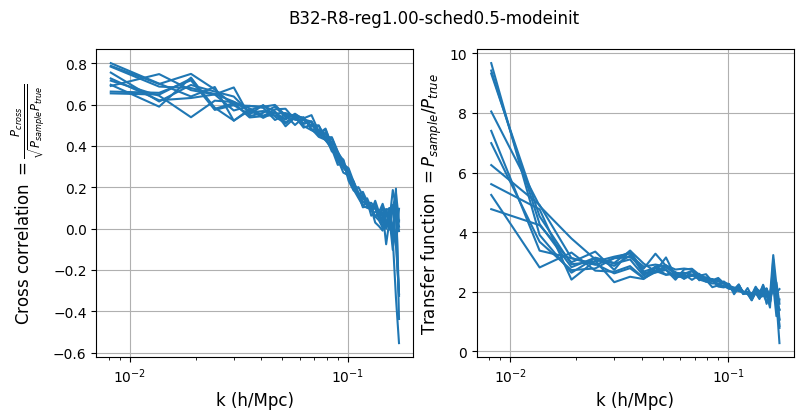

B32-R8-reg1.00-sched1.0 115000


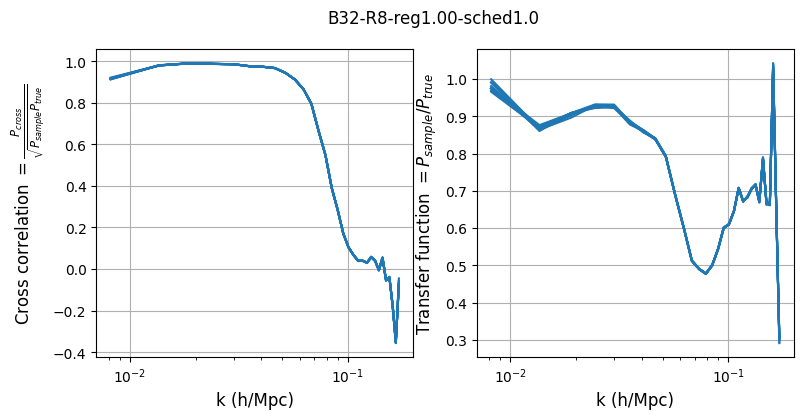

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R8-reg1.00-sched1.0-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg0.01-sched0.5//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg0.01-sched0.5-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg0.01-sched1.0//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg0.01-sched1.0-modeinit//mean_fit.npy'
B32-R16-reg0.10-sched0.5 29500


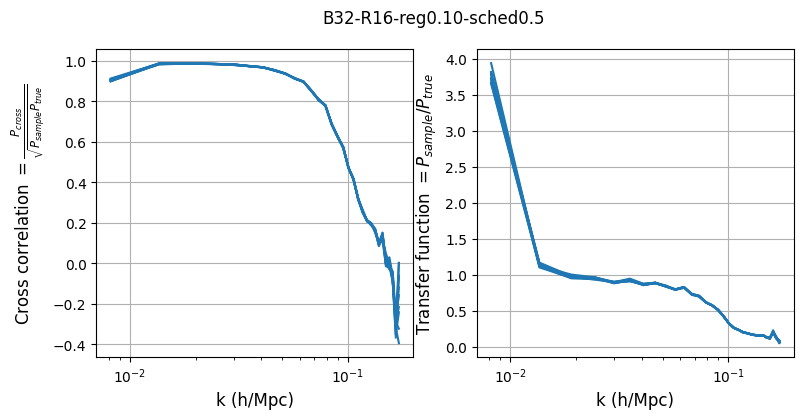

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg0.10-sched0.5-modeinit//mean_fit.npy'
B32-R16-reg0.10-sched1.0 31500


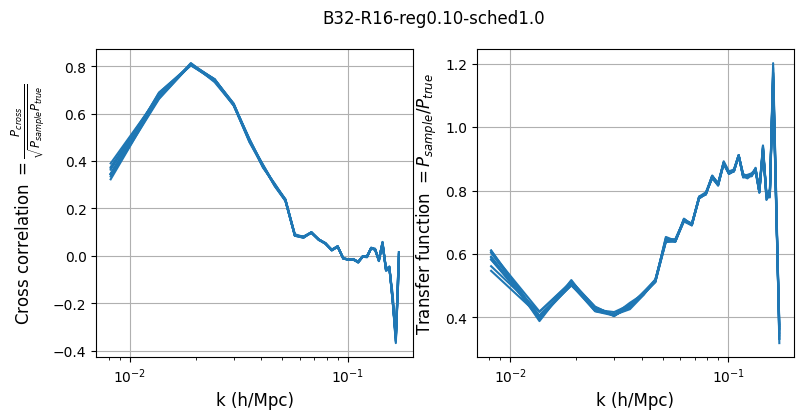

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg0.10-sched1.0-modeinit//mean_fit.npy'
B32-R16-reg1.00-sched0.5 28500


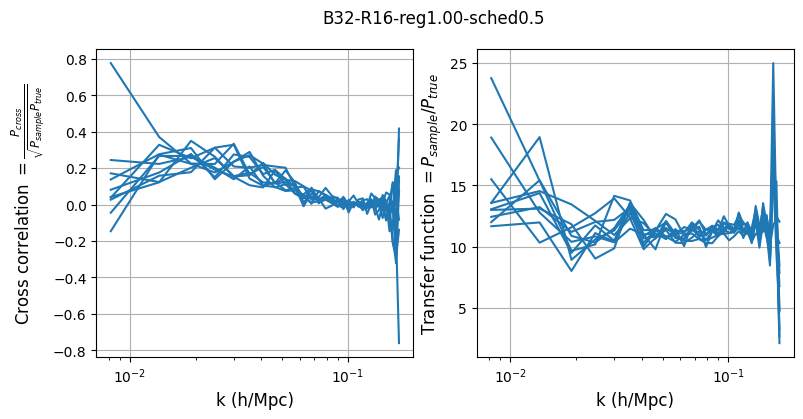

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg1.00-sched0.5-modeinit//mean_fit.npy'
B32-R16-reg1.00-sched1.0 31500


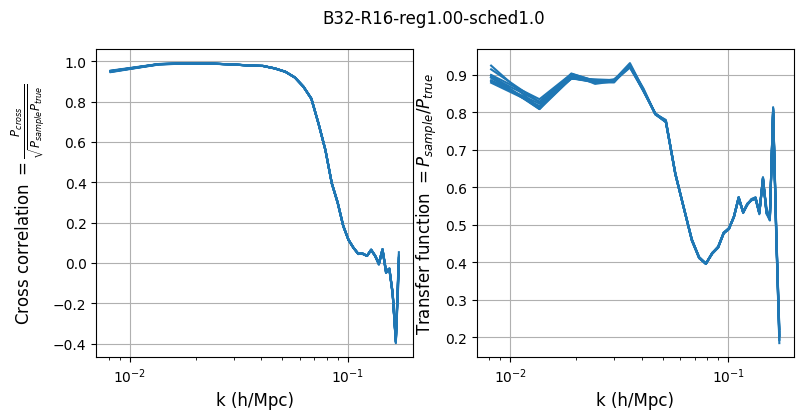

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R16-reg1.00-sched1.0-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg0.01-sched0.5//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg0.01-sched0.5-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg0.01-sched1.0//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg0.01-sched1.0-modeinit//mean_fit.npy'
B32-R32-reg0.10-sched0.5 27000


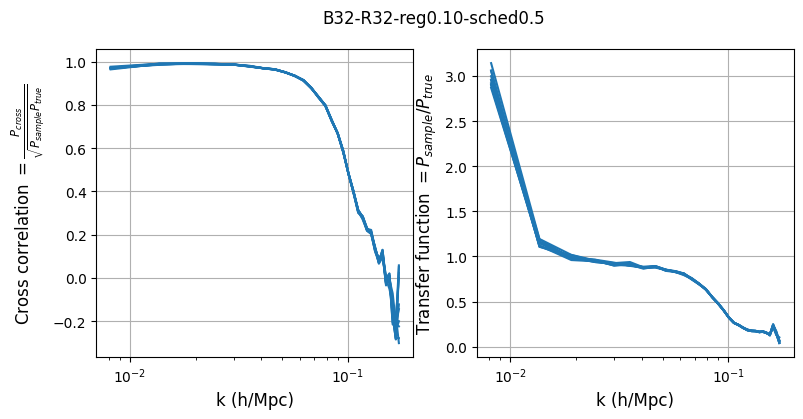

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg0.10-sched0.5-modeinit//mean_fit.npy'
B32-R32-reg0.10-sched1.0 27500


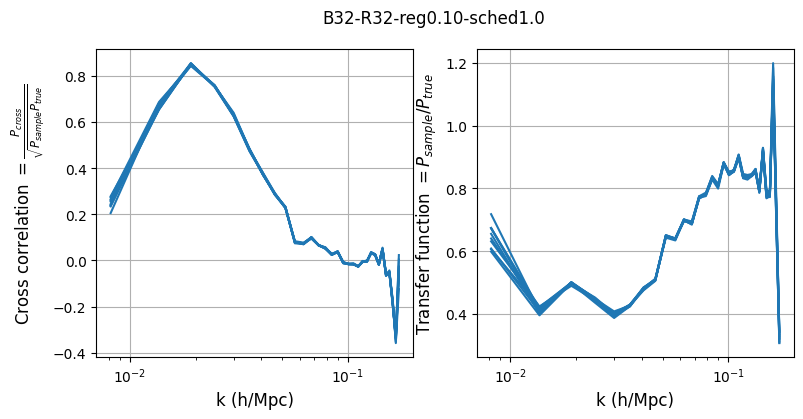

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg0.10-sched1.0-modeinit//mean_fit.npy'
B32-R32-reg1.00-sched0.5 26500


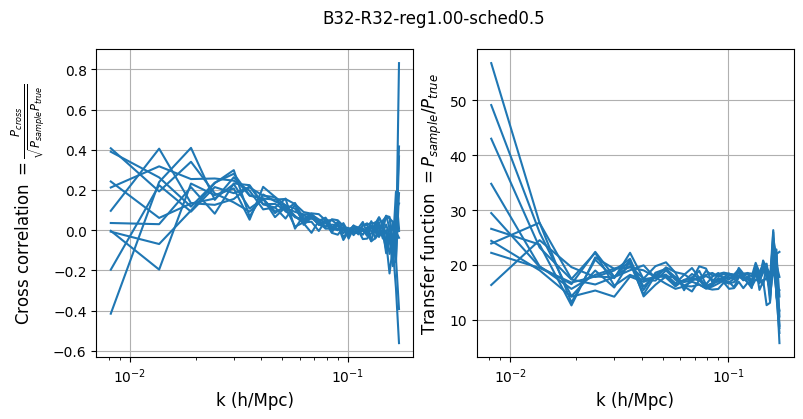

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg1.00-sched0.5-modeinit//mean_fit.npy'
B32-R32-reg1.00-sched1.0 28000


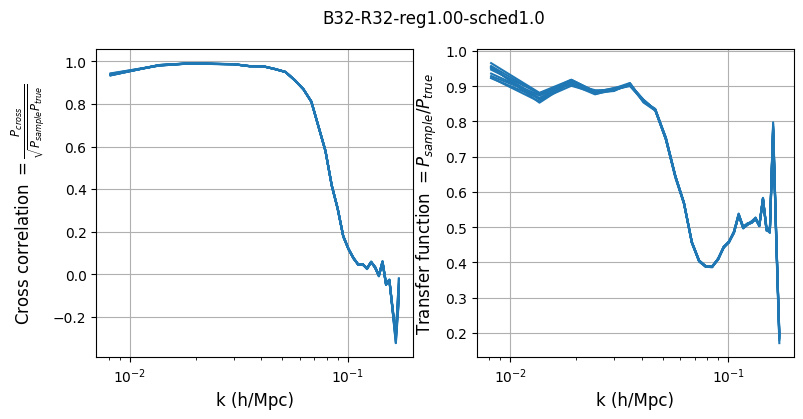

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R32-reg1.00-sched1.0-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg0.01-sched0.5//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg0.01-sched0.5-modeinit//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg0.01-sched1.0//mean_fit.npy'
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg0.01-sched1.0-modeinit//mean_fit.npy'
B32-R64-reg0.10-sched0.5 24000


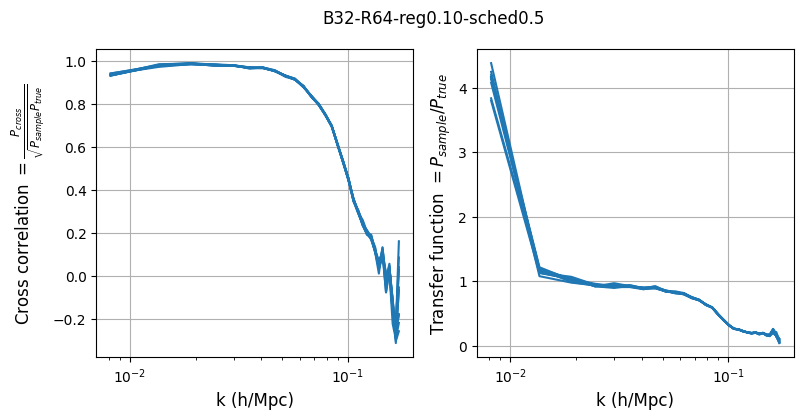

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg0.10-sched0.5-modeinit//mean_fit.npy'
B32-R64-reg0.10-sched1.0 24000


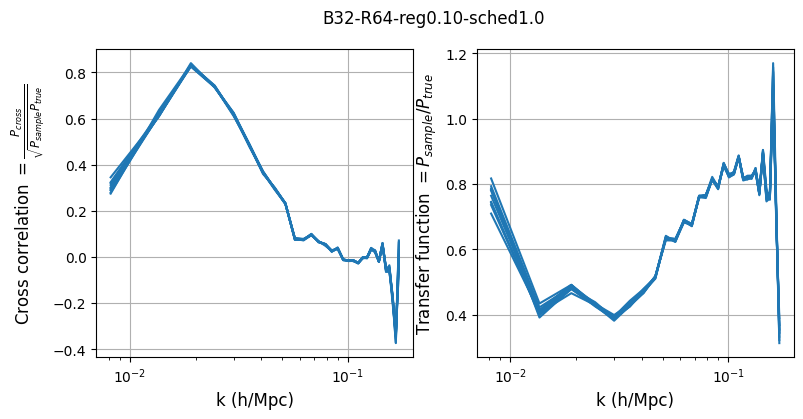

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg0.10-sched1.0-modeinit//mean_fit.npy'
B32-R64-reg1.00-sched0.5 23000


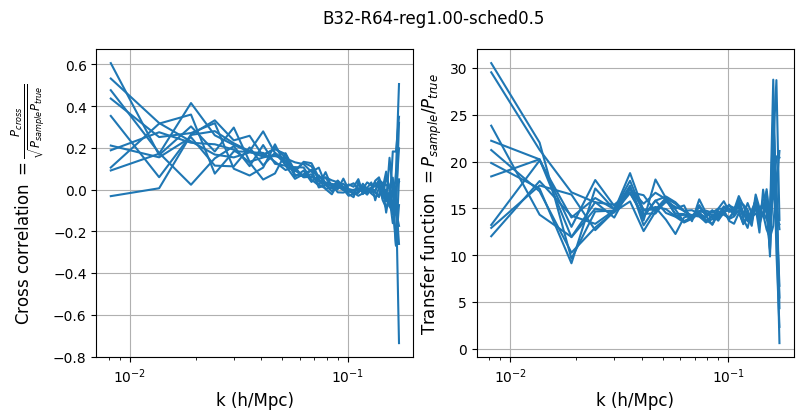

[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg1.00-sched0.5-modeinit//mean_fit.npy'
cannot reshape array of size 1605616 into shape (32768,64)
[Errno 2] No such file or directory: '/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R64-reg1.00-sched1.0-modeinit//mean_fit.npy'


In [626]:
nc = 32
D = nc**3
bs = 1000.

# strue = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_1step/modes.npy')
strue = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10//modes.npy')

for ranklr in [4, 8, 16, 32, 64]:
# for ranklr in [32]:
    for reg in [0.01, 0.1, 1.0]:
        for sch in [0.5, 1.0]:
            for suff in ["", "-modeinit"]:
            # for suff in ["-modeinit"]:

                try:
                    key = f'B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}'
                    # meanfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//mean_fit.npy')
                    # psifit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step//B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//psi_fit.npy')
                    # llfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step//B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//llambda_fit.npy')
                    # iparams = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step//B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//iparams.npy')
                    # print(key, iparams[-1])
                    
                    meanfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step_dn0.10/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//mean_fit.npy')
                    psifit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step_dn0.10//B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//psi_fit.npy')
                    llfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step_dn0.10/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//llambda_fit.npy')
                    iparams = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L{bs}_N32_1step_dn0.10/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//iparams.npy')
                    print(key, iparams[-1])

                    
                    eps = np.random.normal(0, 1, (10, D))
                    z = np.random.normal(0, 1, (10, ranklr))
                    s  = meanfit + psifit*eps + (llfit@z.T).T

                    
                    fig, ax  = plt.subplots(1, 2, figsize=(9, 4))
                    
                    k, p1 = vbs_tools.power(1 + strue, boxsize=bs)
                    # ax[1].plot(k, p1, 'k')
                    
                    for i in range(10):
                        k, p2 = vbs_tools.power(1 + s[i].reshape(nc, nc, nc), boxsize=bs)
                        k, px = vbs_tools.power(1 + strue, 1 + s[i].reshape(nc, nc, nc), boxsize=bs)
                        ax[0].plot(k, px/(p1*p2)**0.5, 'C0', label='best')
                        ax[1].plot(k, p2/p1, 'C0', label='best')
                    for axis in ax:
                        axis.grid()
                        axis.semilogx()
                        axis.set_xlabel('k (h/Mpc)', fontsize=12)
                    ax[0].set_ylabel(r'Cross correlation $=\frac{P_{cross}}{\sqrt{P_{sample}P_{true}}}$', fontsize=12)
                    ax[1].set_ylabel('Transfer function $=P_{sample}/P_{true}$', fontsize=12)
                    plt.suptitle(f'B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}')
                    plt.show()
                    
                except Exception as e: 
                    print(e)
                    pass

In [ ]:
np.random.normal()

[]

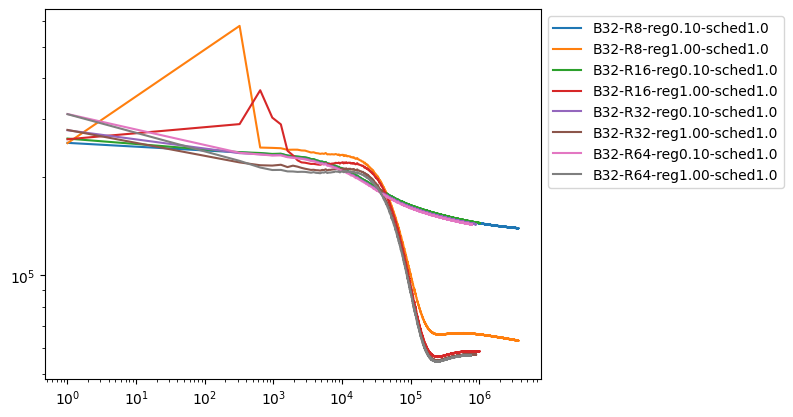

In [625]:
nc = 32
D = nc**3

i = 0 
# for ranklr in [4, 8, 16, 32, 64]:
for ranklr in [8, 16, 32, 64]:
    # for reg in [0.01, 0.1, 1.0]:
    for reg in [ 0.1, 1.0]:
        # for sch in [0.5, 1.0]:
        for sch in [ 1.0]:
            # for suff in ["", "-modeinit"]:
            for suff in [""]:

                try:
                    # meanfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//mean_fit.npy')
                    # psifit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//psi_fit.npy')
                    # llfit = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//llambda_fit.npy')
                    # iparams = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_3step/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//iparams.npy')                    
                    # rkl = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_3step//B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//rkl.npy')
                    # nevals = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_3step//B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//nevals.npy')
                    rkl = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10//B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//rkl.npy')
                    nevals = np.load(f'/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}//nevals.npy')
                    # print(iparams[-1])
                    lbl = f'B32-R{ranklr}-reg{reg:0.2f}-sched{sch:0.1f}{suff}'
                    plt.plot(nevals, rkl, f'C{i}', label=lbl)
                    plt.plot(nevals, -rkl, f'C{i}--')
                    i += 1
                except Exception as e: 
                    print(e)
                    pass
plt.legend(bbox_to_anchor=(1,1))
plt.loglog()

In [594]:
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R4-reg1.00-sched1.0/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R8-reg1.00-sched1.0/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R32-reg1.00-sched1.0/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R4-reg0.10-sched1.0/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R8-reg0.10-sched1.0/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R32-reg0.10-sched1.0/rkl.png'))


# # display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R4-reg1.00-sched1.0/rkl.png'))
# # display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R8-reg1.00-sched1.0/rkl.png'))
# # display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R32-reg1.00-sched1.0/rkl.png'))
# # display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R4-reg0.10-sched1.0/rkl.png'))
# # display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R8-reg0.10-sched1.0/rkl.png'))
# # display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbamcheat_N32/S0/B32-R32-reg0.10-sched1.0/rkl.png'))


# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R8-reg1.00-sched0.5/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R32-reg1.00-sched0.5/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R8-reg0.10-sched0.5/rkl.png'))
# display(Image('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/S0/B32-R32-reg0.10-sched0.5/rkl.png'))

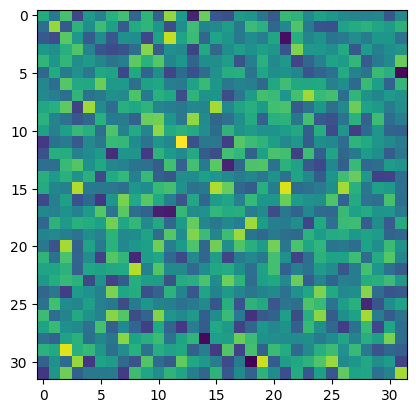

In [131]:
plt.imshow(np.load('/mnt/ceph/users/abayer/pmwd/sampling/output/s0_nc32_bs128_astart1.000e-01_da1.800e-01_order1_dn1.00/nuts/Omd0.300_s8d0.812/gibbs0/S10000C1_mtd5_e1.00e-02_b1000_t1_z_p3_dmc0_amm0/sh0/modes.npy').sum(axis=0))

In [509]:
zsamples = []
for i in range(5):
    zsamples.append(np.load(f'/mnt/ceph/users/abayer/pmwd/sampling/output/s0_nc32_bs128_astart1.000e-01_da1.800e-01_order1_dn1.00/nuts/Omd0.300_s8d0.812/gibbs0/S10000C1_mtd5_e1.00e-02_b1000_t1_z_p3_dmc0_amm0/sh{i}/zsamples.npy')[::100])
    # zsamples.append(np.load(f'/mnt/ceph/users/abayer/pmwd/sampling/output/s0_nc32_bs128_astart1.000e-01_da1.800e-01_order1_dn1.00/nuts/Omd0.300_s8d0.812/gibbs0/S10000C1_mtd5_e1.00e-02_b1000_t1_z_p3_dmc0_amm0/sh{i}/zsamples_warmup0.npy')[::10])


In [16]:
zsamples[0].shape

(100, 32768)

In [201]:
strue = np.load('/mnt/ceph/users/abayer/pmwd/sampling/output/s0_nc32_bs128_astart1.000e-01_da1.800e-01_order1_dn1.00/nuts/Omd0.300_s8d0.812/gibbs0/S10000C1_mtd5_e1.00e-02_b1000_t1_z_p3_dmc0_amm0/sh0/modes.npy')
data = np.load('/mnt/ceph/users/abayer/pmwd/sampling/output/s0_nc32_bs128_astart1.000e-01_da1.800e-01_order1_dn1.00/nuts/Omd0.300_s8d0.812/gibbs0/S10000C1_mtd5_e1.00e-02_b1000_t1_z_p3_dmc0_amm0/sh0/dens_h.npy')


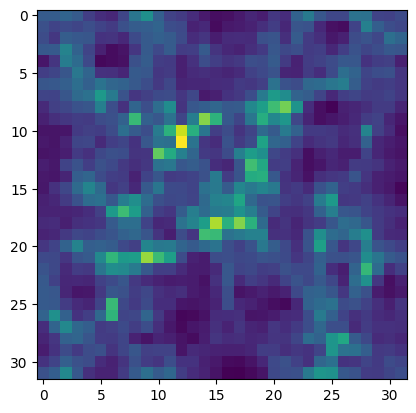

In [202]:
plt.imshow(data.sum(axis=0))

In [203]:
nc = 32

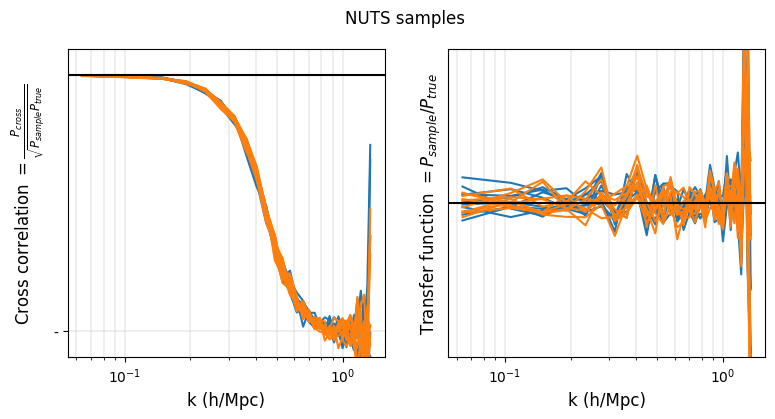

In [518]:
i = 10

fig, ax  = plt.subplots(1, 2, figsize=(9, 4))

k, p1 = vbs_tools.power(1 + strue, boxsize=4*32)

for j in range(2):
    for i in range(0, 100, 10):
        k, p2 = vbs_tools.power(1 + zsamples[j][i].reshape(nc, nc, nc), boxsize=4*32)
        k, px = vbs_tools.power(1 + strue, 1 + zsamples[j][i].reshape(nc, nc, nc), boxsize=4*32)
        ax[0].plot(k, px/(p1*p2)**0.5, f'C{j}', '-', label='hmc')
        ax[1].plot(k, p2/p1, f'C{j}', '-')


for axis in ax:
    axis.grid(which='both', lw=0.3)
    axis.semilogx()
    axis.axhline(1, color='k')
    axis.set_xlabel('k (h/Mpc)', fontsize=12)
ax[0].set_ylabel(r'Cross correlation $=\frac{P_{cross}}{\sqrt{P_{sample}P_{true}}}$', fontsize=12)
ax[1].set_ylabel('Transfer function $=P_{sample}/P_{true}$', fontsize=12)
    # axis.legend()
ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(0.5, 1.5)
plt.suptitle('NUTS samples')
plt.show()

In [616]:
# tmp = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/L128_N32_5step/dens.npy')
# tmp2 = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_3step/dens.npy')
# tmp3 = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_1step/dens.npy')
tmp = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/L128_N32_5step/data.npy')
tmp2 = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_3step/data.npy')
tmp3 = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_1step/data.npy')
tmp4 = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/data.npy')
tmp5 = np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10/dens.npy')


[]

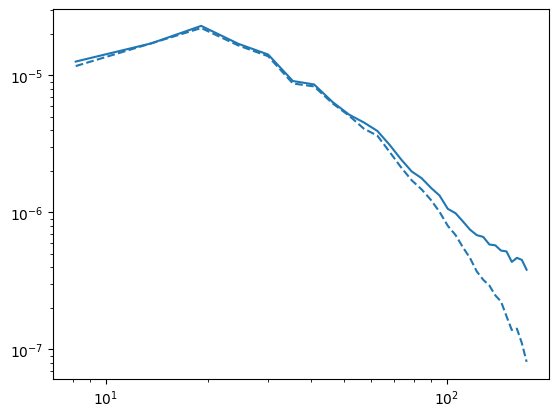

In [611]:
# plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/L128_N32_5step/data.npy')), 'C0')
# plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam_N32/L128_N32_5step/dens.npy')), 'C0--')
# plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step/data.npy')), 'C0')
# plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step/dens.npy')), 'C0--')
# plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_3step/data.npy')), 'C0')
# plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L400.0_N32_3step/dens.npy')), 'C0--')
plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10//data.npy')), 'C0')
plt.plot(*vbs_tools.power(np.load('/mnt/ceph/users/cmodi/pmwdruns/pbam/L1000.0_N32_1step_dn0.10//dens.npy')), 'C0--')
plt.loglog()
# vbs_tools.power(tmp2, boxsize=400)

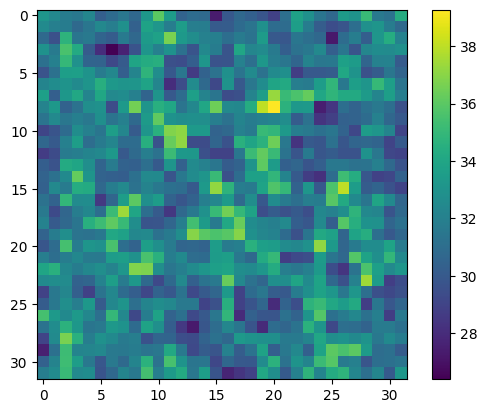

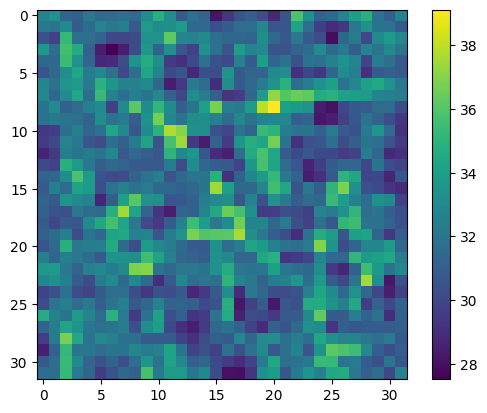

In [617]:
plt.imshow(tmp4.sum(axis=0))
plt.colorbar()
plt.show()
plt.imshow(tmp5.sum(axis=0))
plt.colorbar()

In [573]:
strue2 = np.load('/mnt/ceph/users/abayer/pmwd/sampling/output/s0_nc32_bs400_astart1.000e-01_da3.000e-01_order1_dn1.00/nuts/Omd0.300_s8d0.812/gibbs0/S10000C1_mtd5_e1.00e-02_b1000_t1_z_p3_dmc0_amm0/sh0/modes.npy')

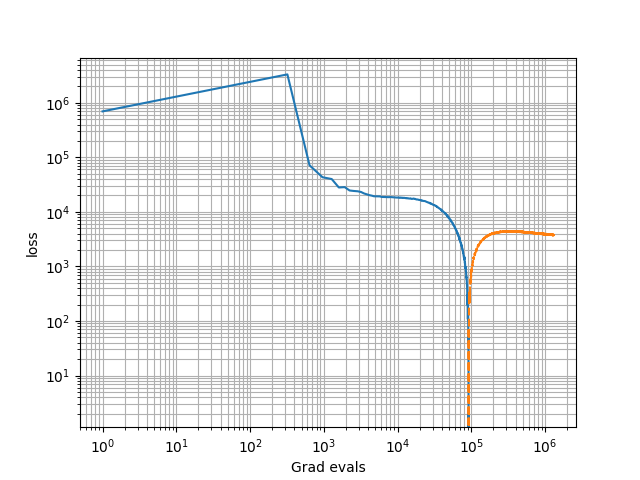

In [526]:
Image('/mnt/ceph/users/cmodi/pmwdruns/L400.0_N32_3step/B32-R32-reg1.00-sched1.0/rkl.png')

# posteriorDB

In [9]:
REFERENCE_FOLDER = "/mnt/ceph/users/cmodi/PosteriorDB/"
BRIDGESTAN = "/mnt/home/cmodi/Research/Projects/bridgestan/"
reference_path =  f'{REFERENCE_FOLDER}/'
MODELDIR = '/mnt/home/cmodi/Research/Projects/AtlasSampler/'
sys.path.append('/mnt/home/cmodi/Research/Projects/AtlasSampler/experiments/')
import models

sys.path.append('/mnt/home/cmodi/Research/Projects/posterior_database/')
from posteriordb import BSDB, BSModels
from jax_utils import jaxify_bs


from gsmvi.bbvi import ADVI_LR, ADVI_Factorized

In [10]:
model, D, lp, lp_g, ref_samples, files = models.stan_model('stochastic_volatility', 0,
                                                           bridgestan_path=BRIDGESTAN,
                                                           model_directory=MODELDIR,
                                                           reference_samples_path=reference_path,
                                                           run_nuts=False)
bsmodel = BSModels(model)
lpjax, lp_itemjax = jaxify_bs(bsmodel)
lp = bsmodel.lp
lp_g = lambda x: bsmodel.lp_g(x)[1]
lpjaxsum = jit(lambda x: jnp.sum(lpjax(x)))
ref_samples = ref_samples.reshape([-1, D])
ref_samples_unc = bsmodel.unconstrain(ref_samples)
print(D)
# lp_vmap = bsmodel.lp
# lp_g_vmap = bsmodel.lp_g

# lp_vmap = lambda x: jax.vmap(lp, in_axes=0)(x.astype(float32))
# lp_g_vmap = lambda x: jax.vmap(lp_g, in_axes=0)(x.astype(float32))


503


In [11]:
start = time()
# alg = GSM(D, lp_vmap, lp_g_vmap)
alg = BAM(D, lpjaxsum, lp_g)
key = jax.random.PRNGKey(1)
batch_size = 32
niter = 500
regf = lambda x: 10/(1+x)**0.5
nprint = 10
mean_init = None #ref_samples_unc.mean(axis=0)
cov_init  = None #np.eye(D)*0.1
monitorbam = KLMonitor(batch_size=32, ref_samples=ref_samples_unc, checkpoint=10)
meanfitbam, covfitbam = alg.fit(key,  mean=mean_init, cov=cov_init,
                                batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitorbam, check_goodness=True)
print('time taken : ', time()-start)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


use low rank
Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
time taken :  110.97405862808228


In [12]:
start = time()
# alg = GSM(D, lp_vmap, lp_g_vmap)
algpbam = PBAM(D, lpjaxsum, lp_g)
key = jax.random.PRNGKey(1)
batch_size = 32
niter = 500
regf = lambda x: 100/(1+x)**0.5
nprint = 10

ranklr = 128
psi_init = np.random.random(D)*1
llambda_init = np.random.random((D, ranklr))/(D*ranklr)**0.5
monitorpbam = KLMonitor(batch_size=32, ref_samples=ref_samples_unc, checkpoint=10)
meanfitpbam, psifitpbam, llfitpbam = algpbam.fit(key, rank=ranklr, mean=mean_init, psi=psi_init, llambda=llambda_init,
                                batch_size=batch_size, niter=niter, regf=regf, nprint=nprint, monitor=monitorpbam, check_goodness=True)
covfitpbam = np.diag(psifitpbam) + llfitpbam@llfitpbam.T
print('time taken : ', time()-start)


Iteration 0 of 500. Time taken :  3.5762786865234375e-06
jit pbam update
jit psi/llambda update
compiled
time for first 10 iterations :  7.363849878311157
Iteration 50 of 500. Time taken :  14.680986166000366
Iteration 100 of 500. Time taken :  22.388291597366333
Iteration 150 of 500. Time taken :  30.63540768623352
Iteration 200 of 500. Time taken :  40.420275926589966
Iteration 250 of 500. Time taken :  50.61266565322876
Iteration 300 of 500. Time taken :  60.843546628952026
Iteration 350 of 500. Time taken :  70.80024933815002
Iteration 400 of 500. Time taken :  81.0531702041626
Iteration 450 of 500. Time taken :  90.94138240814209
Iteration 500 of 500. Time taken :  100.06217432022095
Total number of projections :  2980 5.96
time taken :  104.344477891922


In [13]:
start = time()
# niter=1000
# batch_size = 8
lr = 0.02

algbbvi = ADVI_LR(D, ranklr, lpjaxsum, jit_compile=True)
schedule = optax.schedules.linear_schedule(lr, 1e-5, niter)
opt = optax.adam(learning_rate=schedule)
monitorbbvi = KLMonitor(batch_size=32, ref_samples=ref_samples_unc, checkpoint=5)
meanfitbbvi, psibbvi, llambdabbvi, losses = algbbvi.fit(key, opt=opt, mean=mean_init, psi=psi_init, llambda=llambda_init,
                                            batch_size=batch_size, niter=niter, monitor=monitorbbvi, nprint=nprint)
covfitbbvi = np.diag(psibbvi) + llambdabbvi@llambdabbvi.T
print("time taken : ", time() - start)



jit compile True True
Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
time taken :  14.395105600357056


In [14]:
start = time()
# niter=1000
# batch_size = 8
lr = 0.02

algfacvi = ADVI_Factorized(D,  lpjaxsum, jit_compile=True)
schedule = optax.schedules.linear_schedule(lr, 1e-5, niter)
opt = optax.adam(learning_rate=schedule)
monitorfacvi = KLMonitor(batch_size=32, ref_samples=ref_samples_unc, checkpoint=5)
meanfitfacvi, scalefitfacvi, losses = algfacvi.fit(key, opt=opt, mean=mean_init, scale=psi_init**0.5,
                                            batch_size=batch_size, niter=niter, monitor=monitorfacvi, nprint=nprint)
# covfitbbvi = np.diag(scales)
print("time taken : ", time() - start)


Iteration 0 of 500
Iteration 50 of 500
Iteration 100 of 500
Iteration 150 of 500
Iteration 200 of 500
Iteration 250 of 500
Iteration 300 of 500
Iteration 350 of 500
Iteration 400 of 500
Iteration 450 of 500
Iteration 500 of 500
time taken :  5.595273733139038


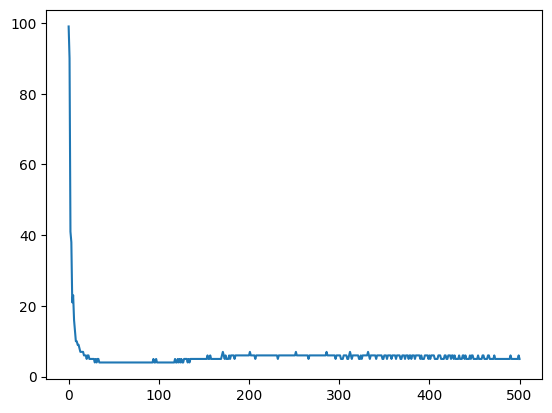

In [15]:
plt.plot(monitorpbam.nprojects)

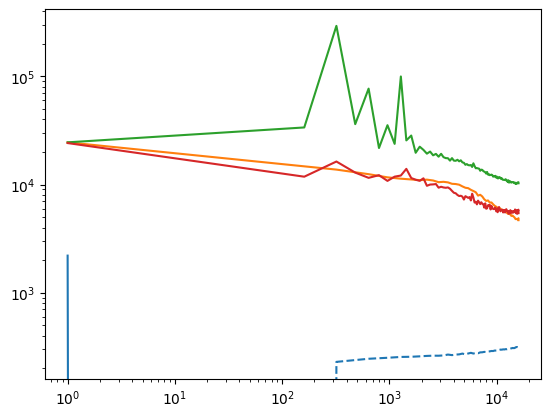

[]

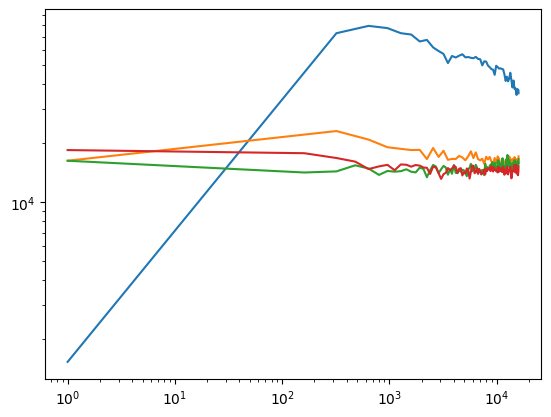

In [16]:
plt.plot(monitorbam.nevals, monitorbam.rkl, 'C0')
plt.plot(monitorbam.nevals, -np.array(monitorbam.rkl), 'C0--')
plt.plot(monitorpbam.nevals, monitorpbam.rkl, 'C1')
plt.plot(monitorpbam.nevals, -np.array(monitorpbam.rkl), 'C1--')
plt.plot(monitorbbvi.nevals, monitorbbvi.rkl, 'C2')
plt.plot(monitorbbvi.nevals, -np.array(monitorbbvi.rkl), 'C2--')
plt.plot(monitorfacvi.nevals, monitorfacvi.rkl, 'C3')
plt.plot(monitorfacvi.nevals, -np.array(monitorfacvi.rkl), 'C3--')
plt.loglog()
plt.show()
plt.plot(monitorbam.nevals, monitorbam.fkl, 'C0')
plt.plot(monitorbam.nevals, -np.array(monitorbam.fkl), 'C0--')
plt.plot(monitorpbam.nevals, monitorpbam.fkl, 'C1')
plt.plot(monitorpbam.nevals, -np.array(monitorpbam.fkl), 'C1--')
plt.plot(monitorbbvi.nevals, monitorbbvi.fkl, 'C2')
plt.plot(monitorbbvi.nevals, -np.array(monitorbbvi.fkl), 'C2--')
plt.plot(monitorfacvi.nevals, monitorfacvi.fkl, 'C3')
plt.plot(monitorfacvi.nevals, -np.array(monitorfacvi.fkl), 'C3--')
plt.loglog()
# plt.show()

0


(-5.0, 5.0)

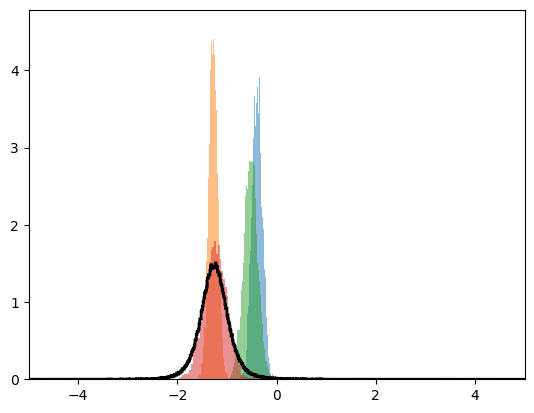

In [22]:
i = np.random.randint(D)
i = 0
print(i)
plt.hist(ref_samples_unc[:, i], density=True, alpha=1, histtype='step', lw=2, color='k', bins='auto')
plt.hist(np.random.multivariate_normal(meanfitbam, covfitbam, 5000)[:, i], density=True, alpha=0.5, bins='auto');
plt.hist(np.random.multivariate_normal(meanfitpbam, covfitpbam, 5000)[:, i], density=True, alpha=0.5, bins='auto');
plt.hist(np.random.multivariate_normal(meanfitbbvi, covfitbbvi, 5000)[:, i], density=True, alpha=0.5, bins='auto');
plt.hist(np.random.multivariate_normal(meanfitfacvi, np.diag(scalefitfacvi**2), 5000)[:, i], density=True, alpha=0.5, bins='auto');
# plt.axvline(mean_init[i])
plt.xlim(-5, 5)

[160 472 126   3  79]


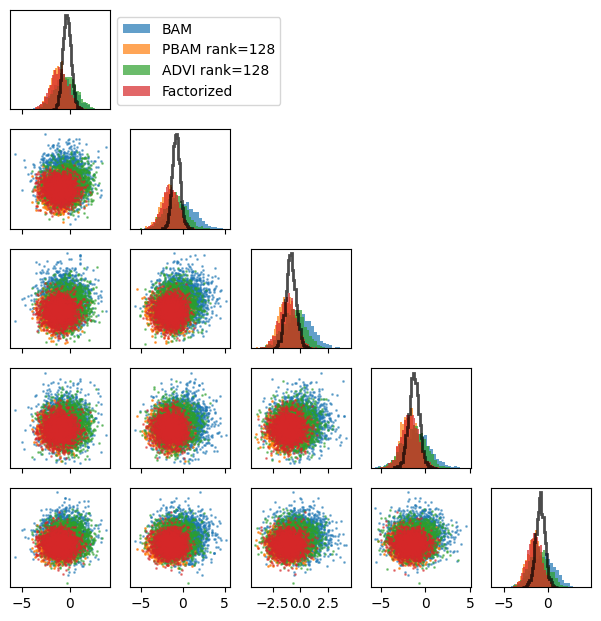

In [23]:
s = ref_samples_unc[:5000, :] 
s1 = np.random.multivariate_normal(meanfitbam, covfitbam, 2000)
s2 = np.random.multivariate_normal(meanfitpbam, covfitpbam, 2000)
s3 = np.random.multivariate_normal(meanfitbbvi, covfitbbvi, 2000)
s4 = np.random.multivariate_normal(meanfitfacvi, np.diag(scalefitfacvi**2), 2000)

dplot = min(D, 5)
fig, ax = plt.subplots(dplot, dplot, figsize=(dplot*1.5, dplot*1.5), sharex='col')
idx = np.random.permutation(np.arange(D))[:dplot]
print(idx)
for i in range(dplot):
    for j in range(dplot):
        ii, jj = idx[i], idx[j]
        if i == j: 
            ax[i, i].hist(s[..., ii], alpha=0.7, density=True, bins=30, color='k', histtype='step', lw=2);
            if s1 is not None: ax[i, i].hist(s1[..., ii], alpha=0.7, density=True, bins=30, label=f"BAM");
            if s2 is not None: ax[i, i].hist(s2[..., ii], alpha=0.7, density=True, bins=30, label=f"PBAM rank={ranklr}");
            if s3 is not None: ax[i, i].hist(s3[..., ii], alpha=0.7, density=True, bins=30, label=f"ADVI rank={ranklr}");
            if s4 is not None: ax[i, i].hist(s4[..., ii], alpha=0.7, density=True, bins=30, label=f"Factorized");
            
        elif j > i:
            ax[j, i].plot(s[..., ii], s[..., jj], '.', alpha=1., ms=2, color='k')
            if s1 is not None: ax[j, i].plot(s1[..., ii], s1[..., jj], '.', alpha=0.5, ms=2)
            if s2 is not None: ax[j, i].plot(s2[..., ii], s2[..., jj], '.', alpha=0.7, ms=2)
            if s3 is not None: ax[j, i].plot(s3[..., ii], s3[..., jj], '.', alpha=0.5, ms=2)
            if s4 is not None: ax[j, i].plot(s4[..., ii], s4[..., jj], '.', alpha=0.5, ms=2)
            
        else: 
            ax[j, i].set_axis_off()
            
ax[0, 0].legend(bbox_to_anchor=(1,1))
for axis in ax.flatten():
    axis.set_yticks([])
# plt.tight_layout()



In [19]:
llfitpbam.max(), llfitpbam.min()


(Array(0.239849, dtype=float64), Array(-0.1673816, dtype=float64))

In [20]:
llfitpbam.shape

(503, 128)

In [21]:
np.diag(llfitpbam@llfitpbam.T) /psifitpbam

Array([3.15652598e+02, 2.63413187e+01, 5.39522796e+01, 7.47224880e-02,
       1.28114753e-01, 8.96552248e-02, 7.46002884e-02, 9.52798374e-02,
       7.65264825e-02, 1.29483782e-01, 1.05381403e-01, 9.72439286e-02,
       1.28758919e-01, 1.16363187e-01, 1.24464438e-01, 1.53923876e-01,
       1.11752788e-01, 1.17048704e-01, 1.30064437e-01, 7.32101707e-02,
       9.92335479e-02, 1.05297547e-01, 1.07992817e-01, 1.04930273e-01,
       9.88997671e-02, 1.36099945e-01, 1.08481786e-01, 1.01131103e-01,
       1.10817596e-01, 1.14999541e-01, 1.13322033e-01, 7.69841614e-02,
       1.01211314e-01, 1.26174464e-01, 1.38654589e-01, 1.00319176e-01,
       8.79038478e-02, 6.39048882e-02, 6.13885771e-02, 9.83357197e-02,
       5.65740213e-02, 8.94500924e-02, 8.83418461e-02, 7.87836244e-02,
       7.09241807e-02, 6.26805878e-02, 6.54688063e-02, 6.91440960e-02,
       1.34556182e-01, 9.90940642e-02, 1.05059229e-01, 1.38617046e-01,
       9.16336562e-02, 7.15955231e-02, 8.14653677e-02, 6.26739185e-02,
      